# Proyecto final: Clustering de usuarios de MyAnimeList: Hallando patrones y tendencias por comunidad

## Introducción

Nótese que, debido a la gran cantidad de información que debió ser extraída para realizar este
proyecto, se vio necesario crear variados archivos `jupyter notebook` adicionales para realizar la extracción
de datos. Todos ellos guardan la información necesaria en la carpeta `data/`.

Estos archivos deben ejecutarse en el siguiente orden:

Ruta primera (MyAnimeList):

1. `scraper_usuarios.ipynb`
2. `api_listas.ipynb`
3. `nombres_anime.ipynb`

Ruta segunda (AnimePlanet):

1. `nombres_anime_planet.ipynb`
2. `tags.ipynb`

Una vez terminadas ambas rutas al 100%, se puede proceder a ejecutar el archivo
`procesar_data.ipynb`. 

Es muy necesario para la efectiva realización de este proyecto. Dada la magnitud de este (ya
cuenta con una excesiva cantidad de celdas), y lo
exigente del tiempo para mandar los requests, se vio conveniente modularizar el proceso de
extracción de datos en varios archivos, que a su vez cada uno explica lo realizado específicamente.

Este archivo ya tiene una inmensa cantidad de celdas, y haber colocado todo en un solo archivo
hubiese sido muy poco práctico y contraproducente.

## Imports 

In [440]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import time
from random import randint
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import random
from scipy.sparse import csr_matrix
from io import BytesIO
from PIL import Image, ImageFont, ImageDraw
import ast
import io
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import (
    silhouette_score,
    davies_bouldin_score,
    calinski_harabasz_score,
)
from collections import Counter

## Contexto y motivación

En cualquier afición o actividad de interés con cierto nivel de popularidad, tienden a generarse
comunidades muy distintas que comparten el mismo pasatiempo en común. A fin de cuentas, los
humanos somos diferentes a lo largo del mundo, y existen hobbies de tan nivel de amplitud y variedad
que pueden coexistir múltiples razones para que sean atrayentes, pero... ¿cuáles son dichas razones?
¿Cuán heterogéneo resulta ser el universo interesado en cierto tema arbitrario? En este proyecto,
principalmente se tratará de identificar las diversas comunidades presentes en aquellos fans de la
animación japonesa.

La industria del anime moderno nació alrededor de la década de 1960, y desde entonces cada vez ha
gozado de una mayor popularidad. Según ciertas estadísticas (Ferjan, 2023), alrededor de más de un
tercio de la población mundial ve anime, lo que equivale a 2,88 mil millones de personas. Además, la
base de datos de artes multimedia japonesas cuenta con más de 136.700 obras bajo la categoría de
anime en sus registros. En los Estados Unidos, se estima que más del 50% de la generación Z ve anime
(Ferjan, 2023), y se proyecta que conforme avance el tiempo el reconocimiento de esta industria
ciertamente será mayor en nuestras vidas. En un ámbito más local, según un análisis de Google Trends,
se vio que Chile es el quinto país en el cual el anime es más popular (Ferjan, 2023).
Por otro lado, se procederá a dar un poco de contexto respecto a lo que es MyAnimeList. Es un sitio
web fundado en 2004 por el estadounidense Garrett Gyssler, que tiene como propósito primario el ser
una herramienta para que sus usuarios puedan registrar el anime y manga que han visto,
inscribiéndose en el concepto de **comunidad virtual de catalogación**; término que Urban Dictionary
define de la siguiente manera:

* *"Un subconjunto de los medios sociales, un sitio web o aplicación web que permite a los
usuarios catalogar digitalmente las cosas que les preocupan -música, libros, películas,
arte, gastronomía, artesanía, bricolaje, etc-, mientras que al mismo tiempo pueden
compartir su contenido en una comunidad en línea".* (Urban Dictionary, 2011)

Hoy en día, MyAnimeList es una compañía de bolsa, operada por el grupo Media Do desde 2019. La
creación de una cuenta de usuario con cerca de todas las funcionalidades asociadas es gratis, mas
también se ofrece un servicio mensual de 2,99 dólares para ser un “seguidor de MAL”; que ofrece los
beneficios de eliminación de anuncios de la página junto a la posibilidad de una mayor personalización
del perfil propio. Como grupo, creemos que estos beneficios que se obtienen por pagar mensualmente
son escasos y no valen mucho la pena, por lo que, frente a esta problemática, planteamos una factible
posible solución. Ella consiste en que se ofrezcan como funcionalidades pagadas el que sitio web le
permita al usuario saber al respecto sobre en cuál comunidad probablemente se identifique más; qué
serie, en base a lo anterior, le parezca mejor y sea recomendado que vea, entre un sinfín de otras
estadísticas personalizadas que se podrían obtener trabajando correctamente el enorme banco de
datos que sustenta MyAnimeList. Nótese que, muy recientemente, el sitio web ha implementado una
[página](https://myanimelist.net/profile/Xinil/statistics) de estadísticas personalizada para cada usuario, que justamente recoge la idea de que si se
desean saber todos los datos o gráficos sea necesario pagar. El inconveniente con ello es que aún
esas estadísticas que se ofrecen son muy simples a nuestro parecer; no siendo lo suficientemente
interesantes o con un trabajo serio por detrás; y es debido a ello que nos interesó la posibilidad de
ampliar masivamente la cantidad de información valiosa que podría estar ahí. Básicamente, el único
tipo de estadísticas que brinda MyAnimeList son del carácter descriptivo elemental, como cantidad de
animes visualizados (entre muchas otras cosas), promedios, distribuciones de calificaciones o
desviaciones estándar; medidas que cualquier persona podría fácilmente calcular o graficar con el
suficiente tiempo.

En síntesis, observamos una oportunidad actualmente malgastada en MyAnimeList, que podría
significar una importante ganancia económica para Media Do si es implementada correctamente, y
para ello es indispensable utilizar las herramientas y el conocimiento de Ciencia de Datos. A partir de
lo anterior, resulta evidente señalar a los trabajadores de Media Do como el público objetivo de este
proyecto, pues sin lugar a duda serían los mayores beneficiarios al ser ellos quienes lograrían mejorar
la rentabilidad de su compañía tomando como base las ideas desarrolladas por este trabajo. Como
comentario aparte, nótese que ello es coherente con las aspiraciones financieras de Media Do, dado
que un antecedente existente en 2019 (Ressler, 2019) da cuenta que dicha compañía tiene intenciones
de fortalecer MyAnimeList; mejorando las funcionalidades del sitio como una plataforma de marketing
y distribuidora de libros electrónicos. De manera indirecta, débase decirse que este proyecto tiene
como público a todas aquellas personas que les gustaría saber y estudiar las diversas comunidades y
sus características, que existen, como mínimo, entre los actuales usuarios de MyAnimeList (cerca de
15.106.951 cuentas bajo un registro del 9 de octubre de 2023 (MyAnimeList, 2023)).


No siendo una cuestión menos relevante, débase decirse que la inspiración inicial para escoger este
proyecto proviene de enterarse del proyecto hecho por el profesor Hernán Valdivieso, que
vigentemente realiza clases de Programación Avanzada y Visualización de Información en la Pontificia
Universidad Católica de Chile. Su proyecto consistió en, primeramente, armar un enorme dataset de
MyAnimeList, que recopiló en el siguiente [repositorio](https://github.com/Hernan4444/MyAnimeList-Database?tab=readme-ov-file#myanimelist-database-2020) de GitHub, titulado: “MyAnimeList-Database”.
Este repositorio cuenta con la información de la lista de animes de 325.772 usuarios diferentes, y
también con la información de 17.562 animes distintos. Nótese que dichos datos fueron extraídos en
parte (las preferencias de los usuarios) con la [Jikan API](https://jikan.docs.apiary.io/), entre
el 26 de febrero y el 20 de marzo de 2020. 

Sin embargo, para nuestro proyecto usaremos la [MyAnimeList API](https://myanimelist.net/apiconfig/references/api/v2), dado que es la oficial del
sitio web; siendo la Jikan una API no oficial. Ello tiene coherencia dado que la API oficial no estaba
disponible para su utilización en el momento donde el profesor hizo su dataset, puesto que en 2020
recién se habilitó desde el 6 de julio, según lo mencionado en el siguiente [post](https://myanimelist.net/forum/?topicid=1849732). A modo de abreviar,
considérese que escribir MAL es equivalente a escribir MyAnimeList.


Otro comentario importante que vale la pena destacar es la cuestión de la procedencia de las etiquetas.
Como contexto, cada entrada de anime en MAL cuenta con dos elementos cuya intención es resumir
lo fundamental o estilo de cada serie: géneros y temas. El problema con estos apartados es que
resultaría realmente difícil trabajar con ellos puesto que se requeriría realizar primero la labor previa
de comprobar la verdadera importancia de cada uno; además de que complejizaría innecesariamente
a posteriori un adecuado clustering. Para paliar dicha situación, el docente nos informó de que otro
sitio web, similar en funcionalidad a MAL, llamado [Anime-Planet](https://www.anime-planet.com/), cuenta con un sistema mejor de
etiquetación de sus animes. En este, existe un único apartado llamado -tags-, que podría decirse
que combina los géneros y temas que coloca MAL; y además suelen existir más (lo cual genera que se
pueda reconocer con una mayor facilidad las temáticas y “esencia” de la serie; característica
sumamente positiva para nuestra idea de proyecto). Se verá este aspecto inmediatamente a
continuación con un ejemplo (Welcome to the NHK!) del cual se tiene el conocimiento para aseverar
si es notoria la mejora de este apartado en Anime-Planet en comparación a MyAnimeList.


Géneros de Welcome to the NHK! en MAL: Comedy, Drama, Romance.


Temas de Welcome to the NHK! en MAL: Adult Cast, Otaku Culture, Psychological

Tags de Welcome to the NHK! en Anime-Planet: Comedy, Drama, Slice of Life, Dark Comedy, Loneliness,
Mental Illness, NEET, Otaku Culture, Parody, Psychological, Satire, Based on a Light Novel.

Se verifica exitosamente que son los tags de Anime-Planet los cuales captan de la forma más completa
y fiel lo tratado en la obra audiovisual.

A partir de dicho trabajo realizado, nos dimos cuenta de que podría ser muy interesante el
cumplimiento de ciertos objetivos; que en la posterior sección se explayarán.

Como documentación de los múltiples tags con los que cuenta Anime-Planet, en la siguiente [página](https://www.anime-planet.com/anime/tags?page=1)
se describe cada uno.


## Preguntas objetivo

De las preguntas originales que planteamos en la propuesta, las siguientes son las que hemos
conservado.

Nótese que se vio que las no consideradas resultarían muy complejas para lo realizado, o, no se tuvo
el tiempo suficiente para trabajar en ellas, dado un sinfín de dificultades que se encontraron de
manera inesperada realizando el trabajo final. Cuando decimos que dificultades, nos referimos a
infinitas e infinitas cuestiones que hicieron de todo nuestro trabajo uno extremadamentre complejo
y lento, en el cual se tuvieron que hacer sacrificios mentales del primer orden. A pesar de ello,
se cree que el resultado final al cual se llegó resultó ser interesante.

De las interrogantes originales de la propuesta basal, rescatamos las siguientes:

1. ¿Cuáles grupos de usuarios se pueden formar a partir de las reviews que ellos hacen respecto
a los animes vistos, los diferentes animes visualizados y sus tags asociados? ¿Siquiera existen
esos grupos? En caso afirmativo, ¿qué nombres específicos representarían la esencia de los
grupos hallados?

2. Si existen los distintos grupos de MyAnimeList, ¿son suficientemente significativas las diferencias como para hacer buenas
recomendaciones o predicciones de otras variables?

3. ¿Se pueden hallar patrones o tendencias regulares en las variables de los animes “clásicos”
(entendiéndose que estos cuentan con una excepcional recepción positiva o fama o ambos)?
¿Cuáles son dichos patrones? ¿Tienen sentido con lo que normalmente se esperaría?

4. ¿Está correlacionada la cantidad de animes vistos con la "comunidad" que se pertenece? Dicha
interrogante también es factible de plantear reemplazando la cantidad de animes vistos con
otras variables del proyecto.
   
A continuación, se muestran las nuevas preguntas que aparecieron a lo largo del camino:

5. ¿La distribución de usuarios de anime sigue una distribución de Pareto?
    
6. ¿Cuáles son los tags de Anime-Planet más correlacionados entre sí? ¿Cuáles son los tags de Anime-Planet menos correlacionados entre sí?

## Datos

Para nuestros propósitos, usaremos originalmente tres distintos dataframes obtenidos de `data/`, y
a su vez estos fueron generados con los archivos `jupyter notebook` mencionados inicialmente, que
sirvieron para su construcción efectiva. En dichos archivos se documenta específicamente cómo se
obtuvieron y qué métodos se utilizaron para ello, junto a que procesamiento tuvieron (en ciertos
caso su manipulación fue muy compleja y actuó en varios niveles).

Nótese que estos dataframes son de identidad muy similar a los descritos en la propuesta de
proyecto, así que no tienen casi ninguna novedad por sí mismos. De todos maneras, en en la sección
de análisis exploratorio se explicará con más detalle la información que contienen, y ciertos
aspectos preliminares que se pueden observar de ellos, en aspectos variados.   

Los dataframes:

1. `users_df.pickle`: Contiene la información de las listas de anime de usuarios, indicando qué
   calificación le dio cada usuario a los animes que vio. Veáse con más detalle esto en la
   propuesta de proyecto. Este dataframe fue obtenido en base a la información existente en MyAnimeList.

2. `unified_df.csv`: Contiene los tags de cada anime, extraídos de AnimePlanet, contiene nombres,
   tags, y la id que lo asocia a el siguiente dataframe, detalles_anime.
   
3. `detalles_animes.csv`: Contiene la información de los detalles de cada anime, extraídos de
   MyAnimeList. Contiene diversas columnas cuya explicación a detalle se encuentra en la propuesta
   de proyecto. Este dataframe fue obtenido en base a la información existente en MyAnimeList.


### Dataframe 1: `users_df.pickle`



In [441]:
with open(os.path.join("data", "users_df.pickle"), "rb") as archivo:
    users_df = pickle.load(archivo)

In [5]:
users_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8978 entries, 24 to 33183
Columns: 7793 entries, 39110:xxbladexx20 to 16656371:Aoto_uchiha10
dtypes: Sparse[int8, nan](7793)
memory usage: 2.7 MB


In [9]:
users_df

39110:xxbladexx20  216949:haijuta  246587:d3athzero  107198:JayJay1401  \
24                  10.0             NaN              10.0                NaN   
519                 10.0             NaN               NaN                NaN   
846                 10.0             NaN               8.0                NaN   
849                 10.0             NaN               NaN                7.0   
1530                10.0             NaN               NaN                NaN   
...                  ...             ...               ...                ...   
40179                NaN             NaN               NaN                NaN   
40508                NaN             NaN               NaN                NaN   
41179                NaN             NaN               NaN                NaN   
41188                NaN             NaN               NaN                NaN   
33183                NaN             NaN               NaN                NaN   

       45036:Seleare  4328:Joseph_  110895:Rudenick  93256:Moltke  \
24               NaN           NaN              NaN           NaN   
519              NaN           NaN              NaN           NaN   
846              NaN           NaN              NaN           NaN   
849              NaN           9.0              NaN           NaN   
1530             NaN           9.0              9.0           NaN   
...              ...           ...              ...           ...   
40179            NaN           NaN              NaN           NaN   
40508            NaN           NaN              NaN           NaN   
41179            NaN           NaN              NaN           NaN   
41188            NaN           NaN              NaN           NaN   
33183            NaN           NaN              NaN           NaN   

       160129:dander  256598:melandrea  ...  16805797:iambabymango  \
24               8.0               NaN  ...                    NaN   
519              NaN               NaN  ...                    NaN   
846              7.0               NaN  ...                    NaN   
849             10.0               NaN  ...                    NaN   
1530             NaN               NaN  ...                    NaN   
...              ...               ...  ...                    ...   
40179            NaN               NaN  ...                    NaN   
40508            NaN               NaN  ...                    NaN   
41179            NaN               NaN  ...                    NaN   
41188            NaN               NaN  ...                    NaN   
33183            NaN               NaN  ...                    NaN   

       16809902:Flopoflop  16791488:RhaenyraFR  16838607:SasOnator  \
24                    NaN                  NaN                 NaN   
519                   NaN                  NaN                 NaN   
846                   NaN                  NaN                 NaN   
849                   NaN                  NaN                 NaN   
1530                  NaN                  NaN                 NaN   
...                   ...                  ...                 ...   
40179                 NaN                  NaN                 NaN   
40508                 NaN                  NaN                 NaN   
41179                 NaN                  NaN                 NaN   
41188                 NaN                  NaN                 NaN   
33183                 NaN                  NaN                 NaN   

       17063891:Dezwhite05  17197026:dumb_zoro_  16617450:kotyboh  \
24                     NaN                  NaN               NaN   
519                    NaN                  NaN               NaN   
846                    NaN                  NaN               NaN   
849                    NaN                  NaN               NaN   
1530                   NaN                  NaN               NaN   
...                    ...                  ...               ...   
40179                  NaN              

Veáse que cada fila representa el id del anime en MyAnimeList, y cada columna representa el id del
usuario más su username. En cada celda, se encuentra la calificación que el usuario le dio al anime
en cuestión. Nótese que, si el usuario no ha calificado el anime, la celda tendrá un NaN, lo que es
natural considerando que existen muchos anime y es casi imposible que un usuario haya calificado
todos los que han sido recopilados.

### Dataframe 2: `unified_df.csv`

In [442]:
unified_df = pd.read_csv(os.path.join("data", "unified_df.csv"))

In [11]:
unified_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8772 entries, 0 to 8771
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Anime   8772 non-null   object
 1   URL     8772 non-null   object
 2   Tags    8772 non-null   object
 3   Alts    4695 non-null   object
 4   id      8772 non-null   int64 
dtypes: int64(1), object(4)
memory usage: 342.8+ KB


In [12]:
unified_df

Anime  \
0                          Chiaki Kuriyama: "0"   
1     "Bungaku Shoujo" Kyou no Oyatsu: Hatsukoi   
2                      "Bungaku Shoujo" Memoire   
3                        "Bungaku Shoujo" Movie   
4                                        "Eiji"   
...                                         ...   
8767                   Crystal Sky of Yesterday   
8768                   Meychan: Zurui Maboroshi   
8769                      I've Always Liked You   
8770              I've Always Liked You Special   
8771                                    ēlDLIVE   

                                                    URL  \
0     https://www.anime-planet.com/anime/chiaki-kuri...   
1     https://www.anime-planet.com/anime/bungaku-sho...   
2     https://www.anime-planet.com/anime/bungaku-sho...   
3     https://www.anime-planet.com/anime/bungaku-sho...   
4               https://www.anime-planet.com/anime/eiji   
...                                                 ...   
8767  https://www.anime-planet.com/anime/crystal-sky...   
8768  https://www.anime-planet.com/anime/meychan-zur...   
8769  https://www.anime-planet.com/anime/ive-always-...   
8770  https://www.anime-planet.com/anime/ive-always-...   
8771         https://www.anime-planet.com/anime/eldlive   

                                                   Tags  \
0                                                    []   
1     ['Romance', 'Library', 'School Life', 'Based o...   
2     ['Drama', 'Romance', 'Episodic', 'School Life'...   
3     ['Drama', 'Mystery', 'Romance', 'School Club',...   
4     ['Shounen', 'Sports', 'Boxing', 'Hand to Hand ...   
...                                                 ...   
8767  ['Drama', 'Romance', 'Chinese Animation', 'Com...   
8768                                                 []   
8769  ['Drama', 'Romance', 'Based on a Song', 'Child...   
8770  ['Romance', 'Based on a Song', 'Love Confessio...   
8771  ['Action', 'Comedy', 'Sci Fi', 'Shounen', 'Ali...   

                                                   Alts     id  
0                                                   NaN  20707  
1                                                   NaN   7669  
2                                                   NaN   8481  
3                                                   NaN   6408  
4                                                   NaN   6076  
...                                                 ...    ...  
8767                 \r\nAlt title: Zuori Qing Kong\r\n  37207  
8768                                                NaN  52512  
8769  \r\nAlt title: Zutto Mae Kara Suki deshita. Ko...  31245  
8770  \r\nAlt title: Zutto Mae Kara Suki deshita: Ko...  36305  
8771                                                NaN  32878  

[8772 rows x 5 columns]

Como se observa, este dataframe cuenta con principalmente 5 columnas, la cual cada una es bastante
autoexplicativa. En este caso, Alts se refiere a nombres alternativos, que para este caso no se
usará, y id se refiere al id que tiene el anime en MyAnimeList, lo que será muy importante para
conectar ambas fuentes de datos. 

### Dataframe 3: `detalles_animes.csv`

In [443]:
detalles_animes = pd.read_csv(os.path.join("data", "MAL_dataframe.csv"))

In [14]:
detalles_animes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8978 entries, 0 to 8977
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  8978 non-null   int64  
 1   title               8978 non-null   object 
 2   main_picture        8978 non-null   object 
 3   alternative_titles  8978 non-null   object 
 4   start_date          8976 non-null   object 
 5   end_date            8977 non-null   object 
 6   synopsis            8900 non-null   object 
 7   mean                8908 non-null   float64
 8   rank                8474 non-null   float64
 9   popularity          8978 non-null   int64  
 10  num_list_users      8978 non-null   int64  
 11  num_scoring_users   8978 non-null   int64  
 12  media_type          8978 non-null   object 
 13  status              8978 non-null   object 
 14  num_episodes        8978 non-null   int64  
 15  start_season        8826 non-null   object 
 16  studio

Dicho dataframe recopila la id de cada anime, su nombre, y las características que consideramos
posiblemente relevantes para trabajar. 

## Análisis exploratorio de datos

### En Dataframe 1: `users_df.pickle`

#### Reemplazar id por nombre de anime y mejorar tipo de dato

In [444]:
# El MAL_ID de índice puede conectarse con los datos de detalles_animes, que también tienen MAL_ID,
# y así se puede obtener que el índice sea el title de cada anime, que es más útil y fácil de
# visualizar.

users_df = users_df.join(detalles_animes.set_index("id")["title"])

In [445]:
# Cambio de índice a title, eliminación del índice actual igualmente.

users_df = users_df.set_index("title")

In [446]:
# Convertimos asimismo el tipo de dato hacia float32, dado es lo necesario para realizar gráficos
# correctamente (testeado)

users_df = users_df.astype(pd.SparseDtype(np.float32, fill_value=np.nan))

In [447]:
users_df

39110:xxbladexx20  \
title                                                                   
School Rumble                                                    10.0   
Mahoraba: Heartful days                                          10.0   
School Rumble Ni Gakki                                           10.0   
Suzumiya Haruhi no Yuuutsu                                       10.0   
Kanon (2006)                                                     10.0   
...                                                               ...   
Mini Toji: Yume                                                   NaN   
Anata no Koe                                                      NaN   
Kumo to Yuurei                                                    NaN   
30-pun de Wakaru! Kore made no Love Live! Sunsh...                NaN   
Mahoutsukai Precure! Movie: Kiseki no Henshin! ...                NaN   

                                                    216949:haijuta  \
title                                                                
School Rumble                                                  NaN   
Mahoraba: Heartful days                                        NaN   
School Rumble Ni Gakki                                         NaN   
Suzumiya Haruhi no Yuuutsu                                     NaN   
Kanon (2006)                                                   NaN   
...                                                            ...   
Mini Toji: Yume                                                NaN   
Anata no Koe                                                   NaN   
Kumo to Yuurei                                                 NaN   
30-pun de Wakaru! Kore made no Love Live! Sunsh...             NaN   
Mahoutsukai Precure! Movie: Kiseki no Henshin! ...             NaN   

                                                    246587:d3athzero  \
title                                                                  
School Rumble                                                   10.0   
Mahoraba: Heartful days                                          NaN   
School Rumble Ni Gakki                                           8.0   
Suzumiya Haruhi no Yuuutsu                                       NaN   
Kanon (2006)                                                     NaN   
...                                                              ...   
Mini Toji: Yume                                                  NaN   
Anata no Koe                                                     NaN   
Kumo to Yuurei                                                   NaN   
30-pun de Wakaru! Kore made no Love Live! Sunsh...               NaN   
Mahoutsukai Precure! Movie: Kiseki no Henshin! ...               NaN   

                                                    107198:JayJay1401  \
title                                                                   
School Rumble                                                     NaN   
Mahoraba: Heartful days                                           NaN   
School Rumble Ni Gakki                                            NaN   
Suzumiya Haruhi no Yuuutsu                                        7.0   
Kanon (2006)                                                      NaN   
...                                                               ...   
Mini Toji: Yume                                                   NaN   
Anata no Koe                                                      NaN   
Kumo to Yuurei                                                    NaN   
30-pun de Wakaru! Kore made no Love Live! Sunsh...                NaN   
Mahoutsukai Precure! Movie: Kiseki no Henshin! ...                NaN   

                                                    45036:Seleare  \
title                                                               
School Rumble                                                 NaN   
Mahoraba: Heartful days                                       NaN   
School Rumble Ni Gakki      

In [448]:
users_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8978 entries, School Rumble to Mahoutsukai Precure! Movie: Kiseki no Henshin! Cure Mofurun!
Columns: 7793 entries, 39110:xxbladexx20 to 16656371:Aoto_uchiha10
dtypes: Sparse[float32, nan](7793)
memory usage: 4.3+ MB


In [449]:
# Para ver duplicados, usar el método duplicated(); luego las organizamos para que se vea mejor que
# los datos efecticamente están duplicados. Consideramos duplicados solamente si tienen el mismo
# índice, es decir, que son el mismo anime. Si no, no tiene sentido considerarlos duplicados.

duplicated_animes = users_df[users_df.index.duplicated(keep=False)].sort_index()

# Verificamos que efectivamente son duplicados

duplicated_animes

Empty DataFrame
Columns: [39110:xxbladexx20, 216949:haijuta, 246587:d3athzero, 107198:JayJay1401, 45036:Seleare, 4328:Joseph_, 110895:Rudenick, 93256:Moltke, 160129:dander, 256598:melandrea, 207077:d3adaccount, 192321:Amlung, 741923:Nebulas, 484063:Monstrodolago, 489461:jp_7, 58024:Treebeard-dono, 420695:Bartholoman7, 121050:Get_Right, 153961:sanoji19xj, 192021:Bogobred, 388868:Dark_Signal, 450014:Auraubent, 229167:Artix, 15923:CHelley90, 106471:Stawa, 232624:xbife, 410044:Poizenn, 399476:Drow_dancer04, 13434:nerfdart, 442401:greenteamochi92, 102608:corovanrobber, 300847:catcolony, 211300:Littlechibi, 246566:ravynwren, 741579:Big-Boss1234, 86438:OtakuDad, 72778:Eyne, 42123:Rahxephon91, 724511:Dizzie, 171603:pacman2847, 758211:hentai92, 55091:iLuStt, 178701:Azarga, 403944:NoPromises, 449819:Lipe-San, 465984:iThinkApple, 452316:RyunHwa13, 59137:silent_sanity, 65972:xpector, 274505:otakungu54, 199910:Mitchell, 33137:hatta, 374157:Anku92, 284795:gacxx, 452627:dsinger89, 184402:PositronCannon, 552901:elizAbun, 277402:VintageLego, 93781:Kuma-chii, 541111:manticorys, 97226:Alleria, 535863:n1ce, 313599:angeliz831, 357994:blueguisee, 92033:SasakiKojirou, 200725:Zax19, 213346:Am0n-Re, 70233:sandman189, 244623:Kudryavka-noumi, 370747:tengutengu, 213671:tamura-kun, 119943:DArk_Mousy_Xzero, 19539:scootarski, 165320:kerna, 237451:lKanti, 91706:Mr-IcHiGo, 351389:AmanoYasu, 238301:ranne_01, 128834:Sperman, 59251:ZenSiz, 508535:SoundCutter, 135702:czejen91, 451369:gabepumpkin, 322910:Mynen, 314393:EfiChan, 483340:kaelachun, 705089:Taru09, 85384:otaku102896, 176169:AtomicAtomic, 455565:SuperSlash, 214017:fafn3r, 563361:codeyokoo, 484906:Freakbammer, 106786:HylianDragon, 635523:xuroj, 492098:Totuon, 344745:xdodo, 496256:Mukurokun, 110122:thelegnedss1, 489533:hachiko92, ...]
Index: []

[0 rows x 7793 columns]

Se evidencia que no existen duplicados en dicho sentido.

In [450]:
# ¿Existen duplicados en las columnas de users_df?
duplicated_columns = users_df.columns[users_df.columns.duplicated(keep=False)]

# Verificamos que efectivamente son duplicados
if len(duplicated_columns) > 0:
    print("Nombres de columnas duplicados encontrados:")
    print(duplicated_columns)
else:
    print("No hay nombres de columnas duplicados.")


No hay nombres de columnas duplicados.


#### Análisis exploratorio del dataframe de usuarios

A continuación creamos un histograma con los valores del DataFrame `users_df` con el objetivo de visualizar como se distribuyen las calificaciones e intentar identificar patrones o tendencias.

In [ ]:
# En primer lugar, ¿existen usuarios duplicados? Si es así, se eliminarán.

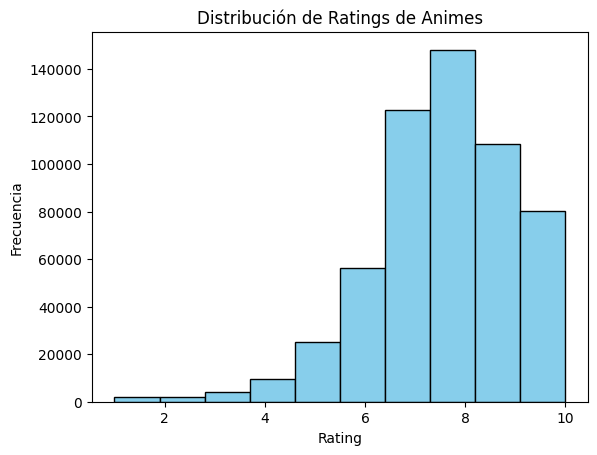

In [19]:
plt.hist(users_df.values.flatten(), bins=10, color="skyblue", edgecolor="black")
plt.title("Distribución de Ratings de Animes")
plt.xlabel("Rating")
plt.ylabel("Frecuencia")
plt.show()

In [20]:
# Obtenemos un DataFrame unidimensional con el número visualizaciones por anime
visualizaciones_anime = users_df.notnull().sum(axis=1)

In [21]:
print("Máximas visualizaciones de un anime:", visualizaciones_anime.max())
print("Mínimas visualizaciones de un anime:", visualizaciones_anime.min())

Máximas visualizaciones de un anime: 3231
Mínimas visualizaciones de un anime: 1


In [22]:
# Obtenemos un DataFrame unidimensional con el promedio de calificaciones por anime
promedio_calificaciones = users_df.mean(axis=1, skipna=True)
print("Máximo promedio de calificaciones de un anime:", promedio_calificaciones.max())
print("Mínimo promedio de calificaciones de un anime:", promedio_calificaciones.min())

Máximo promedio de calificaciones de un anime: 10.0
Mínimo promedio de calificaciones de un anime: 1.0


In [23]:
# Obtenemos un DataFrame unidimensional con la desviación estándar de calificaciones de cada anime
dispersion_calificaciones = users_df.sparse.to_dense().std(axis=1, skipna=True)
print(
    "Máximo nivel de dispersión de calificaciones de un anime:",
    dispersion_calificaciones.max(),
)
print(
    "Mínimo nivel de dispersión de calificaciones de un anime:",
    dispersion_calificaciones.min(),
)

Máximo nivel de dispersión de calificaciones de un anime: 6.363961
Mínimo nivel de dispersión de calificaciones de un anime: 0.0


In [24]:
# Ecuacion para obtener una escala logaritmica entre [1, 3231] y [1, 10]
# Resolver esto con una calculadora, es tomar la cuarta raiz

# x**4 == 3231
# x == 7.53935580567
log_vis = 7.53935580567

# Para los otros no vale mucho la pena el hacer una escala logaritmica, por el bajo rango.

In [25]:
# Teniendo los máximos y minimos de cada medida, podemos establecer un rango para la posterior
# segmentación del conjunto de datos.
rango_visualizaciones_anime = [
    1,
    round(log_vis),
    round(log_vis**2),
    round(log_vis**3),
    3231,
]
rango_promedio_calificaciones = [1, 5, 7, 10]
rango_dispersion_calificaciones = [0, 2, 4, 6.5]

In [26]:
segmentos_df = pd.DataFrame(index=users_df.index)

# Creamos columnas de segmentación
users_df["Nivel_Popularidad"] = pd.cut(
    visualizaciones_anime,
    bins=rango_visualizaciones_anime,
    labels=["Poco", "Moderado", "Bastante", "Mucho"],
)
users_df["Nivel_Prom_Calificaciones"] = pd.cut(
    promedio_calificaciones,
    bins=rango_promedio_calificaciones,
    labels=["Bajo", "Medio", "Alto"],
)
users_df["Nivel_Dispersion_Calificaciones"] = pd.cut(
    dispersion_calificaciones,
    bins=rango_dispersion_calificaciones,
    labels=["Baja", "Media", "Alta"],
)

In [27]:
users_df = pd.concat([users_df, segmentos_df], axis=1)

In [28]:
users_df[
    [
        "Nivel_Popularidad",
        "Nivel_Prom_Calificaciones",
        "Nivel_Dispersion_Calificaciones",
    ]
].head()

Nivel_Popularidad Nivel_Prom_Calificaciones  \
title                                                                    
School Rumble                       Bastante                      Alto   
Mahoraba: Heartful days             Moderado                      Alto   
School Rumble Ni Gakki              Bastante                      Alto   
Suzumiya Haruhi no Yuuutsu             Mucho                      Alto   
Kanon (2006)                        Bastante                      Alto   

                           Nivel_Dispersion_Calificaciones  
title                                                       
School Rumble                                         Baja  
Mahoraba: Heartful days                               Baja  
School Rumble Ni Gakki                                Baja  
Suzumiya Haruhi no Yuuutsu                            Baja  
Kanon (2006)                                          Baja

C:\Users\vamar\AppData\Local\Temp\ipykernel_10692\2495436210.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="Nivel_Popularidad", data=users_df, palette="viridis")


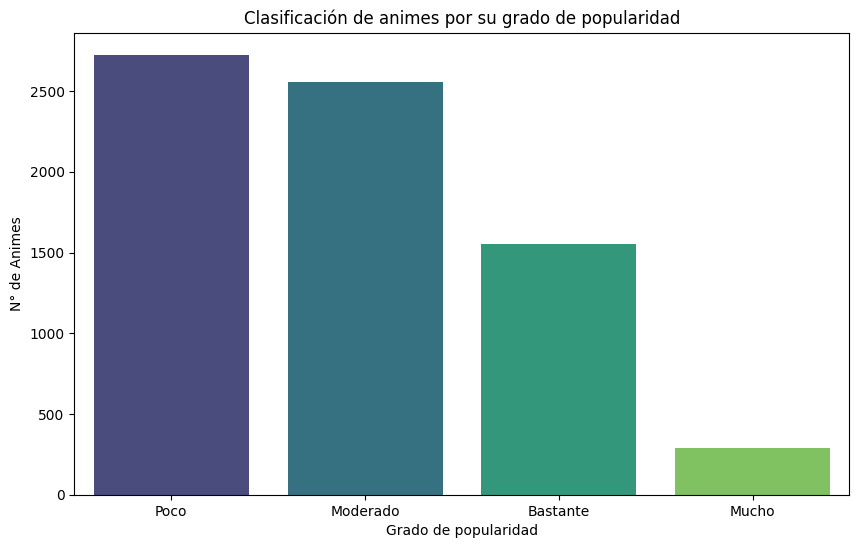

In [29]:
# Gráfico de barras para clasificar los animes en base a su popularidad
plt.figure(figsize=(10, 6))
sns.countplot(x="Nivel_Popularidad", data=users_df, palette="viridis")
plt.title("Clasificación de animes por su grado de popularidad")
plt.xlabel("Grado de popularidad")
plt.ylabel("N° de Animes")
plt.show()

Esta gráfica muestra como la mayor parte de los animes de la muestra tomada de MAL tienen poca o
moderada visualización, y solo una ínfima parte posee un grado de popularidad alto, sin embargo,
cabe aclarar que cuando el gráfico se refiere a grado de popularidad, esta popularidad hace
referencia a la 'fama' o la visualización de un anime, no se basa en conjunto con las
calificaciones de cada usuario.
####
####

C:\Users\vamar\AppData\Local\Temp\ipykernel_10692\2770799840.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="Nivel_Prom_Calificaciones", data=users_df, palette="viridis")


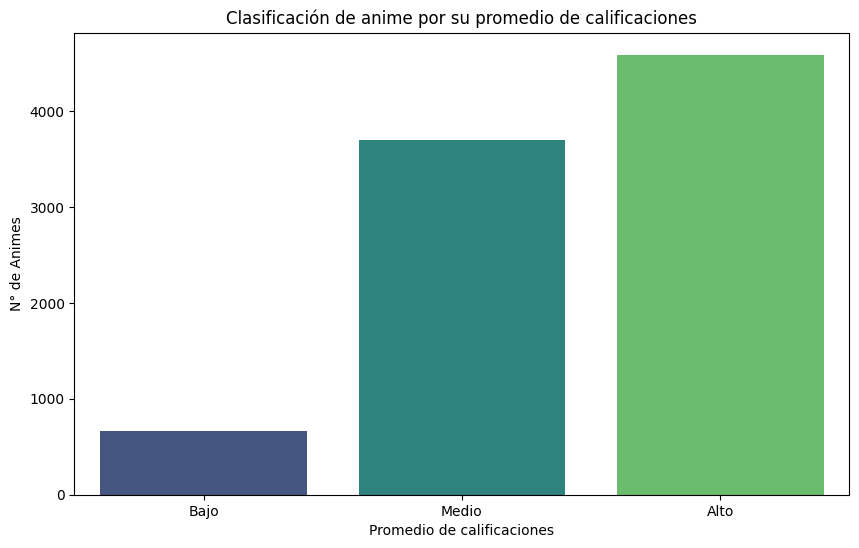

In [30]:
# Gráfico de barras para clasificar los animes en base a su grado de calificaciones
plt.figure(figsize=(10, 6))
sns.countplot(x="Nivel_Prom_Calificaciones", data=users_df, palette="viridis")
plt.title("Clasificación de anime por su promedio de calificaciones")
plt.xlabel("Promedio de calificaciones")
plt.ylabel("N° de Animes")
plt.show()

En un primer vistazo, podría parecer que esta gráfica carece de coherencia. ¿Cómo es posible que tantos animes obtengan calificaciones tan elevadas cuando la gráfica anterior indicaba que muy pocos eran visualizados por los usuarios? No obstante, debemos tener en cuenta que esta gráfica se basa exclusivamente en las calificaciones otorgadas por los usuarios a cada anime. Una parte significativa de ese extenso conjunto de animes con baja popularidad en la gráfica anterior puede trasladarse al grupo de aquellos con un alto promedio de calificaciones. Esto se debe a que, al tener menos revisiones, cada una de estas puede provocar un cambio significativo en el promedio de calificaciones del anime.
####

C:\Users\vamar\AppData\Local\Temp\ipykernel_10692\3505039400.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="Nivel_Dispersion_Calificaciones", data=users_df, palette="viridis")


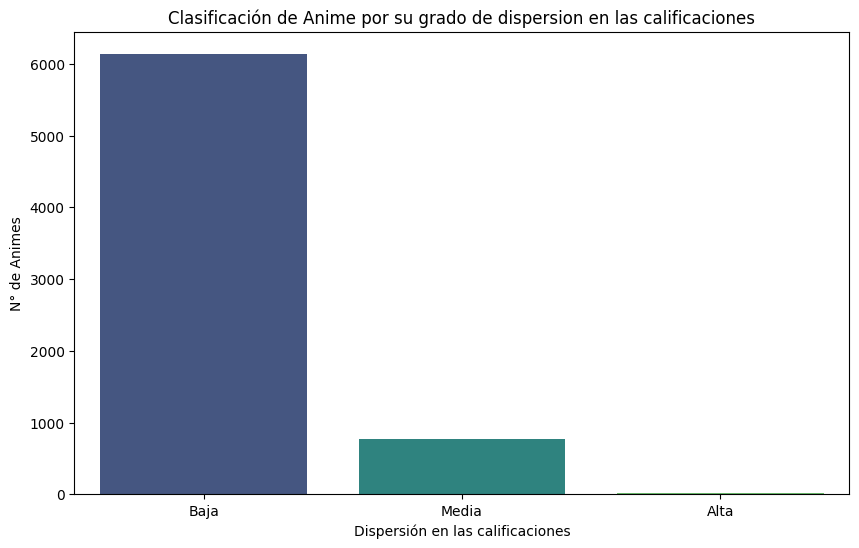

In [31]:
# Gráfico de barras para clasificar los animes en base a su grado de calificaciones
plt.figure(figsize=(10, 6))
sns.countplot(x="Nivel_Dispersion_Calificaciones", data=users_df, palette="viridis")
plt.title("Clasificación de Anime por su grado de dispersion en las calificaciones")
plt.xlabel("Dispersión en las calificaciones")
plt.ylabel("N° de Animes")
plt.show()

Este gráfico, al mostrar que la mayoría de los animes tienen un bajo grado de dispersión en torno a sus calificaciones, sugiere una consistencia en las evaluaciones. Esto implica que los espectadores tienden a estar de acuerdo en sus opiniones sobre estos animes. Además, la baja dispersión indica una menor polarización entre los usuarios, lo que significa que hay menos variabilidad en las opiniones de la audiencia. Esta uniformidad podría deberse a que la audiencia comparte opiniones más similares sobre estos animes en comparación con otros que podrían generar opiniones más polarizadas.

Sin embargo, es importante señalar que es inusual observar una baja dispersión al mismo tiempo que hay una baja cantidad de calificaciones por anime, sin que esto afecte la dispersión. Este fenómeno podría atribuirse a varios factores, como la falta de diversidad en la audiencia o un sesgo en la misma. Es decir, la audiencia podría tener preferencias similares o específicas que resultan en calificaciones más consistentes.
####
####

#### ¿Se cumple la ley de Pareto con las calificaciones de Anime?

La ley de Pareto dice que el 80% de los efectos proviene del 20% de las causas.

En nuestro caso, la ley de Pareto diría que el 20% de los usuarios hace 80% de las calificaciones, o que el 20% de los anime tienen el 80% de las calificaciones.

Se mostrarán unos graficos comparando en cantidad decreciente una cantidad, para ver si se puede encontrar el patrón de Pareto.

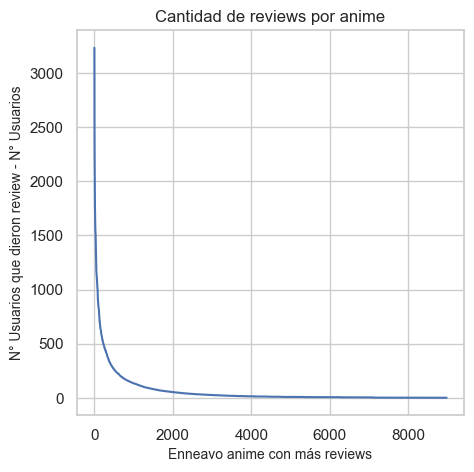

In [141]:
# Parcialmente inspirado en:
# https://stackoverflow.com/questions/45909776/sort-rows-of-a-dataframe-in-descending-order-of-nan-counts
serie_null = users_df.isnull().sum(axis=1).mul(-1)
serie_null.sort_values(ascending=False, inplace=True)
serie_null.reset_index(drop=True, inplace=True)
serie_null = serie_null.apply(lambda x: x + len(users_df.columns))
plt.figure(figsize=(5, 5))
plt.plot(serie_null)
plt.title("Cantidad de reviews por anime")
plt.xlabel(
    "Enneavo anime con más reviews",  # Añade etiquetas para las coordenadas
    fontdict={"fontsize": 10},
)
plt.ylabel("N° Usuarios que dieron review - N° Usuarios", fontdict={"fontsize": 10})

# Guardamos el gráfico en formato png

plt.savefig(os.path.join("img", "reviews_por_anime.png"), dpi=300)

In [39]:
porciento_20 = round(len(serie_null) * 0.2)

big_anime, mini_anime = serie_null[:porciento_20].sum(), serie_null[porciento_20:].sum()
total_anime = serie_null.sum()

print(
    f"El 20% de los anime tiene {big_anime} calificaciones, lo cual es un {round(big_anime/total_anime*100, 2)}% del total"
)

print(
    f"El 20% de los anime tiene {mini_anime} calificaciones, lo cual es un {round(mini_anime/total_anime*100, 2)}% del total"
)

El 20% de los anime tiene 485115 calificaciones, lo cual es un 83.49% del total
El 20% de los anime tiene 95931 calificaciones, lo cual es un 16.51% del total


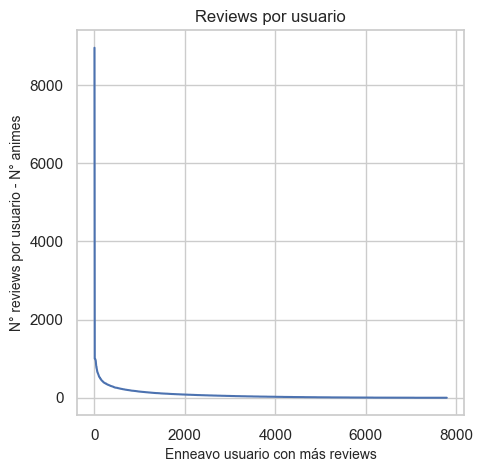

In [142]:
# Parcialmente inspirado en:
# https://stackoverflow.com/questions/45909776/sort-rows-of-a-dataframe-in-descending-order-of-nan-counts
serie_null = users_df.isnull().sum(axis=0).mul(-1)
serie_null.sort_values(ascending=False, inplace=True)
serie_null.reset_index(drop=True, inplace=True)
serie_null = serie_null.apply(lambda x: x + len(users_df))
plt.figure(figsize=(5, 5))
plt.plot(serie_null)
plt.title("Reviews por usuario")
plt.xlabel(
    "Enneavo usuario con más reviews",  # Añade etiquetas para las coordenadas
    fontdict={"fontsize": 10},
)
plt.ylabel("N° reviews por usuario - N° animes", fontdict={"fontsize": 10})

# Guardamos el gráfico en formato png

plt.savefig(os.path.join("img", "reviews_por_usuario.png"), dpi=300)

In [41]:
porciento_20 = round(len(serie_null) * 0.2)

super_user, mini_user = serie_null[:porciento_20].sum(), serie_null[porciento_20:].sum()
total_user = serie_null.sum()

print(
    f"El 20% de los usuarios tiene {super_user} calificaciones, lo cual es un {round(super_user/total_user*100, 2)}% del total"
)

print(
    f"El 20% de los usuarios tiene {mini_user} calificaciones, lo cual es un {round(mini_user/total_user*100, 2)}% del total"
)

El 20% de los usuarios tiene 410675 calificaciones, lo cual es un 70.68% del total
El 20% de los usuarios tiene 170371 calificaciones, lo cual es un 29.32% del total


Como se puede ver, aunque no es exactamente 80%, es bastante cercano por ambos lados; los gráficos también siguen una distribucion de pareto, la cual se caracteriza por aproximarse a una funcion racional.

Es decir, sí, nuestros datos siguen una distribución de Pareto, y también la ley de Pareto.

#### ¿Cuál es la desviación estandar por usuario?

In [53]:
# Eliminamos las columnas que no nos interesan, provisionalmente.

users_df_std = users_df.drop(
    [
        "Nivel_Popularidad",
        "Nivel_Prom_Calificaciones",
        "Nivel_Dispersion_Calificaciones",
    ],
    axis=1,
)

std_por_columna = users_df_std.apply(lambda x: x.sparse.to_dense().std())
df_std = pd.DataFrame({"Desviación Estándar": std_por_columna})

In [54]:
df_std.head()

Desviación Estándar
39110:xxbladexx20             0.991377
216949:haijuta                0.500000
246587:d3athzero              1.223691
107198:JayJay1401             1.310295
45036:Seleare                      NaN

Se crea un dataframe que contiene el valor de la desviación estándar de las calificaciones que
tiene cada usuario en su lista de anime. 

In [55]:
df_std["Indice"] = range(len(df_std))
df_std.set_index("Indice", inplace=True)

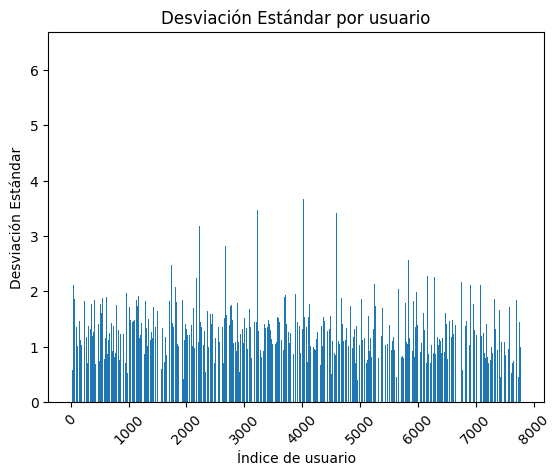

In [56]:
plt.bar(df_std.index, df_std["Desviación Estándar"])
plt.xlabel("Índice de usuario")
plt.ylabel("Desviación Estándar")
plt.title("Desviación Estándar por usuario")
plt.xticks(rotation=45)
plt.show()

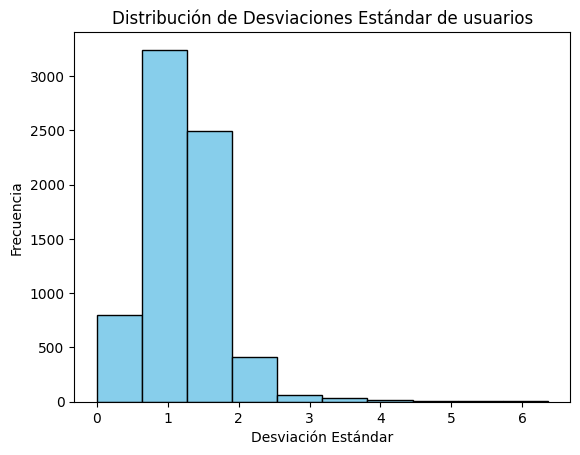

In [57]:
# Mostrar lo mismo previo pero con un histograma

plt.hist(df_std["Desviación Estándar"], color="skyblue", edgecolor="black")
plt.title("Distribución de Desviaciones Estándar de usuarios")
plt.xlabel("Desviación Estándar")
plt.ylabel("Frecuencia")
plt.show()

### En Dataframe 2: `unified_df.csv`

#### Colocar los tags de mejor forma en el dataframe

In [451]:
# Convertir los posibles valores NaN de Tags a "" (caso hipótetico)

unified_df["Tags"] = unified_df["Tags"].fillna("")

In [452]:
# Será conveniente renombrar MAL_ID a id para poder hacer un merge con el dataframe de
# detalles_animes

unified_df = unified_df.rename(columns={"MAL_ID": "id"})

Para obtener los tags, lo que se pensó fue primeramente obtener un conjunto con todos los tags
existentes. Luego, se colocaría un 1 en cada tag que tuviera el anime, y un 0 en los que no. Así,
se puede trabajar más eficientemente con los tags y dar cuenta de si un anime presenta un tag o no. 

In [453]:
# Obtener todos los tags únicos en el DataFrame

unified_df["Tags"] = unified_df["Tags"].apply(
    lambda x: [x.strip("'") for x in x.lstrip("[").rstrip("]").split(", ")]
)

all_tags = set(unified_df["Tags"].explode())
all_tags.remove("")
all_tags

{'10th Century',
 '11th Century',
 '12th Century',
 '13th Century',
 '14th Century',
 '15th Century',
 '16th Century',
 '17th Century',
 '18th Century',
 '19th Century',
 '1st Century',
 '2nd Century',
 '3rd Century',
 '6th Century',
 '8th Century',
 '9th Century',
 'Abstract',
 'Acting',
 'Action',
 'Adult Couples',
 'Adventure',
 'Africa',
 'Afterlife',
 'Age Gap',
 'Age Transformation',
 'Aging',
 'Agriculture',
 'Alcohol',
 'Alice in Wonderland',
 'Aliens',
 'All-Boys School',
 'All-Girls School',
 'America',
 'Amnesia',
 'Amusement Park',
 'Ancient China',
 'Androids',
 'Androphobia',
 'Angels',
 'Animal Abuse',
 'Animal Characteristics',
 'Animal Protagonists',
 'Animal Transformation',
 'Anime Bancho',
 'Anime Industry',
 'Anime Tamago',
 'Anime no Chikara',
 'Anime no Me',
 'Animeism',
 'Antarctica',
 'Anthropomorphic',
 'Antique Shop',
 'Apartment Life',
 'Apocalypse',
 'Apprenticeship',
 'Aquarium',
 'Archery',
 'Arranged Marriage',
 'Art',
 'Art School',
 'Assassins',
 'Astr

In [454]:
# Actualización del dataframe con los tags

for tag in all_tags:
    unified_df[tag] = unified_df["Tags"].apply(lambda x: 1 if tag in x else 0)


C:\Users\mativ\AppData\Local\Temp\ipykernel_39844\3530142915.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  unified_df[tag] = unified_df["Tags"].apply(lambda x: 1 if tag in x else 0)
C:\Users\mativ\AppData\Local\Temp\ipykernel_39844\3530142915.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  unified_df[tag] = unified_df["Tags"].apply(lambda x: 1 if tag in x else 0)
C:\Users\mativ\AppData\Local\Temp\ipykernel_39844\3530142915.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling 

In [455]:
# Por conveniencia, lo más útil es eliminar la columna "URL", junto a "Tags" y "Alts", que ya no
# sirven de nada. Además se establece la columna "MAL_ID" como índice.

unified_df = unified_df.drop(columns=["URL", "Tags", "Alts", "Anime"]).set_index("id")

In [456]:
# El MAL_ID de índice puede conectarse con los datos de detalles_animes, que también tienen MAL_ID,
# y así se puede obtener que el índice sea el title de cada anime, que es más útil y fácil de
# visualizar.

unified_df = unified_df.join(detalles_animes.set_index("id")["title"])

In [457]:
# Cambio de índice a title, eliminación del índice actual igualmente.

unified_df = unified_df.set_index("title")

In [458]:
# Por temas de memoria principalmente, es conveniente hacer el dataframe sparse.

unified_df = unified_df.astype(pd.SparseDtype(np.int8, fill_value=0))

In [459]:
unified_df

Roommates  Hosts  \
title                                                                  
"0"                                                         0      0   
"Bungaku Shoujo" Kyou no Oyatsu: Hatsukoi                   0      0   
"Bungaku Shoujo" Memoire                                    0      0   
"Bungaku Shoujo" Movie                                      0      0   
"Eiji"                                                      0      0   
...                                                       ...    ...   
Zuori Qing Kong                                             0      0   
Zurui Maboroshi                                             0      0   
Zutto Mae kara Suki deshita. Kokuhaku Jikkou Ii...          0      0   
Zutto Mae kara Suki deshita. Kokuhaku Jikkou Ii...          0      0   
ēlDLIVE                                                     0      0   

                                                    Criminals  Afterlife  \
title                                                                      
"0"                                                         0          0   
"Bungaku Shoujo" Kyou no Oyatsu: Hatsukoi                   0          0   
"Bungaku Shoujo" Memoire                                    0          0   
"Bungaku Shoujo" Movie                                      0          0   
"Eiji"                                                      0          0   
...                                                       ...        ...   
Zuori Qing Kong                                             0          0   
Zurui Maboroshi                                             0          0   
Zutto Mae kara Suki deshita. Kokuhaku Jikkou Ii...          0          0   
Zutto Mae kara Suki deshita. Kokuhaku Jikkou Ii...          0          0   
ēlDLIVE                                                     0          0   

                                                    French Revolution  \
title                                                                   
"0"                                                                 0   
"Bungaku Shoujo" Kyou no Oyatsu: Hatsukoi                           0   
"Bungaku Shoujo" Memoire                                            0   
"Bungaku Shoujo" Movie                                              0   
"Eiji"                                                              0   
...                                                               ...   
Zuori Qing Kong                                                     0   
Zurui Maboroshi                                                     0   
Zutto Mae kara Suki deshita. Kokuhaku Jikkou Ii...                  0   
Zutto Mae kara Suki deshita. Kokuhaku Jikkou Ii...                  0   
ēlDLIVE                                                             0   

                                                    Pet Shop  Okinawa  \
title                                                                   
"0"                                                        0        0   
"Bungaku Shoujo" Kyou no Oyatsu: Hatsukoi                  0        0   
"Bungaku Shoujo" Memoire                                   0        0   
"Bungaku Shoujo" Movie                                     0        0   
"Eiji"                                                     0        0   
...                                                      ...      ...   
Zuori Qing Kong                                            0        0   
Zurui Maboroshi                                            0        0   
Zutto Mae kara Suki deshita. Kokuhaku Jikkou Ii...         0        0   
Zutto Mae kara Suki deshita. Kokuhaku Jikkou Ii...         0        0   
ēlDLIVE                                                    0        0   

                                                    13th Century  \
title                                                              
"0"                                                            0   
"Bungaku Shoujo" Kyou 

In [460]:
unified_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8772 entries, "0" to ēlDLIVE
Columns: 583 entries, Roommates to Gangs
dtypes: Sparse[int8, 0](583)
memory usage: 348.4+ KB


#### Análisis exploratorio del dataframe de tags (sin gráficos)

In [461]:
# En primer lugar, notar que tenemos la siguiente cantidad de tags:

len(unified_df.columns)

583

In [217]:
# Para ver duplicados, usar el método duplicated(); luego las organizamos para que se vea mejor que
# los datos efecticamente están duplicados. Consideramos duplicados solamente si tienen el mismo
# índice, es decir, que son el mismo anime. Si no, no tiene sentido considerarlos duplicados.

duplicated_animes = unified_df[unified_df.index.duplicated(keep=False)].sort_index()

# Verificamos que efectivamente son duplicados

duplicated_animes

Empty DataFrame
Columns: [Roommates, Hosts, Criminals, Afterlife, French Revolution, Pet Shop, Okinawa, 13th Century, Slice of Life, Outer Space, Mystery, Hell, Scuba Diving, Mysterious Benefactor, Ocean, Wuxia, Jungle, Pigs, High Stakes Games, Dodgeball, Coming of Age, Time Travel, Christmas, Catholic School, Revenge, Lawyers, Forest, Illness, School Life, Zombies, Management, Apocalypse, Reverse Harem, God-Human Relationship, Anime Tamago, Royalty, Landlords, Based on a 4-Koma Manga, LGBT Themes, Astronomy, Cheerleaders, Picture Drama, Combining Mecha, Historical, Explicit Violence, Anime no Me, Tokusatsu, Isolated Society, Mansion, Delinquents, Acting, Social Media, India, Stop Motion Animation, Library, Anime Bancho, Androids, Motorcycles, Kidnapping, Robots, Romance of the Three Kingdoms, Horror, Gender Identity, Recipes, MMORPG, Cafe, Mexico, Anthropomorphic, Wolves, Seinen, Prison, All-Girls School, Ancient China, Basketball, Super Robot, Cars, Framed for a Crime, Elves, 9th Century, Virtual Reality, Transfer Students, Demons, Pole Dancing, POV, Editors, Play or Die, Japanese Mythology, Dancing, Slapstick, Samurai, Crude, Conspiracy, Mind Games, Contemporary Fantasy, All-Boys School, Work Life, 14th Century, Martial Arts School, Frogs, Pregnancy, ...]
Index: []

[0 rows x 583 columns]

In [218]:
# Eliminar los duplicados, utilizando el método drop_duplicates(), inplace=True para que se haga el
# cambio. Consideramos para la deleción solamente los duplicados que tienen el mismo índice, es
# decir, que son el mismo anime. Si no, no tiene sentido considerarlos duplicados.

# Encuentra los índices de las filas duplicadas basándote en el índice (anime)
duplicated_indices = unified_df[unified_df.index.duplicated()].index

# Elimina las filas duplicadas utilizando los índices
unified_df.drop(index=duplicated_indices, inplace=True)

In [219]:
unified_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8772 entries, "0" to ēlDLIVE
Columns: 583 entries, Roommates to Gangs
dtypes: Sparse[int32, 0](583)
memory usage: 516.2+ KB


Como ya se trabajó previamente, los tipos de datos son los pertinentes. Además, efectivamente el
nombre de cada columna del dataframe logra ser idóneo, pues se entiende que cada columna representa
el nombre de un tag existente en Anime-Planet. Debido al trabajo ya realizado en el dataframe, se
ve que es inútil comprobar la existencia de valores nulos. 

Por otro lado, se comprueba efectivamente la ventaja de que el dataframe sea sparse, pues tiene un uso en memoria relativamente
bajo para la cantidad de datos que contiene.

In [220]:
# Promedio de los tags

unified_df.mean().sort_values(ascending=False)

Based on a Manga    0.371295
Action              0.306886
Comedy              0.306430
Fantasy             0.226288
Sci Fi              0.194482
                      ...   
Antique Shop        0.000114
Centaurs            0.000114
Belgium             0.000114
Dodgeball           0.000114
Dentists            0.000114
Length: 583, dtype: float64

In [221]:
# ¿Cuál es el tag menos común? ¿Cuántos animes tienen ese tag?

unified_df.sum().sort_values(ascending=True)

Sheep                  1
Hockey                 1
Belgium                1
Gynophobia             1
Mexico                 1
                    ... 
Sci Fi              1706
Fantasy             1985
Comedy              2688
Action              2692
Based on a Manga    3257
Length: 583, dtype: int32

In [222]:
print(f"El tag menos común es {unified_df.sum().sort_values(ascending=True).index[0]}")

# ¿Existen más tags que aparecen dicha cantidad de veces exactamente?

print(
    f"Existen {len(unified_df.sum().sort_values(ascending=True)[unified_df.sum().sort_values(ascending=True) == 1])} tags que aparecen {unified_df.sum().sort_values(ascending=True)[0]} veces, específicamente, sus nombres son los siguientes:"
)

for tag in (
    unified_df.sum()
    .sort_values(ascending=True)[unified_df.sum().sort_values(ascending=True) == 1]
    .index
):
    print(f"\t{tag}")

El tag menos común es Sheep
Existen 27 tags que aparecen 1 veces, específicamente, sus nombres son los siguientes:
	Sheep
	Hockey
	Belgium
	Gynophobia
	Mexico
	Poland
	Japan Animator
	9th Century
	12th Century
	Flower Shop
	10th Century
	Centaurs
	Surfing
	Unicorns
	Antique Shop
	1st Century
	Dentists
	Orphanage
	Disney
	Tibet
	3rd Century
	Water Polo
	Thailand
	BDSM
	Dodgeball
	Hosts
	13th Century


In [223]:
# ¿Cuál es el tag más común? ¿Cuántos animes tienen ese tag?

unified_df.sum().sort_values(ascending=False)

Based on a Manga    3257
Action              2692
Comedy              2688
Fantasy             1985
Sci Fi              1706
                    ... 
Antique Shop           1
Centaurs               1
Belgium                1
Dodgeball              1
Dentists               1
Length: 583, dtype: int32

In [224]:
print(f"El tag más común es {unified_df.sum().sort_values(ascending=False).index[0]}")

# Obtén el número de veces que aparece el tag más común
max_tag_count = unified_df.sum().max()

# ¿Existen más tags que solo aparecen la misma cantidad de veces que el tag más común?
count_same_as_max = (unified_df.sum() == max_tag_count).sum()
print(
    f"Existen {count_same_as_max} tags que aparecen {max_tag_count} veces. Sus nombres son los siguientes:"
)

# Imprime los nombres de los tags que aparecen la misma cantidad de veces que el tag más común
for tag in unified_df.columns[unified_df.sum() == max_tag_count]:
    print(f"\t{tag}")

El tag más común es Based on a Manga
Existen 1 tags que aparecen 3257 veces. Sus nombres son los siguientes:
	Based on a Manga


El tag más común tiene sentido, pues es cierto que una porción considerable de los animes son
adaptaciones de mangas, y por ende es natural que el tag de manga sea el más común. Es coherente
con la realidad.

In [226]:
# ¿Cuál es el anime con más tags de todos? ¿Cuántos tags tiene?

unified_df.sum(axis=1).sort_values(ascending=False)

title
Monster                                   27
Tian Guan Cifu                            25
Happy Sugar Life                          24
Made in Abyss: Retsujitsu no Ougonkyou    22
Tensei shitara Slime Datta Ken            22
                                          ..
Bakuretsu Tenshi: Infinity Special         0
Rio: Rainbow Gate! Special                 0
Kumorizora no Mukou wa Hareteiru           0
Reunion (Music)                            0
"0"                                        0
Length: 8772, dtype: int32

In [227]:
max_tags_anime_index = unified_df.sum(axis=1).idxmax()
max_tags_anime_count = unified_df.sum(axis=1).max()

print(
    f"El anime con más tags es {max_tags_anime_index}, con {max_tags_anime_count} tags."
)

# ¿Existen más animes que tienen la misma cantidad de tags que el anime con más tags?
same_tags_anime_indices = unified_df.index[
    unified_df.sum(axis=1) == max_tags_anime_count
]
same_tags_anime_count = len(same_tags_anime_indices)

print(
    f"Existen {same_tags_anime_count} animes que tienen {max_tags_anime_count} tags. Sus nombres son los siguientes:"
)
for anime in same_tags_anime_indices:
    print(f"\t{anime}")

El anime con más tags es Monster, con 27 tags.
Existen 1 animes que tienen 27 tags. Sus nombres son los siguientes:
	Monster


In [228]:
# ¿Cuál es el anime con menos tags de todos? ¿Cuántos tags tiene?

unified_df.sum(axis=1).sort_values(ascending=True)

title
"0"                                                              0
Mai no Mahou to Katei no Hi                                      0
Ai Uta: Since 2007                                               0
Tennis no Oujisama: The Band of Princes Film Kick the Future     0
Lilac                                                            0
                                                                ..
Made in Abyss: Retsujitsu no Ougonkyou                          22
Tensei shitara Slime Datta Ken                                  22
Happy Sugar Life                                                24
Tian Guan Cifu                                                  25
Monster                                                         27
Length: 8772, dtype: int32

In [229]:
min_tags_anime_index = unified_df.sum(axis=1).idxmin()
min_tags_anime_count = unified_df.sum(axis=1).min()

print(
    f"El anime con menos tags es {min_tags_anime_index}, con {min_tags_anime_count} tags."
)

# ¿Existen más animes que tienen la misma cantidad de tags que el anime con menos tags?
same_tags_anime_indices = unified_df.index[
    unified_df.sum(axis=1) == min_tags_anime_count
]
same_tags_anime_count = len(same_tags_anime_indices)

print(
    f"Existen {same_tags_anime_count} animes que tienen {min_tags_anime_count} tags. Sus nombres son los siguientes:"
)
for anime in same_tags_anime_indices:
    print(f"\t{anime}")

El anime con menos tags es "0", con 0 tags.
Existen 91 animes que tienen 0 tags. Sus nombres son los siguientes:
	"0"
	.hack//Quantum: Sore ike! Bokura no Chimuchimu-chan!!
	.hack//Versus: The Thanatos Report
	1000-mankai Hug Nanda
	1989
	Ai Uta: Since 2007
	Aitsura Zenin Dousoukai
	Akuma no Organ
	Atarashii Sekai
	Baka ja Nai no ni
	Baka to Test to Shoukanjuu: Matsuri - Sentakushi Ikou nomi
	Bakuretsu Tenshi: Infinity Special
	Bremen
	Busou Renkin: Mahiro no Busou Renkin Kouza
	COLORs
	Daaijobu da yo
	Dear. Mr "F"
	Decadence: Remix
	Drop
	Gift: Eternal Rainbow - Ki no Saka Ryokan Kiki Ippatsu!!
	Good Day
	Gyakkou
	Hajimemashite no Kimochi wo
	Hakugin
	Halzion
	Heart Realize
	Hiiro no Kakera: Totsugeki! Tonari no Ikemenzu
	Hikenai Guitar wo Hikundaze
	Hyohakusha
	I Was King
	Idobata Gossip
	Just Awake
	Kami nomi Kakushi
	Kamiari Algorithm
	Kan Saete Kuyashii wa
	Kimi dake no Boku de Iru kara
	Kimi wa Tomodachi
	Kira Killer
	Kiss Dum: Omokage
	Koakuma datte Kamawanai!
	Kotonoha Breakdow

Esto último de animes con 0 tags parece ser que son animes a los cuales se les olvidó colocar algo. 

Muy probablemente sea porque son animes poco conocidos a los cuales no se les ha dado mucha
atención, lo que provoca que no se les coloque tags. 

Se revisó dichos animes en Anime-Planet y efectivamente no cuentan con tags, so no se puede hacer
nada al respecto para solventar aquello. 

In [230]:
# ¿Cuál es el promedio de cantidad de tags por anime?

unified_df.sum(axis=1).mean()

6.533059735522116

In [231]:
# ¿Cuál es la mediana de cantidad de tags por anime?

unified_df.sum(axis=1).median()

6.0

In [232]:
# ¿Cuál es la moda de cantidad de tags por anime?

unified_df.sum(axis=1).mode()

0    6
dtype: int32

In [233]:
# ¿Cuál es la desviación estándar de cantidad de tags por anime?

unified_df.sum(axis=1).std()

3.3138118637220284

Los estadísticos apuntan a una distribución más o menos normal, con una media, mediana y moda
similares, junto a una desviación estándar relativamente baja. 

#### Análisis exploratorio del dataframe de tags (con gráficos)

In [234]:
# ¿Cómo será la correlación entre los tags? ¿Será que hay tags que siempre aparecen juntos?

unified_df.corr()

Roommates     Hosts  Criminals  Afterlife  \
Roommates           1.000000 -0.000571  -0.004511  -0.002858   
Hosts              -0.000571  1.000000  -0.000901  -0.000571   
Criminals          -0.004511 -0.000901   1.000000  -0.004511   
Afterlife          -0.002858 -0.000571  -0.004511   1.000000   
French Revolution  -0.000807 -0.000161  -0.001274  -0.000807   
...                      ...       ...        ...        ...   
BDSM               -0.000571 -0.000114  -0.000901  -0.000571   
Fake Romance       -0.001979 -0.000395  -0.003123  -0.001979   
Dragon Quest       -0.001277 -0.000255  -0.002015  -0.001277   
10th Century       -0.000571 -0.000114  -0.000901  -0.000571   
Gangs              -0.004931 -0.000985   0.111248  -0.004931   

                   French Revolution  Pet Shop   Okinawa  13th Century  \
Roommates                  -0.000807 -0.000807 -0.001511     -0.000571   
Hosts                      -0.000161 -0.000161 -0.000302     -0.000114   
Criminals                  -0.001274 -0.001274 -0.002384     -0.000901   
Afterlife                  -0.000807 -0.000807 -0.001511     -0.000571   
French Revolution           1.000000 -0.000228 -0.000427     -0.000161   
...                              ...       ...       ...           ...   
BDSM                       -0.000161 -0.000161 -0.000302     -0.000114   
Fake Romance               -0.000559 -0.000559 -0.001046     -0.000395   
Dragon Quest               -0.000361 -0.000361 -0.000675     -0.000255   
10th Century               -0.000161 -0.000161 -0.000302     -0.000114   
Gangs                      -0.001393 -0.001393 -0.002607     -0.000985   

                   Slice of Life  Outer Space  ...  Self-Harm  Board Games  \
Roommates               0.135493    -0.008535  ...  -0.001894    -0.002915   
Hosts                  -0.003468    -0.001705  ...  -0.000378    -0.000582   
Criminals              -0.027402    -0.013469  ...  -0.002990    -0.004600   
Afterlife              -0.010084    -0.008535  ...  -0.001894    -0.002915   
French Revolution      -0.004905    -0.002411  ...  -0.000535    -0.000823   
...                          ...          ...  ...        ...          ...   
BDSM                   -0.003468    -0.001705  ...  -0.000378    -0.000582   
Fake Romance            0.008976    -0.005909  ...  -0.001311    -0.002018   
Dragon Quest           -0.007756    -0.003812  ...  -0.000846    -0.001302   
10th Century           -0.003468    -0.001705  ...  -0.000378    -0.000582   
Gangs                  -0.000258    -0.014725  ...  -0.003268     0.017900   

                   Penguins  Single Parent  Based on a Webtoon      BDSM  \
Roommates         -0.001806      -0.002060            0.130367 -0.000571   
Hosts             -0.000361      -0.000411           -0.000685 -0.000114   
Criminals         -0.002850      -0.003250           -0.005416 -0.000901   
Afterlife         -0.001806      -0.002060           -0.003432 -0.000571   
French Revolution -0.000510      -0.000582           -0.000969 -0.000161   
...                     ...            ...                 ...       ...   
BDSM              -0.000361      -0.000411           -0.000685  1.000000   
Fake Romance      -0.001250      -0.001426            0.045869 -0.000395   
Dragon Quest      -0.000807      -0.000920           -0.001533 -0.000255   
10th Century      -0.000361      -0.000411           -0.000685 -0.000114   
Gangs             -0.003116      -0.003553           -0.005921 -0.000985   

                   Fake Romance  Dragon Quest  10th Century     Gangs  
Roommates             -0.001979     -0.001277     -0.000571 -0.004931  
Hosts                 -0.000395     -0.000255     -0.000114 -0.000985  
Criminals             -0.003123     -0.002015     -0.000901  0.111248  
Afterlife             -0.001979     -0.001277     -0.000571 -0.004931  
French Revolution     -0.000559     -0.000361     -0.000161 -0.001393  
...                         ...           ...           ...       ...  
BDSM   

De reojo se observan muchas correlaciones negativas, pero muy insignificantes al ser muy cercanas a 0.

***Consideración***

Nótese ciertamente que los siguientes heatmap muy seguramente no muestren nada relevante, dado que no es muy probable que dentro de los tags aleatoriamente seleccionados exista la mínima correlación pedida. Por defecto, se comprendió que en este trabajo lo anterior se cumple.

Entonces, ¿por qué se muestran igualmente los gráficos? Ello es dado que, en primer lugar, corroboran ciertamente lo anterior señalado. En segunda instancia, dado que en nuestro trabajo la muestra no es de todos los animes de Anime-Planet, puede que los gráficos cambien notoriamente con una muestra mayor. 

Consideramos, por dichas razones, importante mantener el código de los gráficos, por lo viable que sería replicar este trabajo con una mayor cantidad de animes.

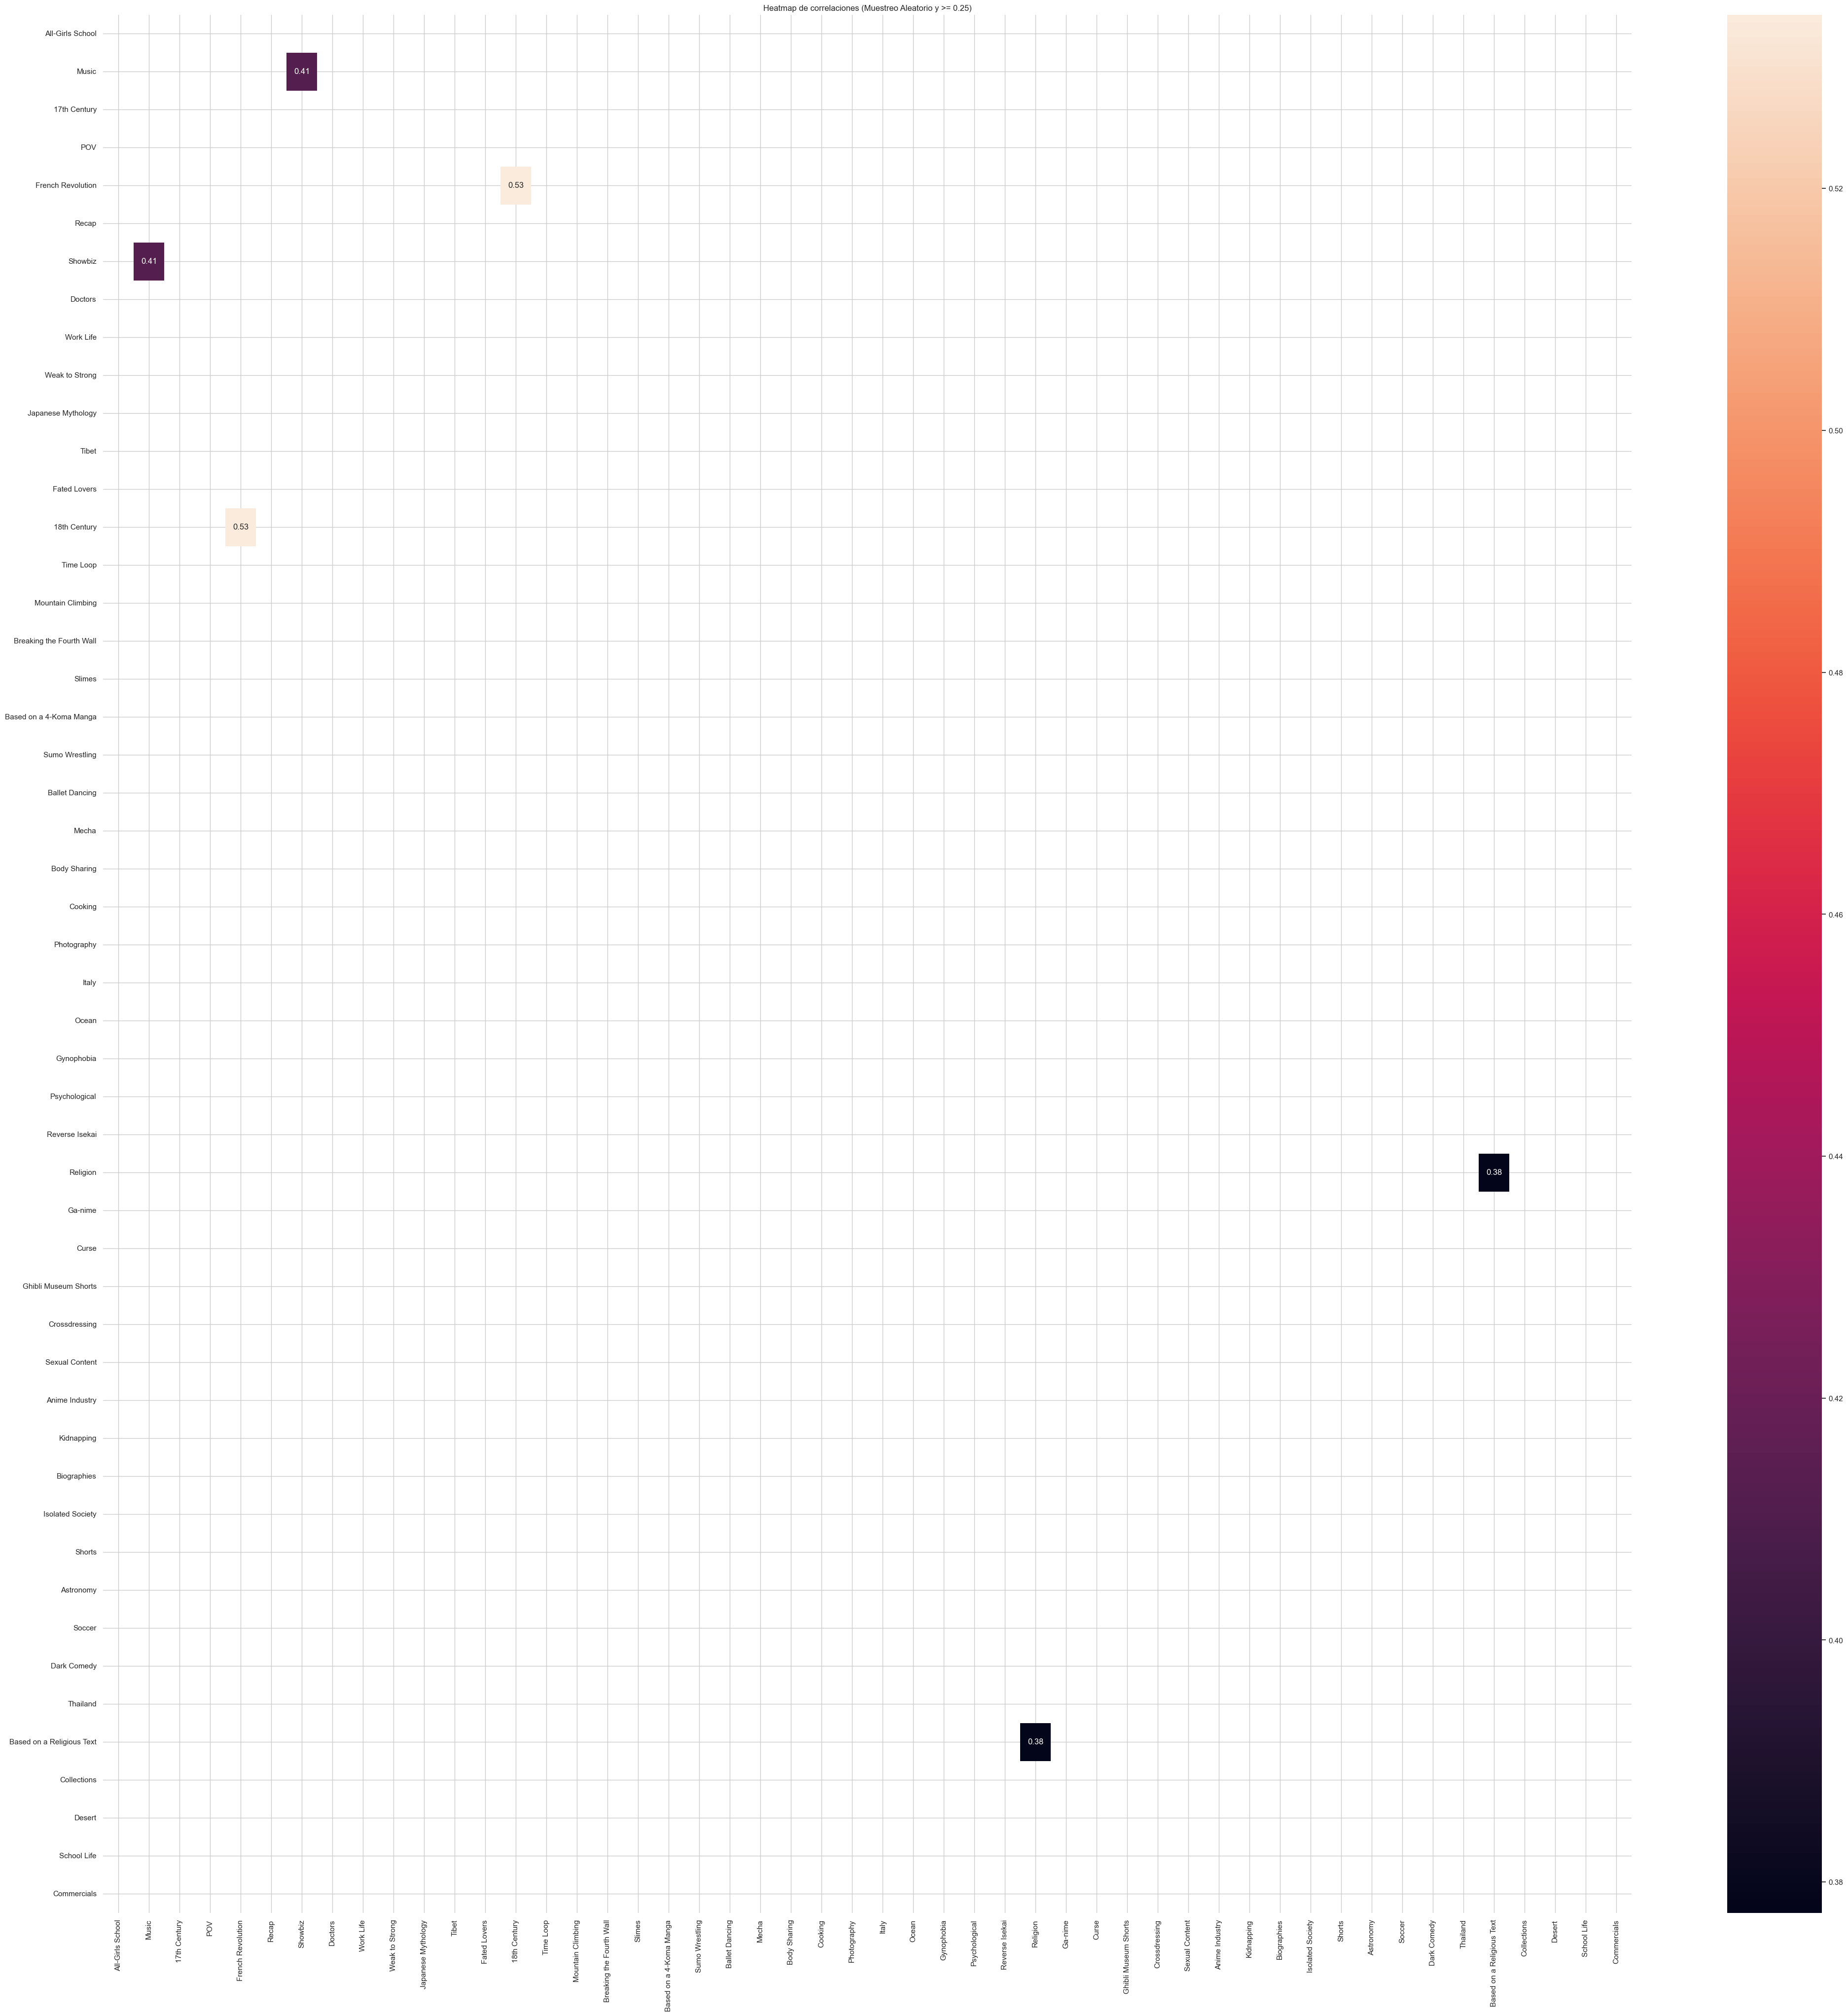

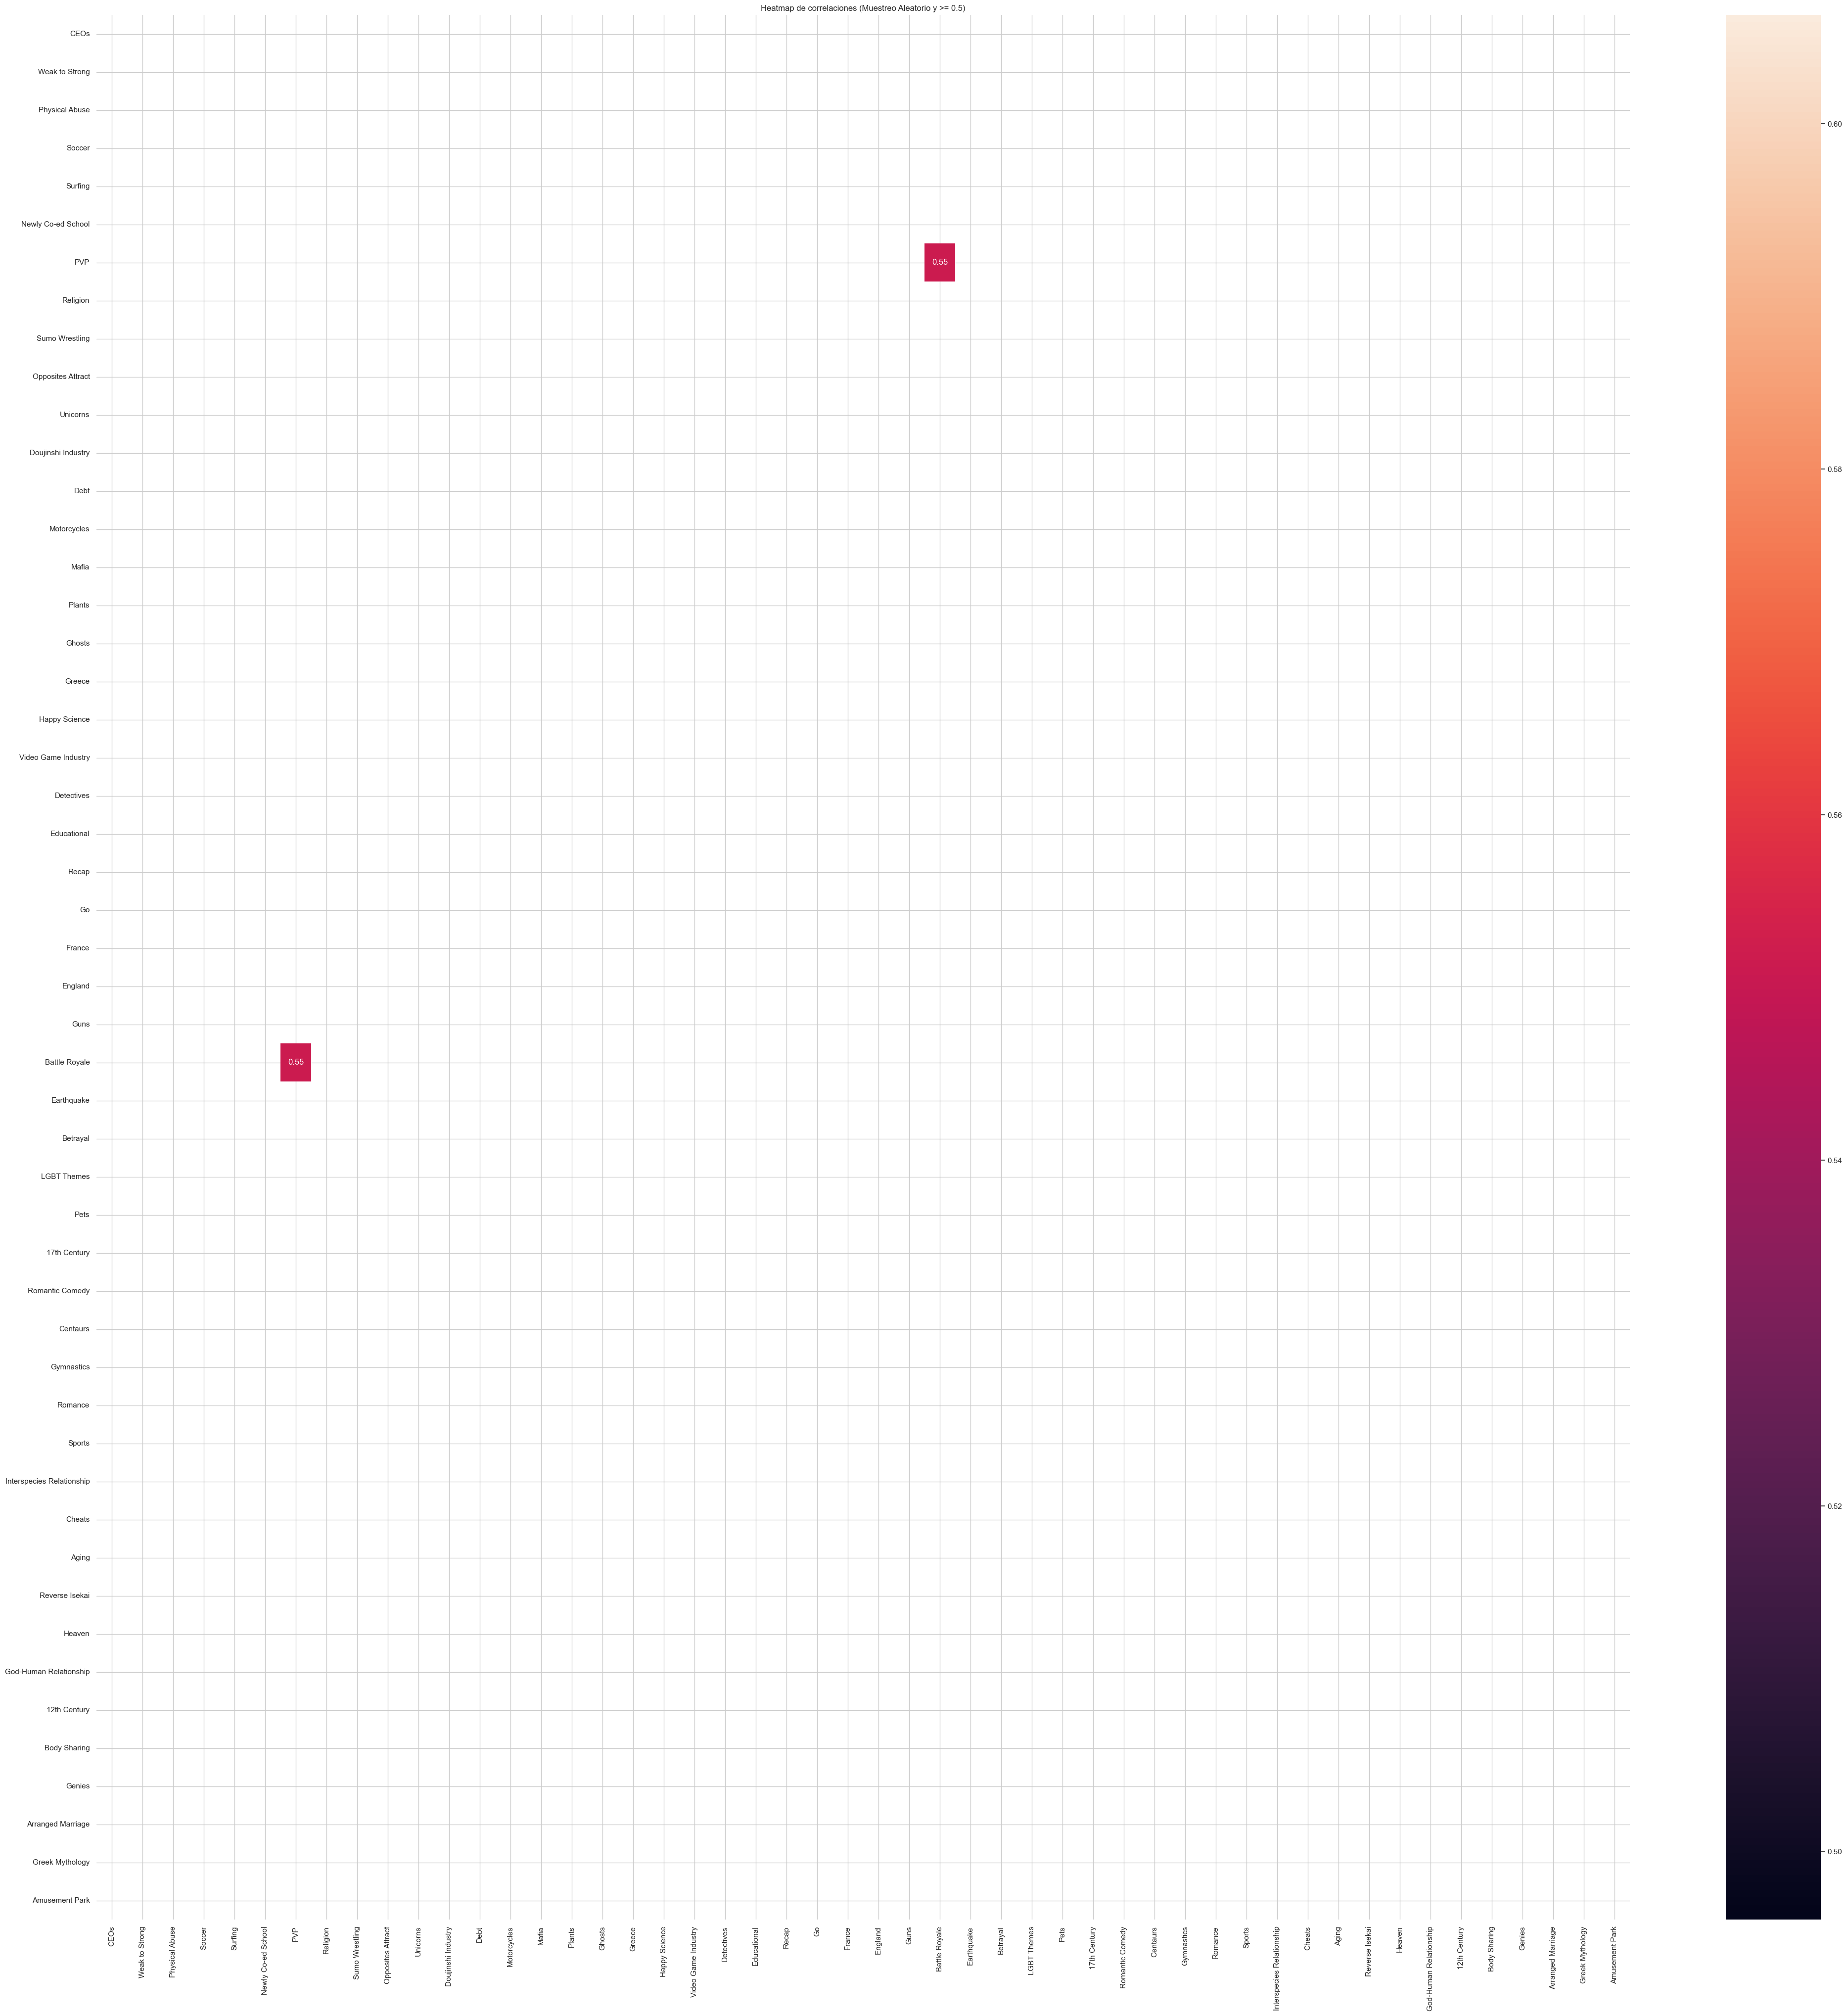

c:\Users\mativ\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
c:\Users\mativ\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


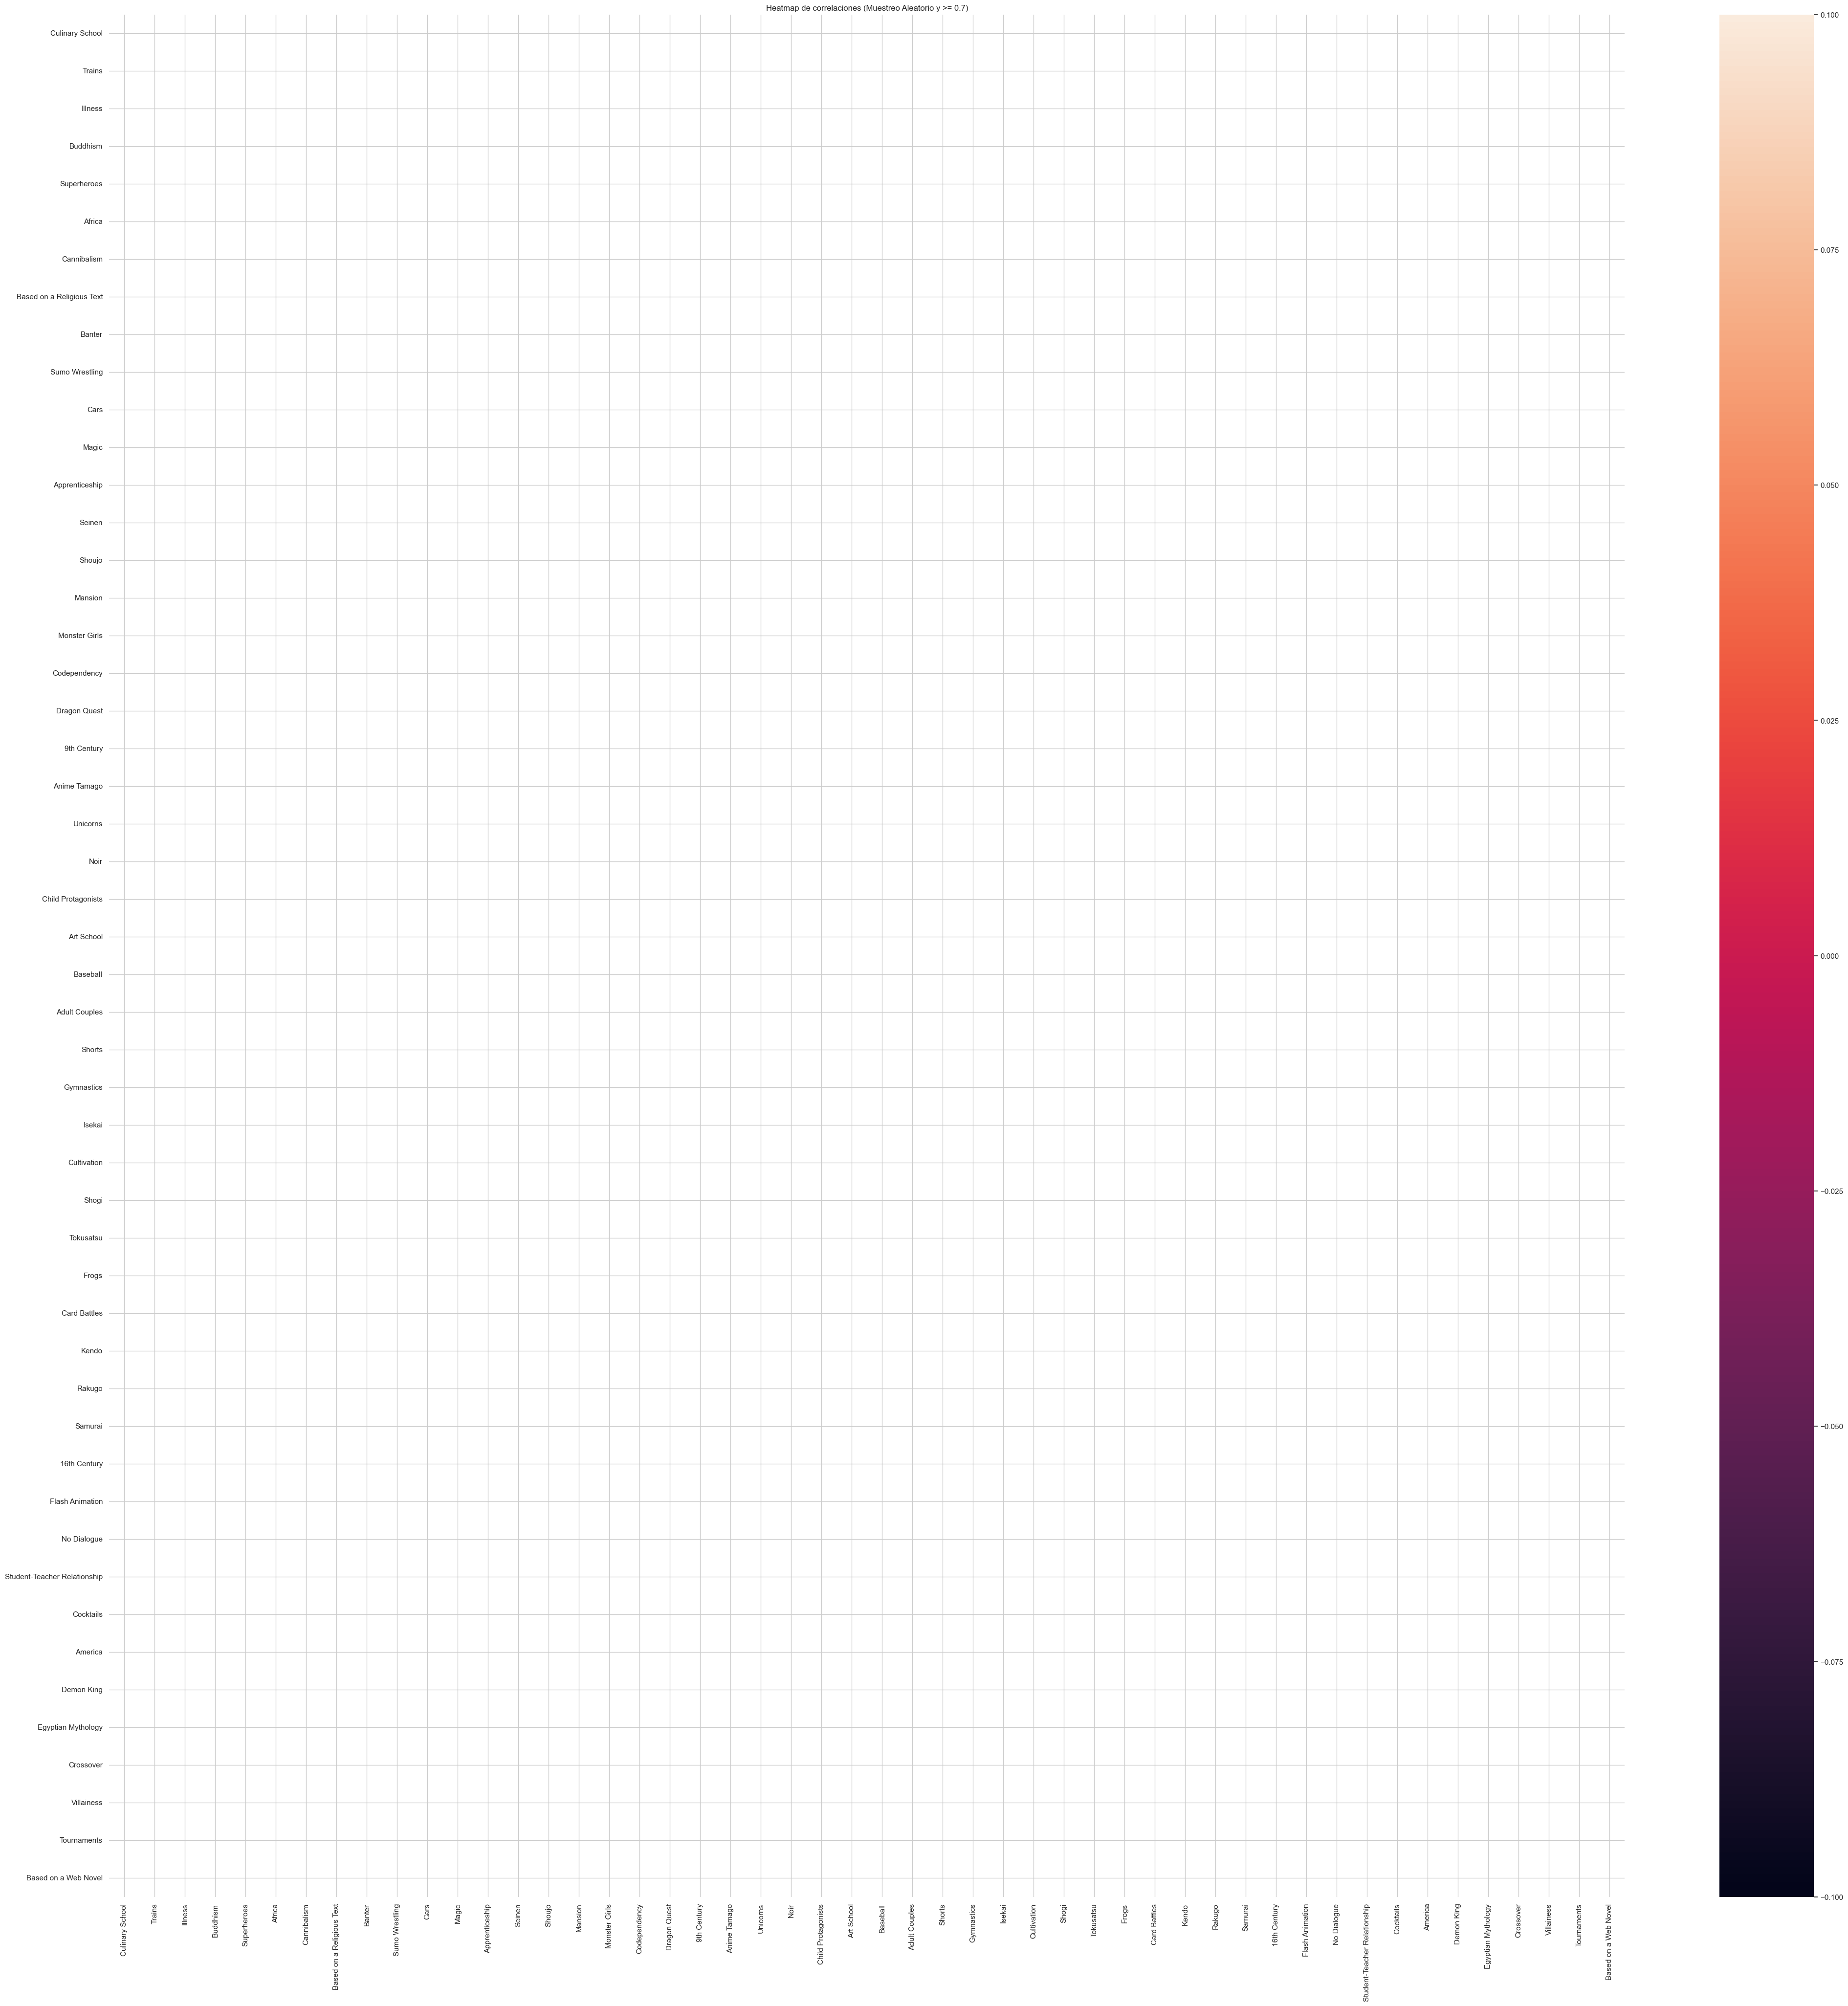

c:\Users\mativ\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
c:\Users\mativ\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


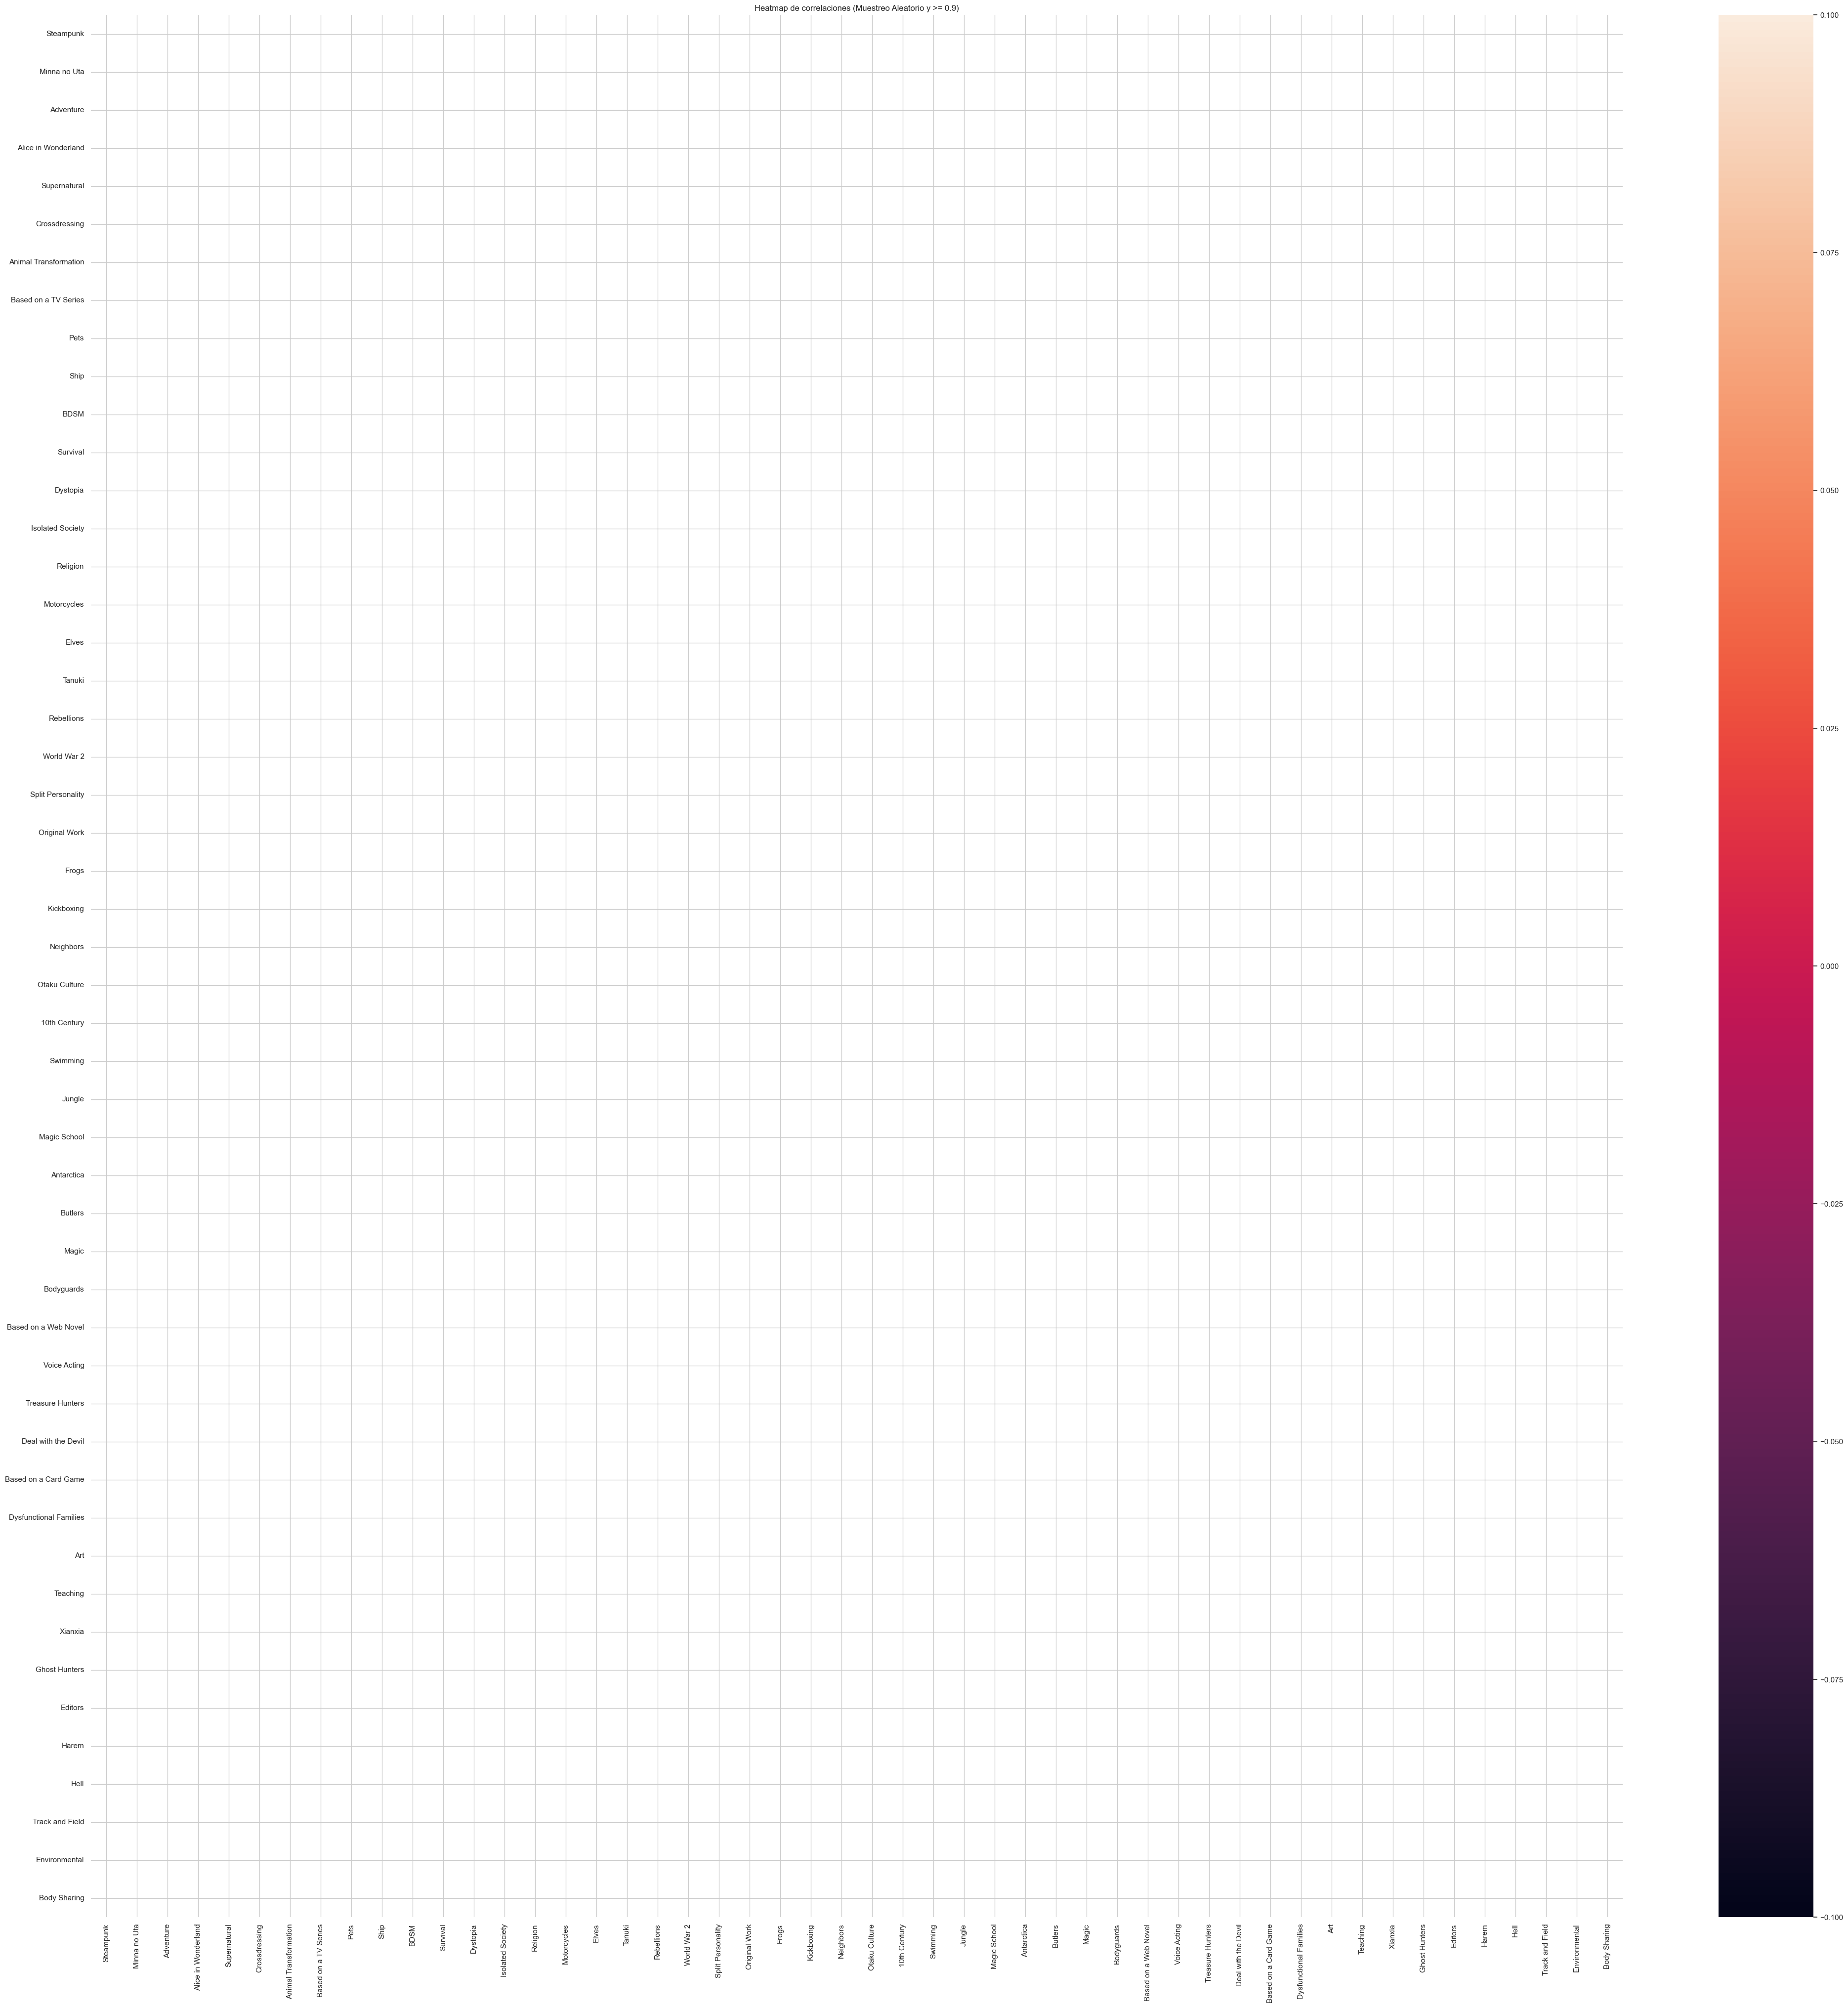

c:\Users\mativ\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
c:\Users\mativ\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


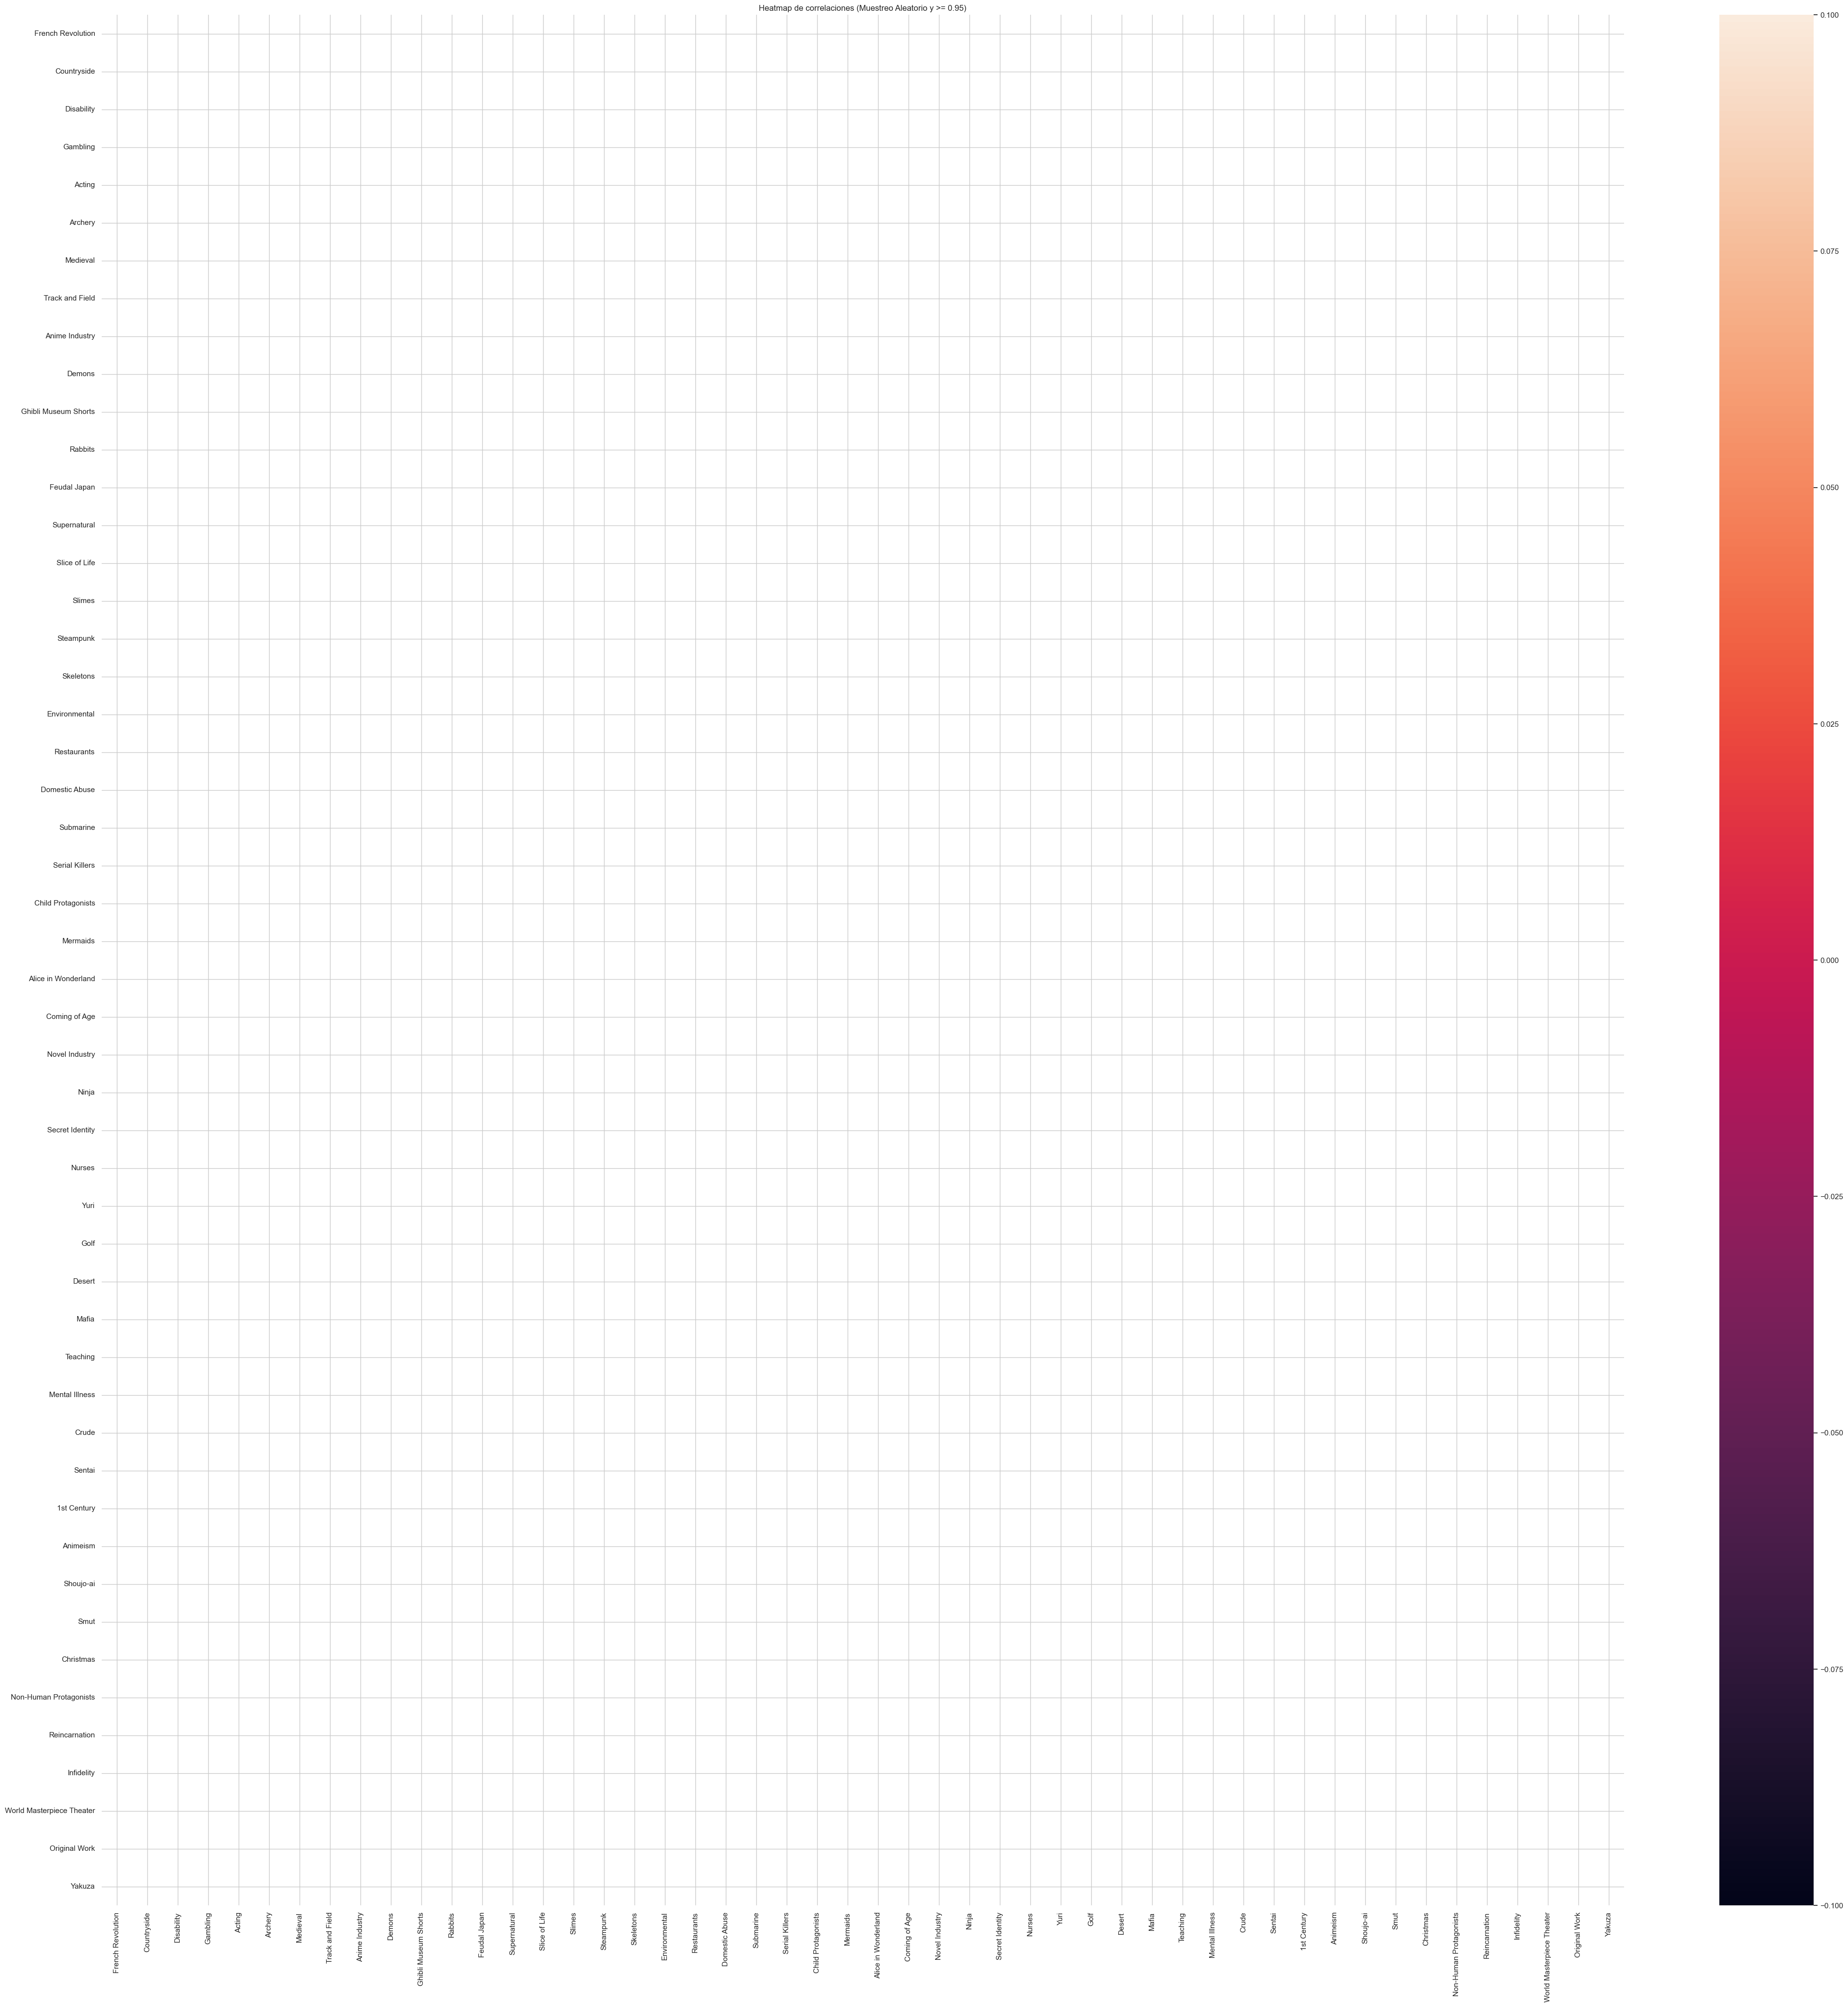

In [235]:
# Correlacción de forma gráfica.

# El plan es el siguiente: Dado que hay muchas columnas, solo se considerarán las correlacciones
# que sea >= 0.5. En otro gráfico, para ampliar, correlacciones >=0.7. En otro, >=0.9. Y por
# último, en otro gráfico, >=0.95.

# Para ello, se hará un bucle que itere sobre los valores de correlacción que se quieren
# considerar. En cada iteración, se hará un subset del DataFrame de correlacciones, considerando
# solamente las correlacciones que sean >= al valor de correlacción que se está considerando en la
# iteración actual. Luego, se hará un heatmap con el subset. Sin embargo, no considerar la diagonal
# donde la correlacción es 1, ya que no tiene sentido considerar la correlacción de un tag consigo
# mismo. Además, se hará un subplot para cada iteración, para que se vea mejor.

# Se considerarán los siguientes valores de correlacción: 0.5, 0.7, 0.9, 0.95

# Número máximo de columnas a mostrar en el heatmap
max_columns_to_show = 50

# Lista de valores de correlación a considerar
corr_values_to_show = [0.25, 0.5, 0.7, 0.9, 0.95]

for corr_value in corr_values_to_show:
    # Seleccionar un subconjunto aleatorio de columnas
    random_columns = random.sample(
        unified_df.columns.tolist(),
        k=min(max_columns_to_show, len(unified_df.columns)),
    )

    # Crear el subset de correlaciones
    corr_subset = unified_df[random_columns].corr()

    # Filtrar solo las correlaciones que son >= al valor de correlación deseado
    corr_subset = corr_subset[corr_subset.abs() >= corr_value]

    # Eliminar la diagonal estableciéndola a NaN
    np.fill_diagonal(corr_subset.values, np.nan)

    # Obtener el número de filas y columnas del subset
    rows, cols = corr_subset.shape

    # Crear el subplot
    fig, ax = plt.subplots(figsize=(cols, rows))

    # Crear el heatmap
    sns.heatmap(corr_subset, annot=True, ax=ax)

    # Ponerle título al heatmap
    ax.set_title(f"Heatmap de correlaciones (Muestreo Aleatorio y >= {corr_value})")

    # Mostrar el heatmap
    plt.show()

In [236]:
# En específico, imprimir las correlaciones >= 0.95, que no sean con el mismo tag (diagonal).

corr_subset = unified_df.corr()[unified_df.corr() >= 0.95]

print("Correlaciones >= 0.95:")
for col in corr_subset.columns:
    for row in corr_subset.index:
        if col != row and not np.isnan(corr_subset.loc[row, col]):  # type: ignore
            print(
                f"\t{row} y {col} tienen una correlación de {corr_subset.loc[row, col]}"
            )

Correlaciones >= 0.95:
	GL y Shoujo-ai tienen una correlación de 0.9664353820637148
	Shoujo-ai y GL tienen una correlación de 0.9664353820637148
	BL y Shounen-ai tienen una correlación de 0.9694671903042554
	Shounen-ai y BL tienen una correlación de 0.9694671903042554


In [286]:
# Top 10 de mayores correlaciones

corr_subset = unified_df.corr().abs().unstack().sort_values(ascending=False)

# Eliminar las correlaciones de un tag consigo mismo

corr_subset = corr_subset[
    corr_subset.index.get_level_values(0) != corr_subset.index.get_level_values(1)
]

# Eliminar las correlaciones repetidas

corr_subset = corr_subset[
    corr_subset.index.get_level_values(0) < corr_subset.index.get_level_values(1)
]

# Mostrar el top 10

corr_subset.head(10)



BL                Shounen-ai          0.969467
GL                Shoujo-ai           0.966435
Earthquake        Natural Disaster    0.935361
Running           Track and Field     0.816403
Sentai            Tokusatsu           0.816081
Kingdom Building  Management          0.783066
Boarding House    Neighbors           0.767520
Art               Art School          0.765117
Adult Couples     Mature Romance      0.749233
Flower Shop       Plants              0.707066
dtype: float64

In [289]:
# Muestra del top 10 de correlaciones 

print("Top 10 de correlaciones:")

for i, (tags, corr) in enumerate(corr_subset.head(10).items()):
    tag1, tag2 = tags
    print(
        f"\t{i+1}. {tag1} y {tag2} tienen una correlación de {corr}"
    )
    

Top 10 de correlaciones:
	1. BL y Shounen-ai tienen una correlación de 0.9694671903042547
	2. GL y Shoujo-ai tienen una correlación de 0.9664353820637137
	3. Earthquake y Natural Disaster tienen una correlación de 0.935360984398642
	4. Running y Track and Field tienen una correlación de 0.8164034532877453
	5. Sentai y Tokusatsu tienen una correlación de 0.8160809785836852
	6. Kingdom Building y Management tienen una correlación de 0.78306629496894
	7. Boarding House y Neighbors tienen una correlación de 0.767520463364294
	8. Art y Art School tienen una correlación de 0.7651166020924214
	9. Adult Couples y Mature Romance tienen una correlación de 0.74923262576443
	10. Flower Shop y Plants tienen una correlación de 0.7070664706782244


Veamos las correlaciones positivas más significativas:

Shounen-ai y BL tiene sentido si se buscan ambos conceptos en internet, pues aluden a lo mismo o
muy similar. Básicamente, la noción de romance.

GL y Shoujo-ai también tiene sentido, pues aluden a lo mismo o muy similar. Básicamente, la noción
de romance.

Earthquake y Natural Disaster también tiene sentido, dado que es comprensible que un terremoto sea
catalogado como un desastre natural.

Sentai y Tokusatsu también tiene sentido, porque, leyendo la documentación del tag de Sentai en
Anime-Planet, se entiende que es un subgénero de Tokusatsu.

Kingdom Building y Management también tiene sentido, porque, la construcción de un reino suele
estar relacionada con la administración del mismo.

Boarding House y Neighbors también tiene sentido, porque, en un boarding house es común que los
vecinos sean cercanos. 

Art y Art School obviamente tiene sentido, pues en una escuela de arte se enseña arte.

Adult Couples y Mature Romance también tiene sentido, evidentemente.

Flower Shop y Plants también tiene sentido, pues en una florería se venden plantas.

Ampliar el margen de búsqueda para ver si se encuentran más correlaciones positivas significativas:

In [238]:
# En específico, imprimir las correlaciones >= 0.95, que no sean con el mismo tag (diagonal).

corr_subset = unified_df.corr()[unified_df.corr() >= 0.75]

print("Correlaciones >= 0.75:")
for col in corr_subset.columns:
    for row in corr_subset.index:
        if col != row and not np.isnan(corr_subset.loc[row, col]):  # type: ignore
            print(
                f"\t{row} y {col} tienen una correlación de {corr_subset.loc[row, col]}"
            )

Correlaciones >= 0.75:
	Kingdom Building y Management tienen una correlación de 0.7830662949689402
	Sentai y Tokusatsu tienen una correlación de 0.8160809785836859
	GL y Shoujo-ai tienen una correlación de 0.9664353820637148
	Art y Art School tienen una correlación de 0.7651166020924213
	Art School y Art tienen una correlación de 0.7651166020924213
	Track and Field y Running tienen una correlación de 0.8164034532877452
	Tokusatsu y Sentai tienen una correlación de 0.8160809785836859
	Earthquake y Natural Disaster tienen una correlación de 0.9353609843986421
	Shoujo-ai y GL tienen una correlación de 0.9664353820637148
	Natural Disaster y Earthquake tienen una correlación de 0.9353609843986421
	BL y Shounen-ai tienen una correlación de 0.9694671903042554
	Shounen-ai y BL tienen una correlación de 0.9694671903042554
	Running y Track and Field tienen una correlación de 0.8164034532877452
	Boarding House y Neighbors tienen una correlación de 0.7675204633642936
	Management y Kingdom Building

Viendo un vistazo rápido a lo obtenido, parece tener sentido la correlación altamente positiva
entre dichos tags, dado que los tags aluden a conceptos similares o muy relacionados intrínsecamente.

c:\Users\mativ\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
c:\Users\mativ\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


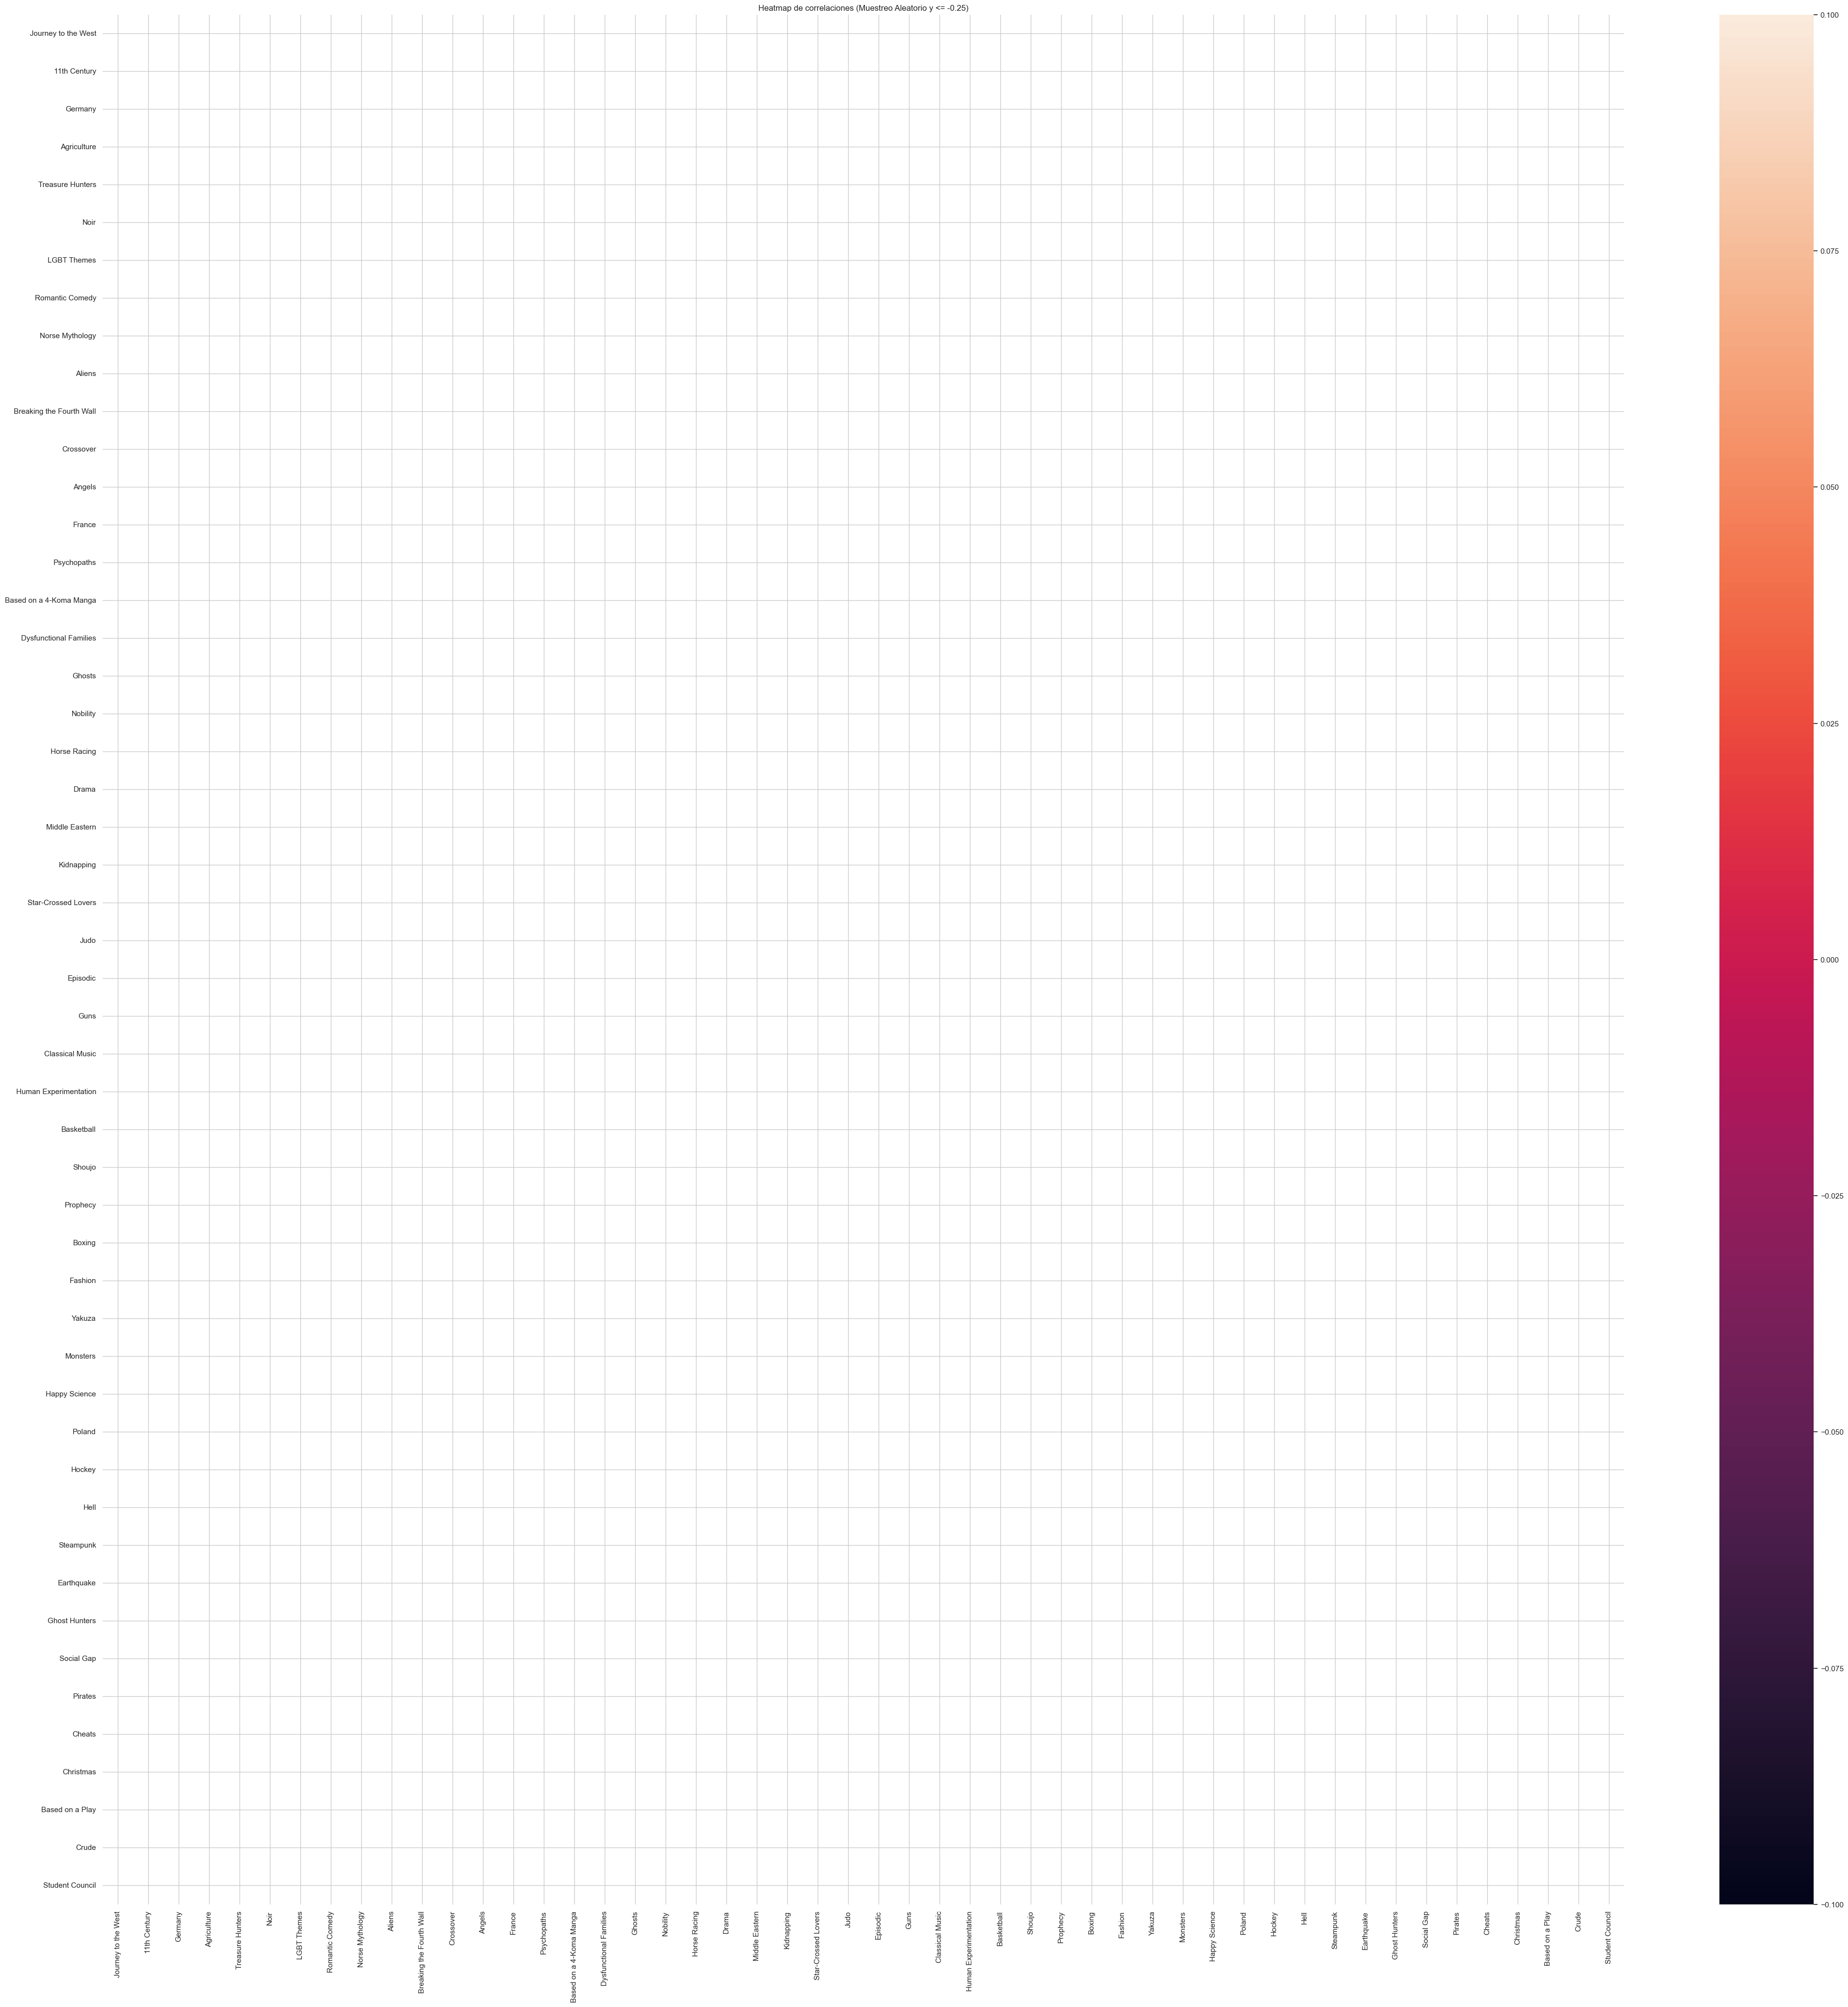

c:\Users\mativ\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
c:\Users\mativ\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


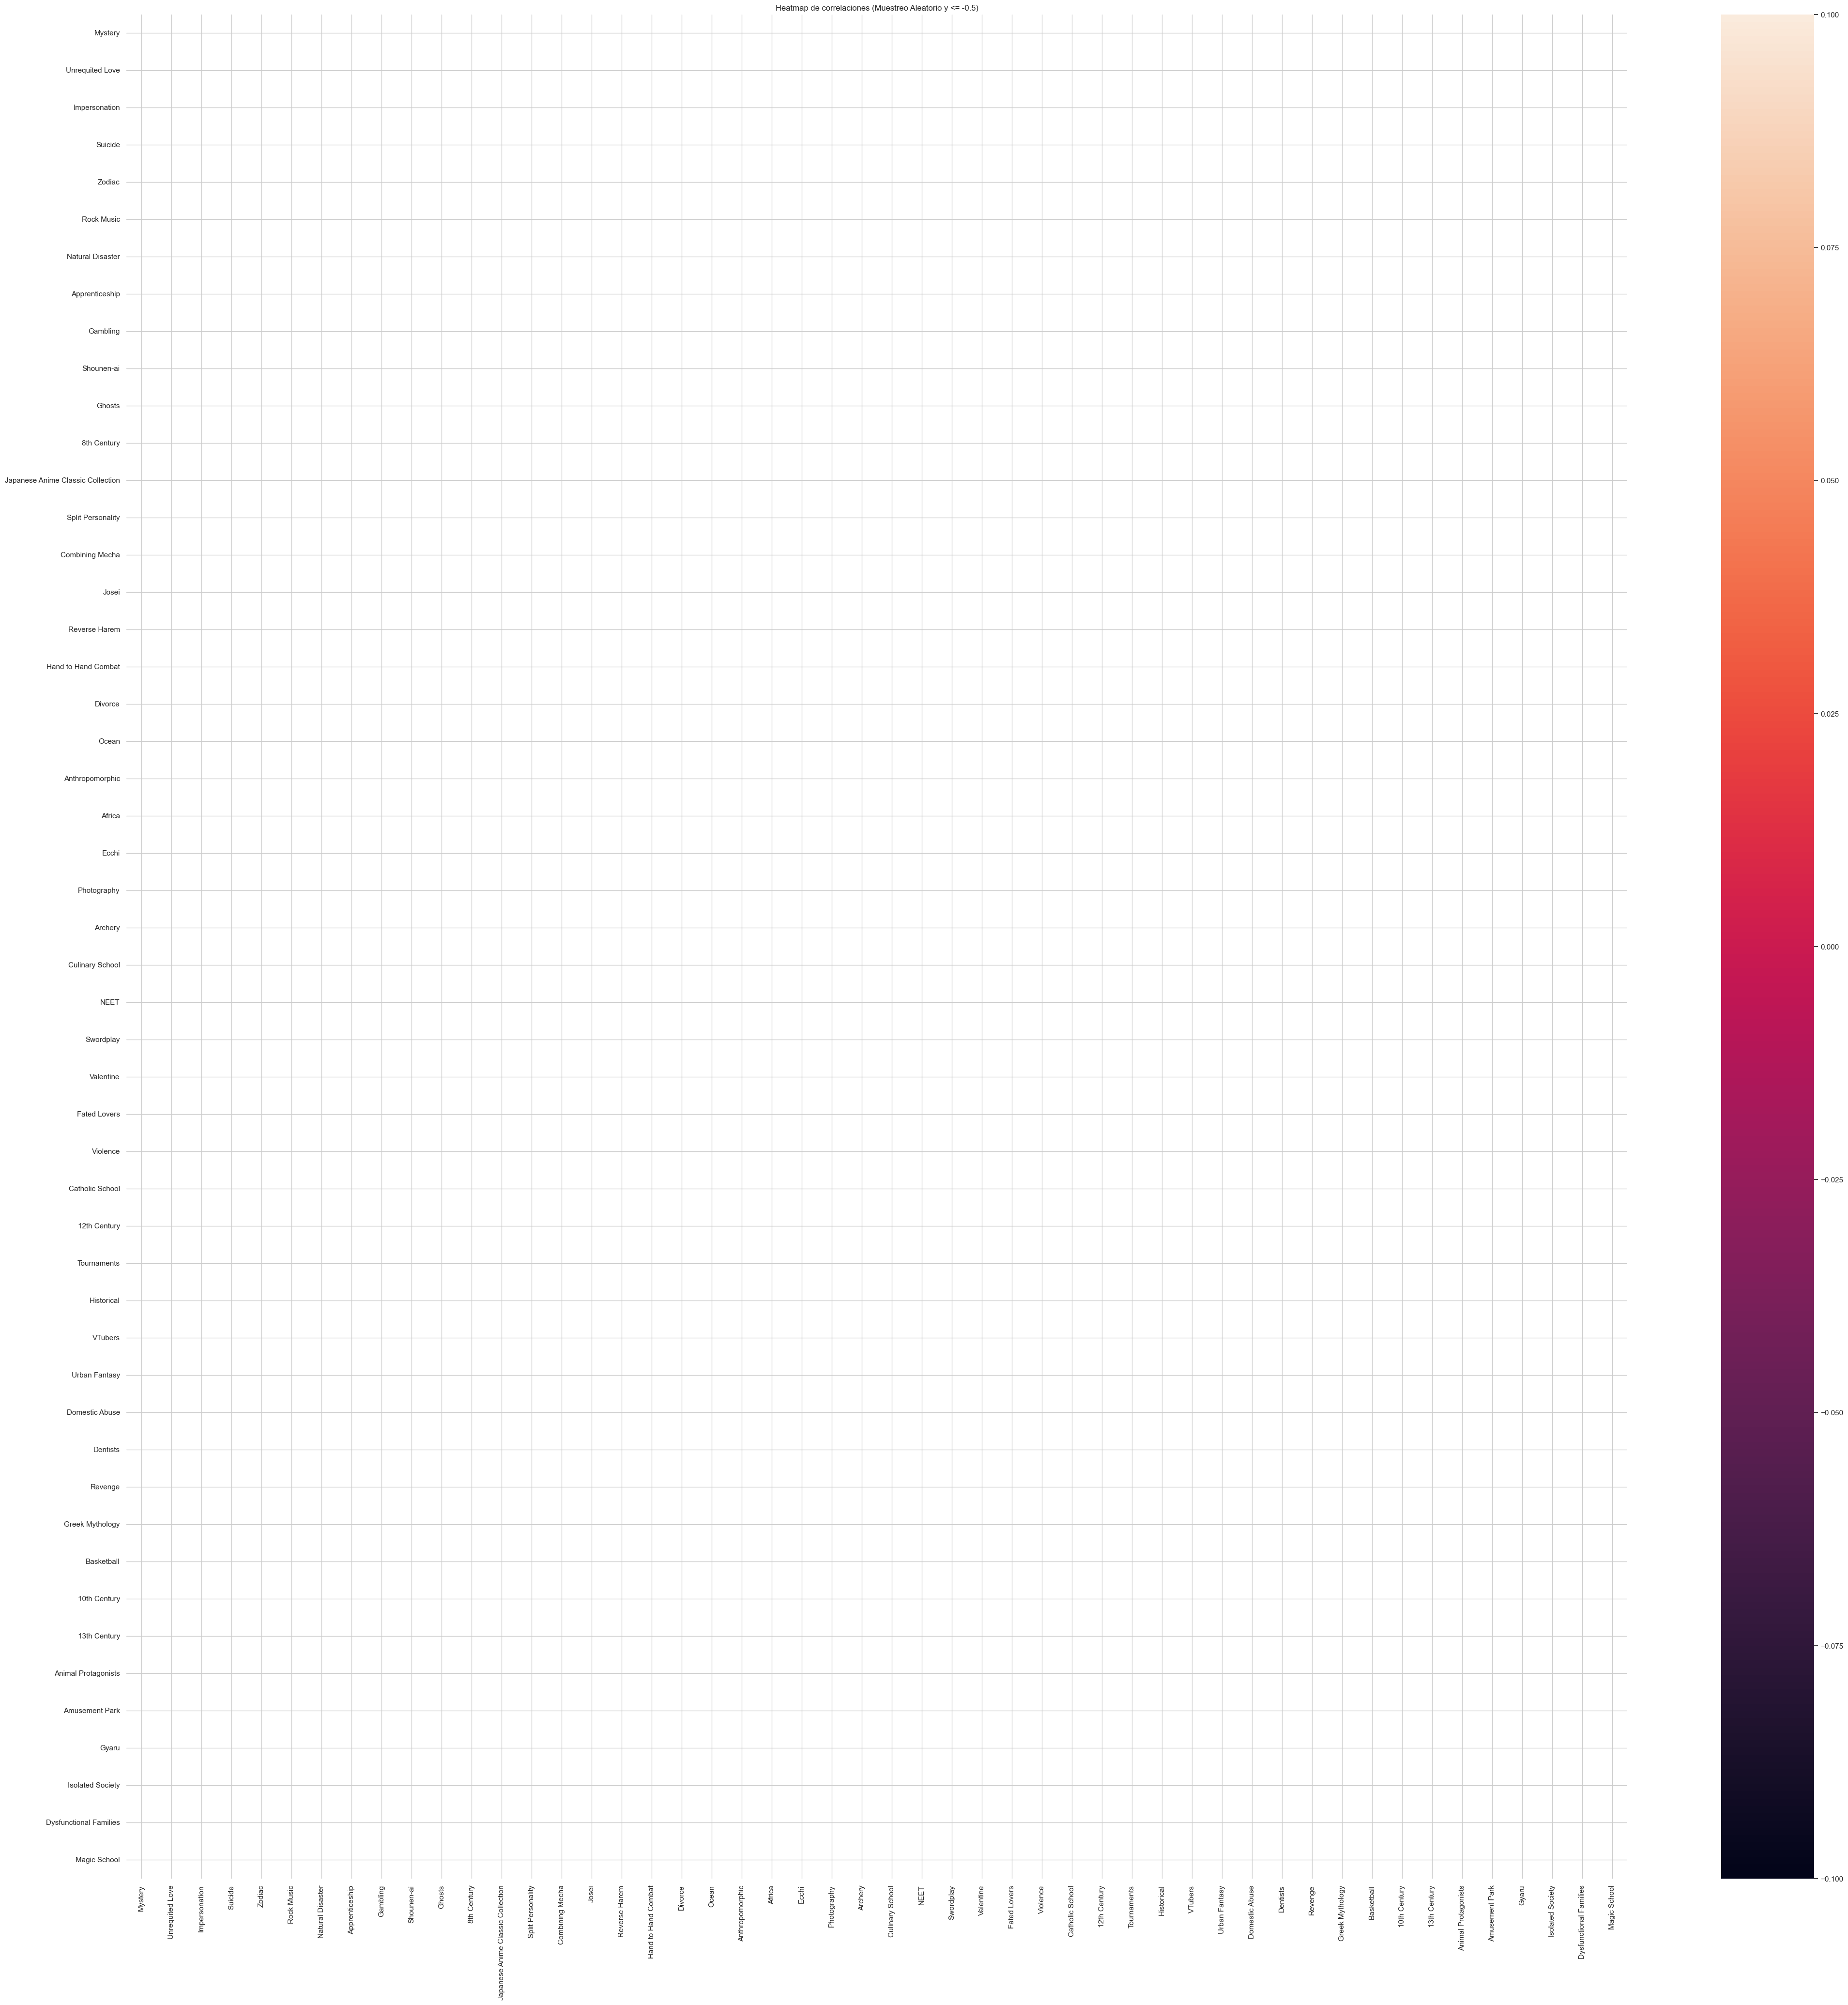

c:\Users\mativ\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
c:\Users\mativ\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


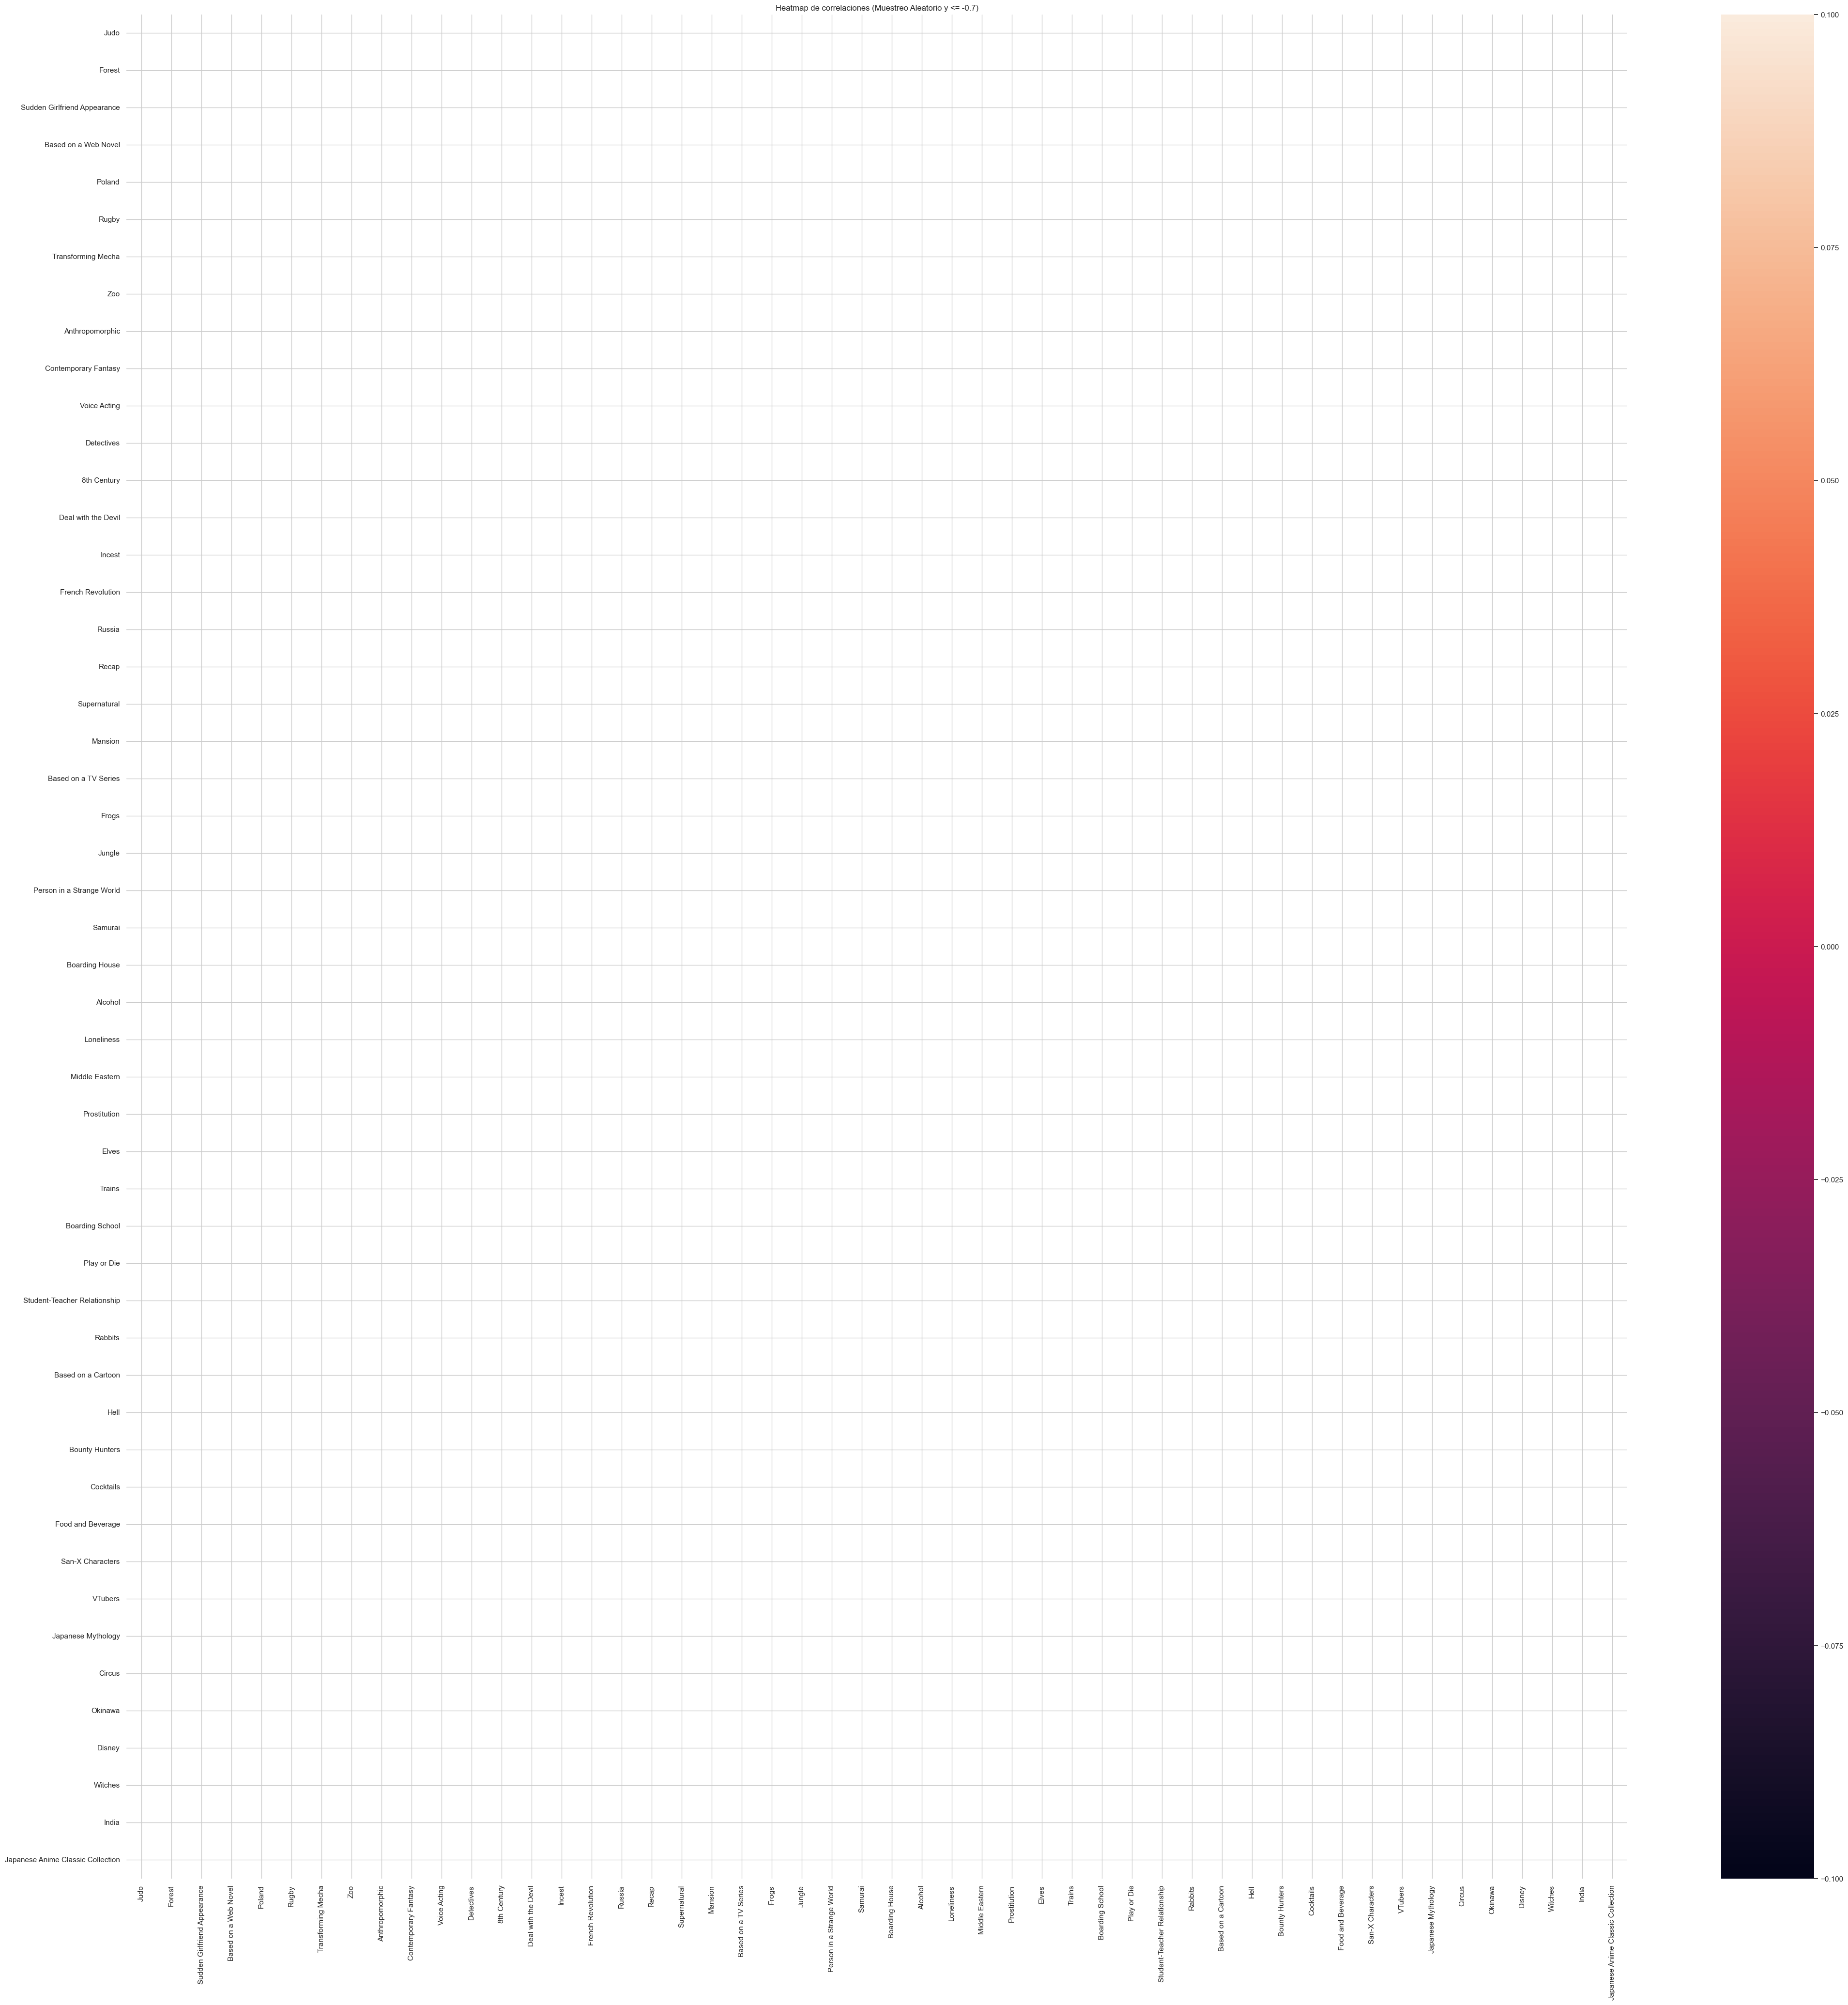

c:\Users\mativ\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
c:\Users\mativ\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


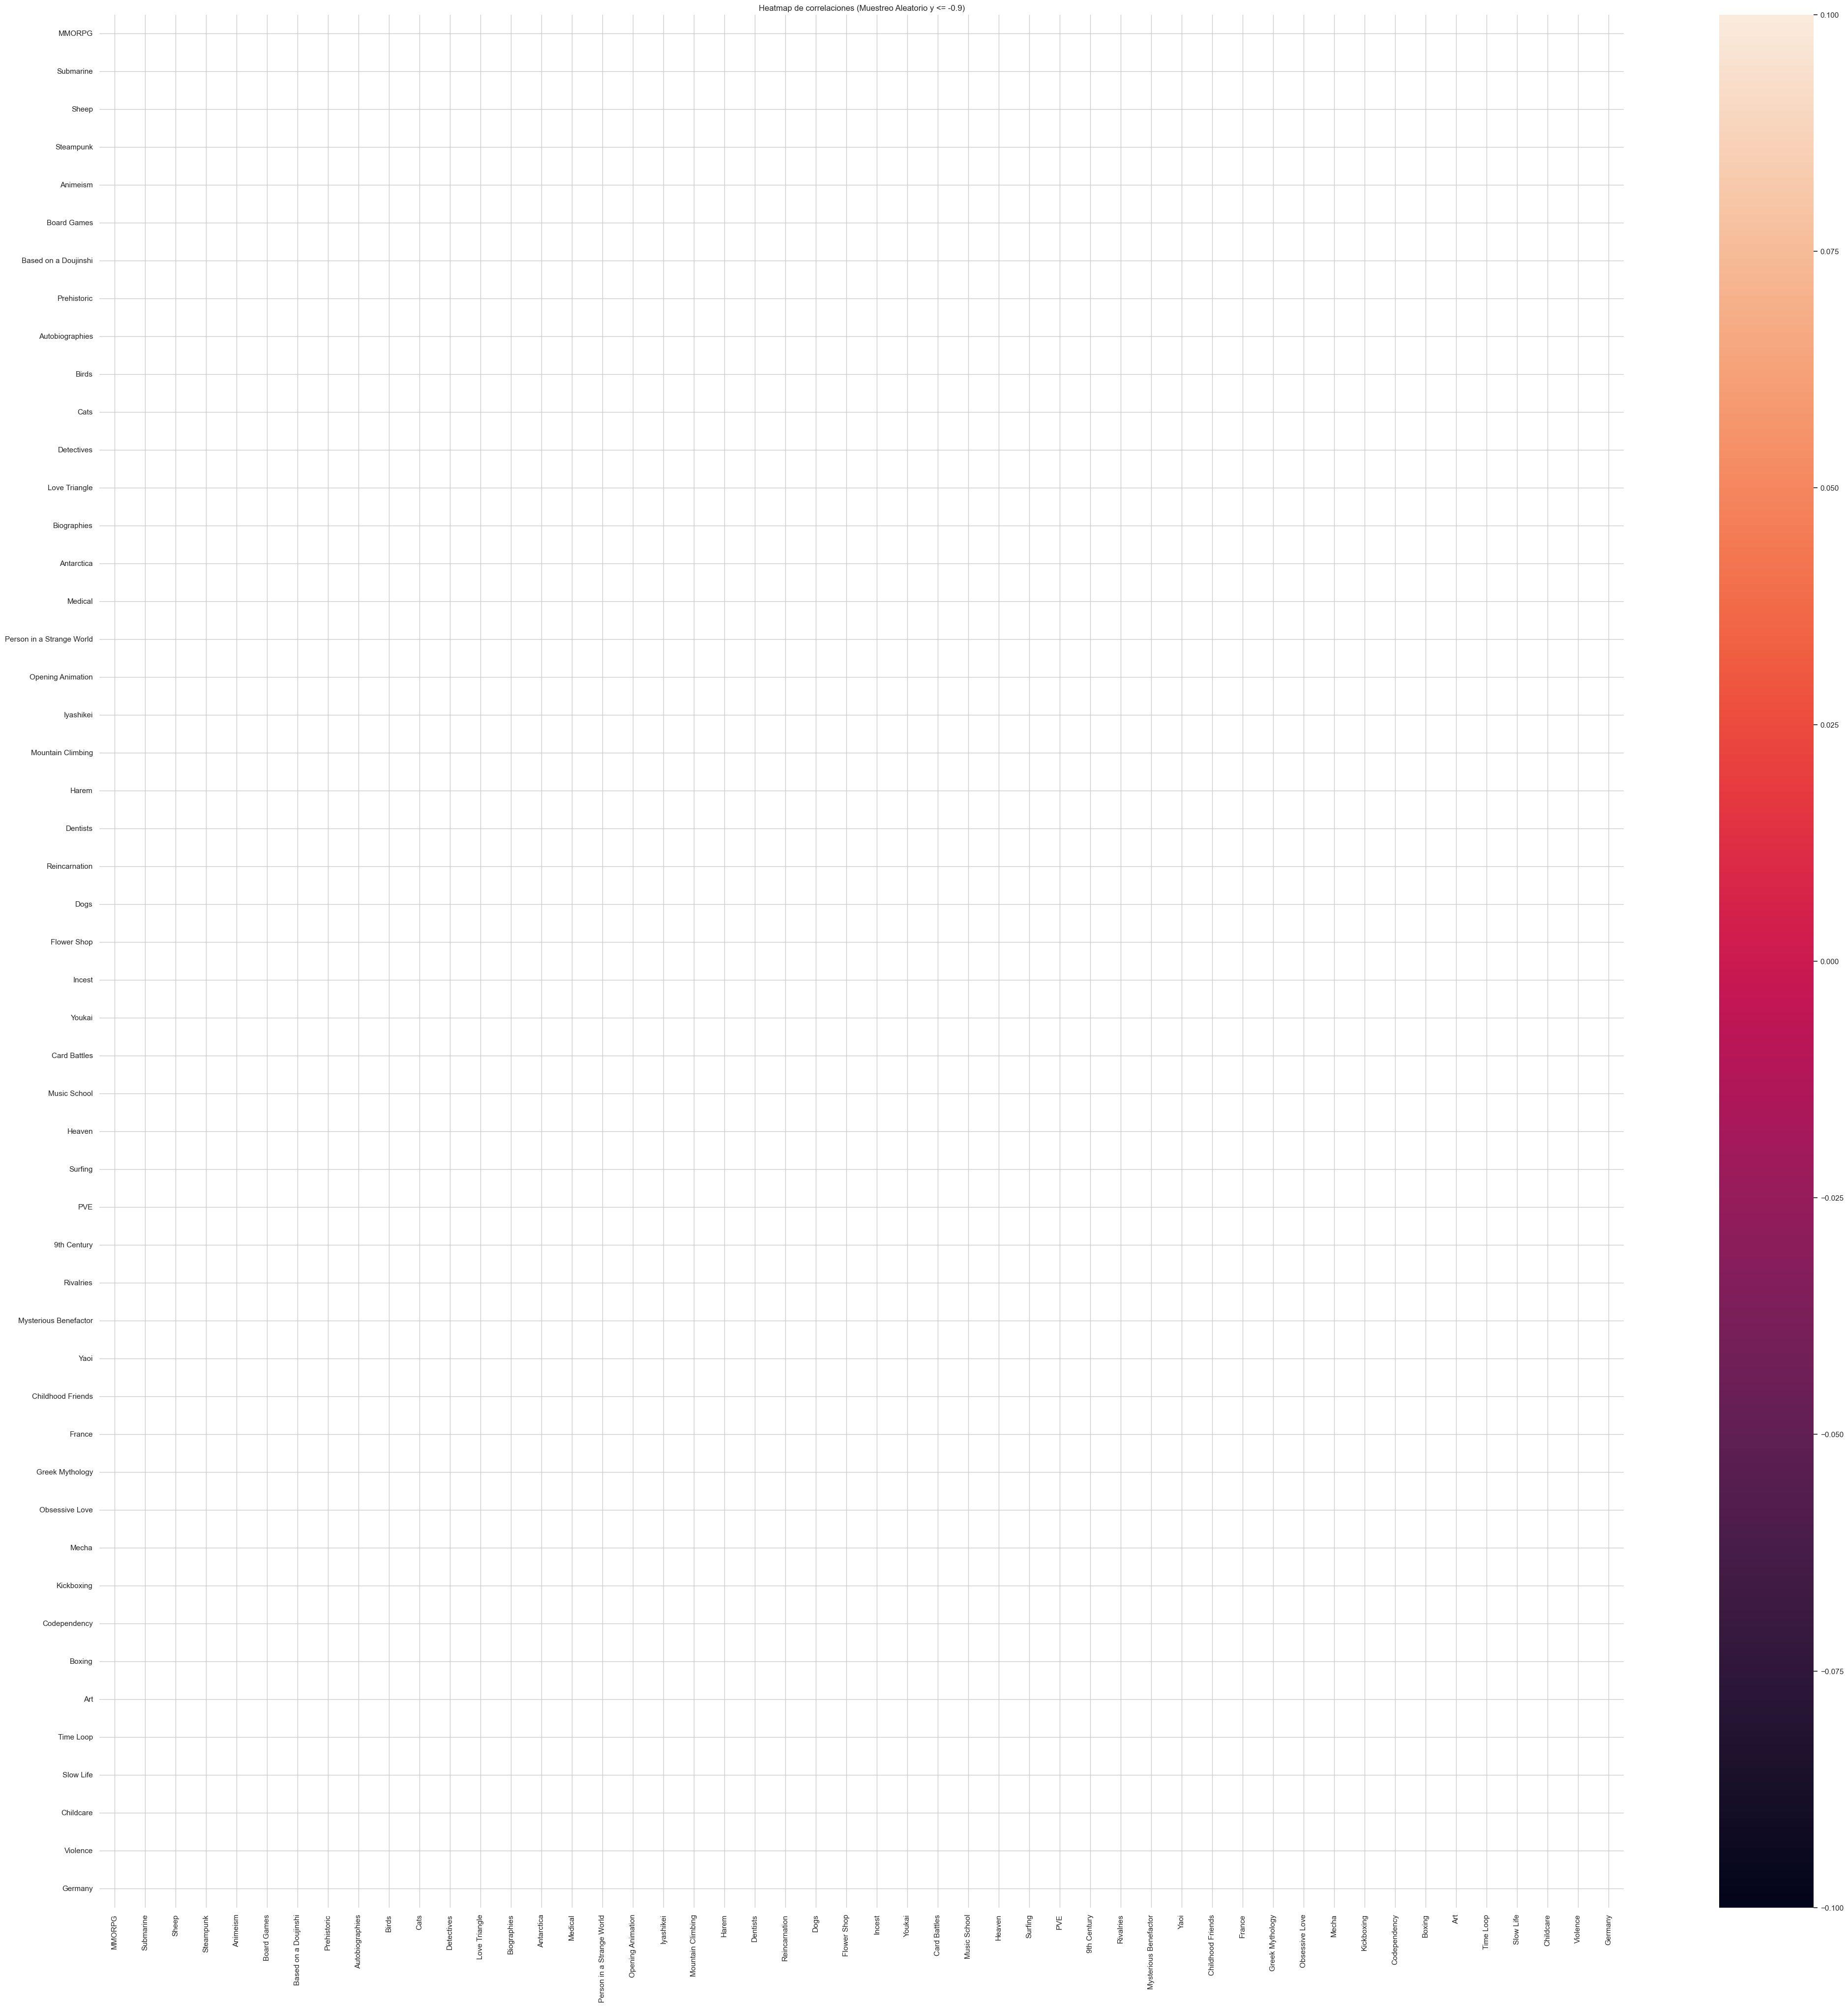

c:\Users\mativ\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
c:\Users\mativ\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


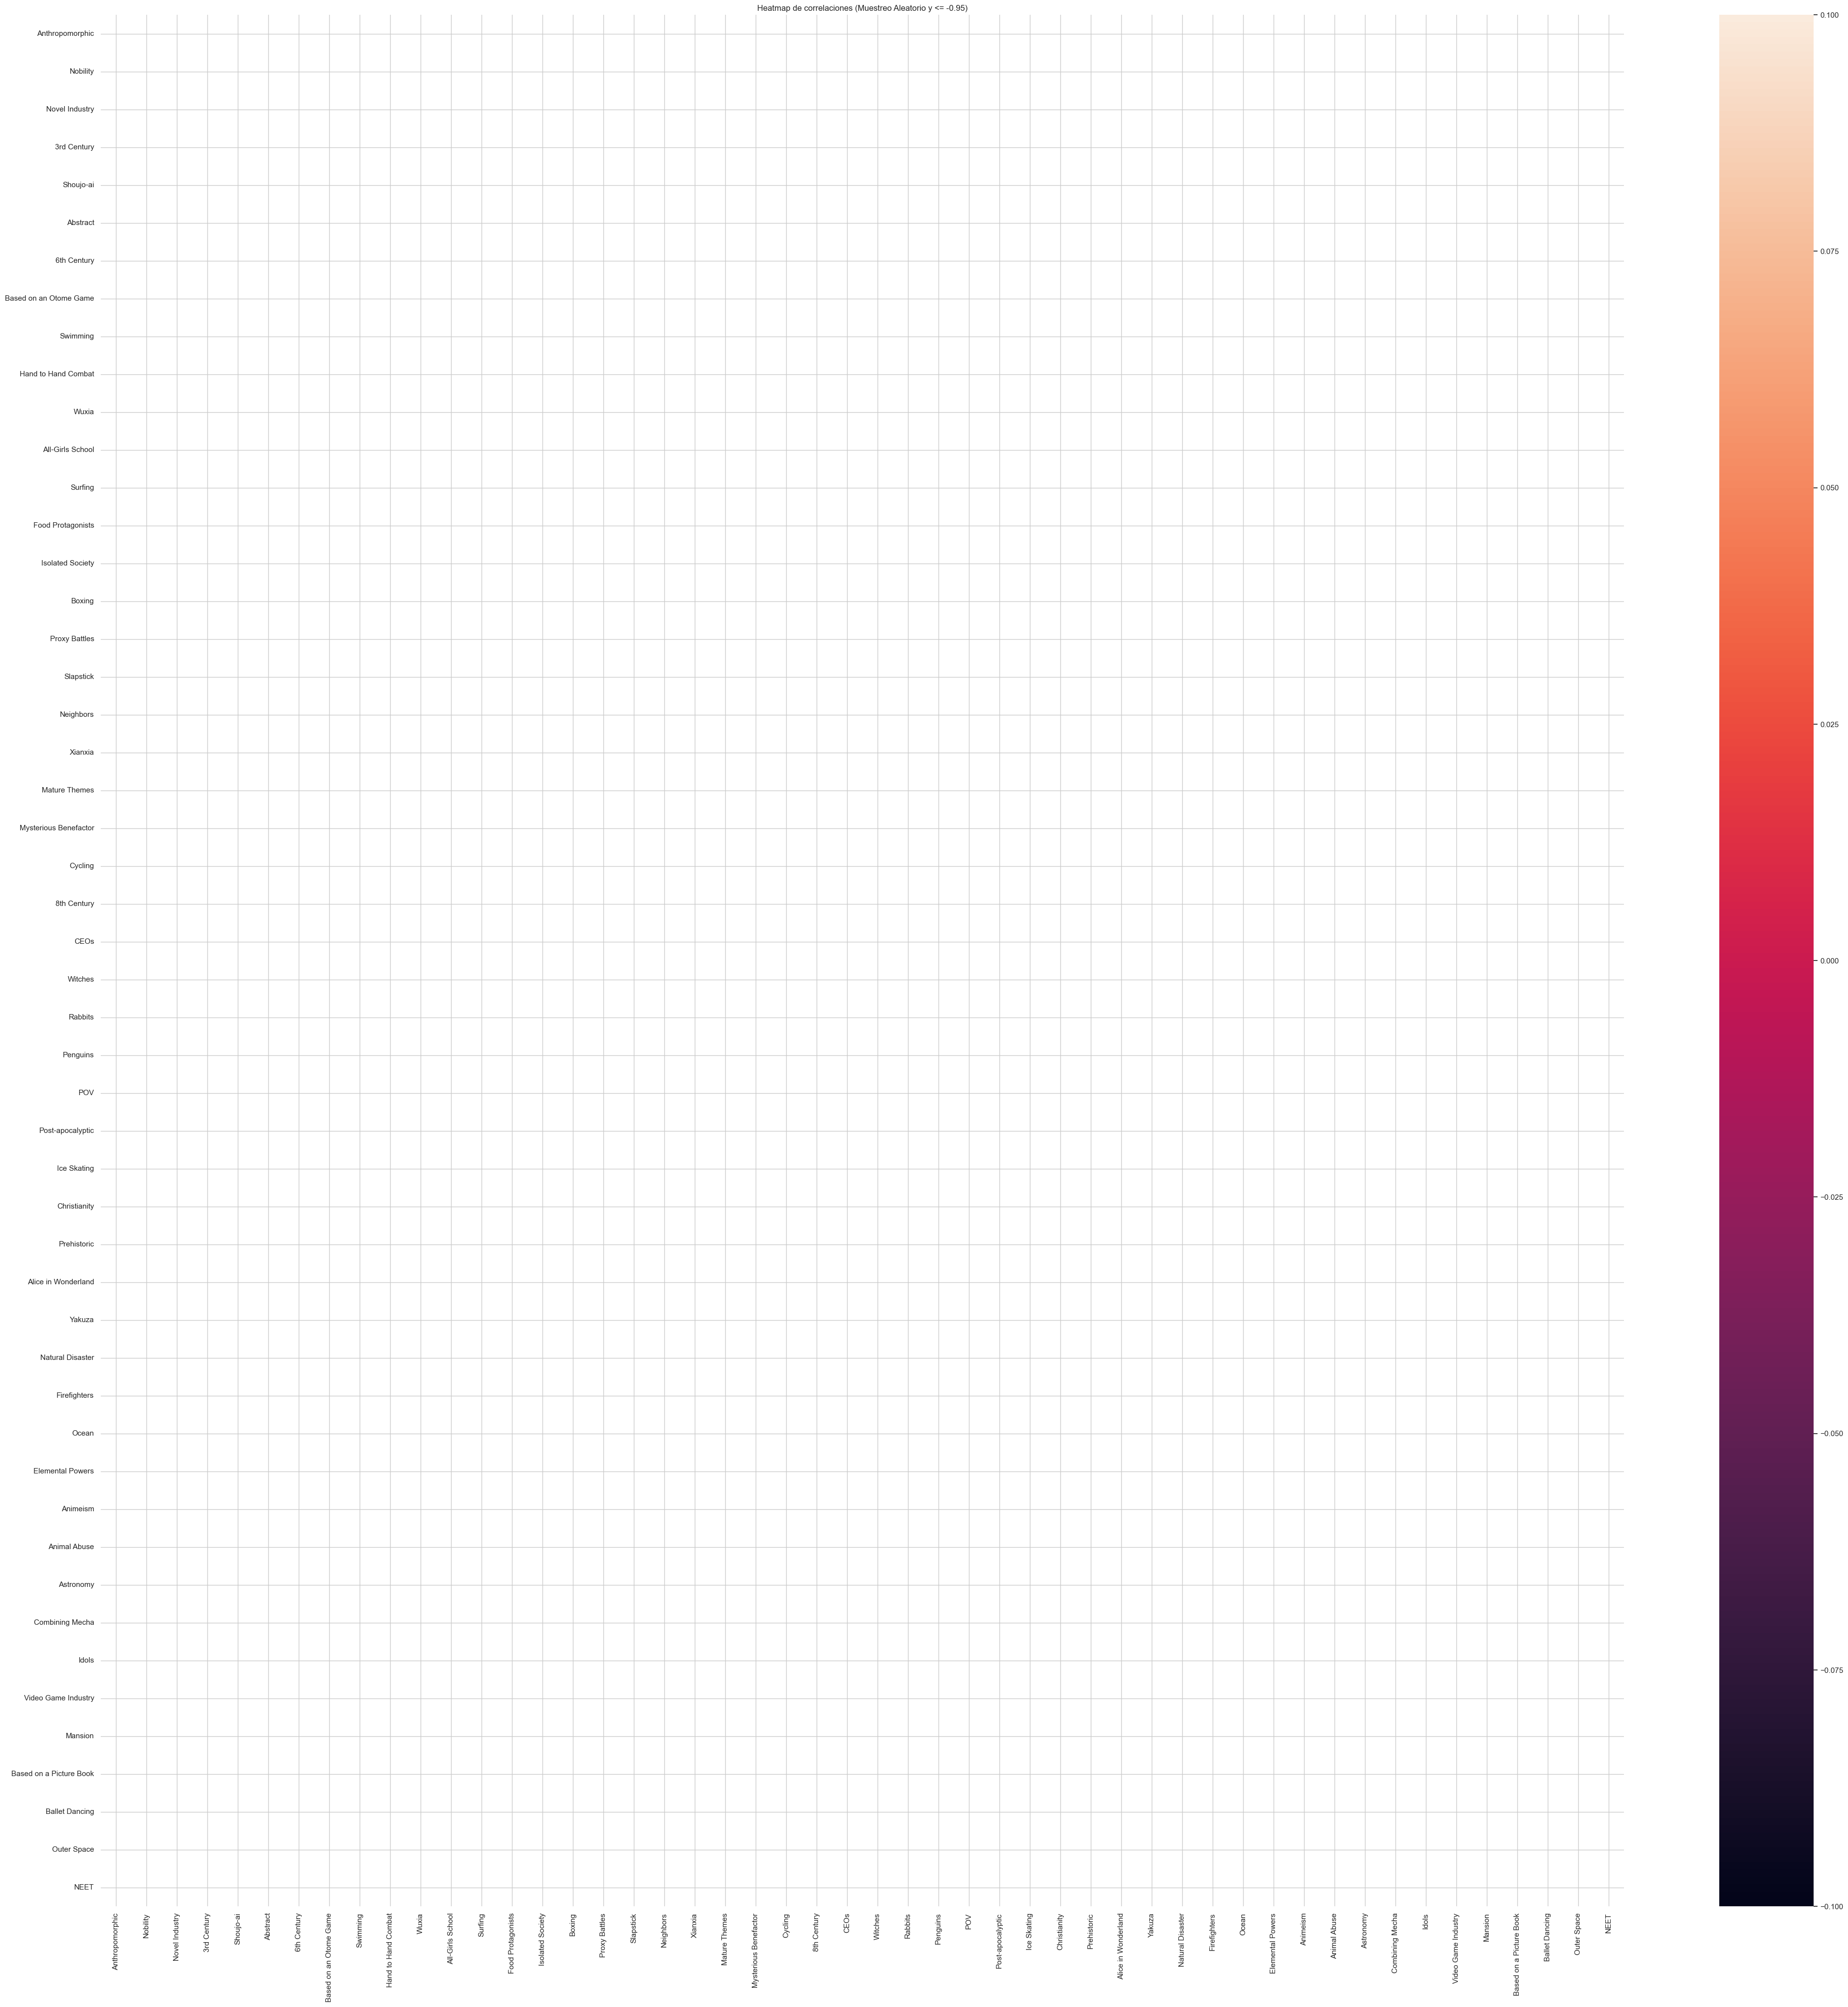

In [239]:
# Ahora, lo mismo de los heatmaps, pero viendo correlacciones negativas. De la misma forma, pero
# usando valores de correlacción negativos.

# Número máximo de columnas a mostrar en el heatmap
max_columns_to_show = 50

# Lista de valores de correlación a considerar
corr_values_to_show = [-0.25, -0.5, -0.7, -0.9, -0.95]

for corr_value in corr_values_to_show:
    # Seleccionar un subconjunto aleatorio de columnas
    random_columns = random.sample(
        unified_df.columns.tolist(),
        k=min(max_columns_to_show, len(unified_df.columns)),
    )

    # Crear el subset de correlaciones
    corr_subset = unified_df[random_columns].corr()

    # Filtrar solo las correlaciones que son <= al valor de correlación deseado
    corr_subset = corr_subset[corr_subset.abs() <= corr_value]

    # Eliminar la diagonal estableciéndola a NaN
    np.fill_diagonal(corr_subset.values, np.nan)

    # Obtener el número de filas y columnas del subset
    rows, cols = corr_subset.shape

    # Crear el subplot
    fig, ax = plt.subplots(figsize=(cols, rows))

    # Crear el heatmap
    sns.heatmap(corr_subset, annot=True, ax=ax)

    # Ponerle título al heatmap
    ax.set_title(f"Heatmap de correlaciones (Muestreo Aleatorio y <= {corr_value})")

    # Mostrar el heatmap
    plt.show()

In [240]:
# En específico, imprimir las correlaciones <= -0.95, que no sean con el mismo tag (diagonal).

corr_subset = unified_df.corr()[unified_df.corr() <= -0.95]

print("Correlaciones <= -0.95:")

for col in corr_subset.columns:
    for row in corr_subset.index:
        if col != row and not np.isnan(corr_subset.loc[row, col]):
            print(
                f"\t{row} y {col} tienen una correlación de {corr_subset.loc[row, col]}"
            )

Correlaciones <= -0.95:


Como no se halló nada, ampliemos la brecha.

In [241]:
corr_subset = unified_df.corr()[unified_df.corr() <= -0.75]

print("Correlaciones <= -0.75:")

for col in corr_subset.columns:
    for row in corr_subset.index:
        if col != row and not np.isnan(corr_subset.loc[row, col]):
            print(
                f"\t{row} y {col} tienen una correlación de {corr_subset.loc[row, col]}"
            )

Correlaciones <= -0.75:


Ampliemos la brecha aún más.

In [242]:
corr_subset = unified_df.corr()[unified_df.corr() <= -0.5]

print("Correlaciones <= -0.5:")

for col in corr_subset.columns:
    for row in corr_subset.index:
        if col != row and not np.isnan(corr_subset.loc[row, col]):
            print(
                f"\t{row} y {col} tienen una correlación de {corr_subset.loc[row, col]}"
            )

Correlaciones <= -0.5:


Ampliemos la brecha una última vez.

In [243]:
corr_subset = unified_df.corr()[unified_df.corr() <= -0.25]

print("Correlaciones <= -0.25:")

for col in corr_subset.columns:
    for row in corr_subset.index:
        if col != row and not np.isnan(corr_subset.loc[row, col]):
            print(
                f"\t{row} y {col} tienen una correlación de {corr_subset.loc[row, col]}"
            )

Correlaciones <= -0.25:
	Based on a Manga y Original Work tienen una correlación de -0.32896162655733396
	Original Work y Based on a Manga tienen una correlación de -0.32896162655733396


In [308]:
# Top 10 de mayores correlaciones negativas, es decir, las que están más correlacionadas en el
# sentido negativo


corr_subset = unified_df.corr().unstack().sort_values(ascending=True)

# Eliminar las correlaciones de un tag consigo mismo

corr_subset = corr_subset[
    corr_subset.index.get_level_values(0) != corr_subset.index.get_level_values(1)
]

# Eliminar las correlaciones repetidas

corr_subset = corr_subset[
    corr_subset.index.get_level_values(0) < corr_subset.index.get_level_values(1)
]

# Mostrar el top 10

corr_subset.head(10)
# Mostrar el top 10 de correlaciones negativas, partiendo desde el final, ya que están ordenadas de
# mayor a menor
print("Top 10 de correlaciones negativas:")
for i, (tags, corr) in enumerate(corr_subset.head(10).items()):
    tag1, tag2 = tags
    print(f"\t{i+1}. {tag1} y {tag2} tienen una correlación de {corr}")


Top 10 de correlaciones negativas:
	1. Based on a Manga y Original Work tienen una correlación de -0.3289616265573365
	2. Based on a Light Novel y Based on a Manga tienen una correlación de -0.2339477683434996
	3. Original Work y Shounen tienen una correlación de -0.19935751776701455
	4. Action y Slice of Life tienen una correlación de -0.1976005217162488
	5. Fantasy y Sci Fi tienen una correlación de -0.18106626445897087
	6. Action y Comedy tienen una correlación de -0.17581362950080848
	7. Based on a Manga y Based on a Video Game tienen una correlación de -0.17099174655759647
	8. Seinen y Shounen tienen una correlación de -0.16236638430494052
	9. Action y Romance tienen una correlación de -0.15599065352221048
	10. Based on a Manga y Based on a Visual Novel tienen una correlación de -0.14535881328324782


No parecen existir correlaciones negativas muy significativas entre los tags, aunque la hallada con
un valor aprox de -0.33 tiene bastante sentido lógico.

Ello, porque que un anime sea "Original Work" se opone a que sea "Based on a Manga", y viceversa,
puesto que explican cosas opuestas. El primer tag habla sobre una creación original, mientras que
el segundo sobre una adaptación de un manga. 

Lo coherente es observar que un anime no puede ser ambas cosas a la vez (no ser puede estar basado
y al mismo ser original), por lo que es lógico que
exista cierta correlación negativa entre ambos tags.

Existen otras varias correlaciones negativas que se explican de manera similar a la descrita
anteriormente, aunque su valor no es tan significativo como la del top 1. 

In [244]:
# Columna útil para los gráficos siguientes

unified_df["Cantidad de Tags"] = unified_df.sum(axis=1)

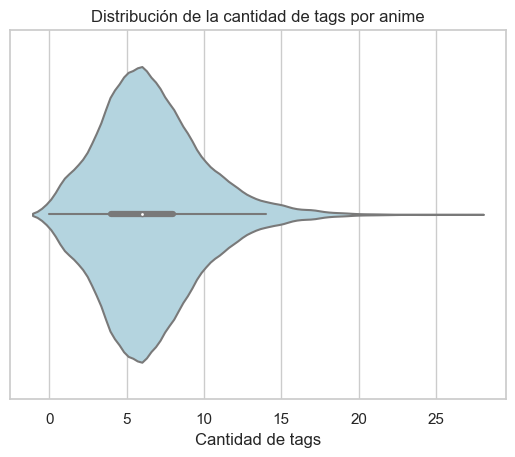

In [245]:
# Violin plot de la cantidad de tags por anime

# Crea un Violin Plot


sns.violinplot(x=unified_df["Cantidad de Tags"], color="lightblue")

# Etiqueta del eje x
plt.xlabel("Cantidad de tags")

# Título del gráfico
plt.title("Distribución de la cantidad de tags por anime")

# Mostrar el gráfico
plt.show()

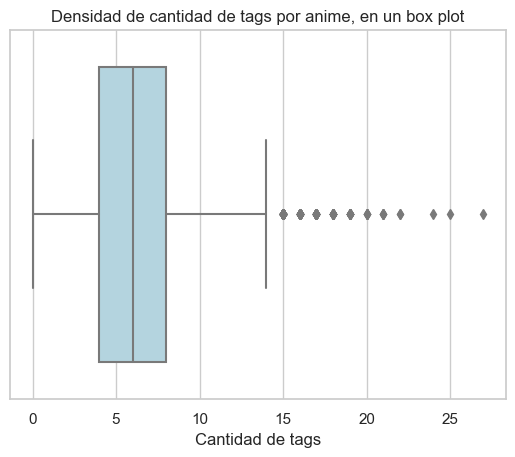

In [246]:
# Box plot de la cantidad de tags por anime

sns.boxplot(x=unified_df["Cantidad de Tags"], color="lightblue")

# Label del eje x
plt.xlabel("Cantidad de tags")

# Título del gráfico

plt.title("Densidad de cantidad de tags por anime, en un box plot")

# Mostrar el gráfico

plt.show()

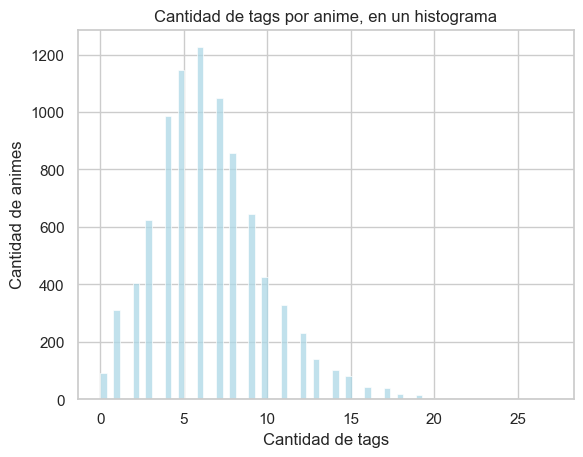

In [247]:
# Histograma que muestra la cantidad de tags por anime

sns.histplot(x=unified_df["Cantidad de Tags"], color="lightblue")

# Label del eje x
plt.xlabel("Cantidad de tags")

# Label del eje y
plt.ylabel("Cantidad de animes")

# Título del gráfico

plt.title("Cantidad de tags por anime, en un histograma")

# Mostrar el gráfico

plt.show()

Text(0.5, 1.0, 'Medidas de tendencia de la cantidad de tags por anime')

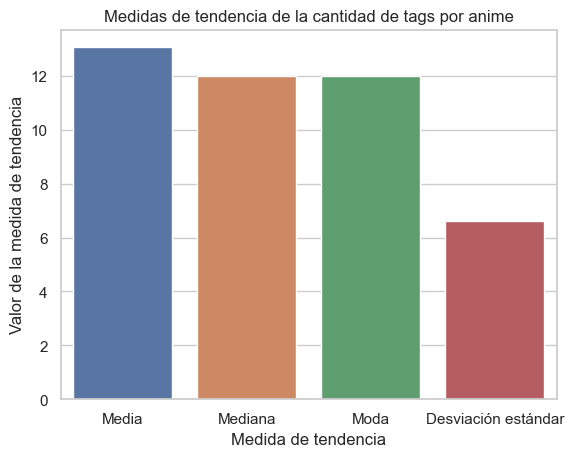

In [248]:
# Distribución en un gráfico de barras sobre distintas medidas de tendencia de la cantidad de tags
# por anime (media, mediana, moda, desviación estándar)

# Obtener la media, mediana, moda y desviación estándar de la cantidad de tags por anime

mean = unified_df.sum(axis=1).mean()
median = unified_df.sum(axis=1).median()
mode = unified_df.sum(axis=1).mode()[0]
std = unified_df.sum(axis=1).std()

# Crear el gráfico de barras

sns.barplot(
    x=["Media", "Mediana", "Moda", "Desviación estándar"], y=[mean, median, mode, std]
)

# Label del eje x

plt.xlabel("Medida de tendencia")

# Label del eje y

plt.ylabel("Valor de la medida de tendencia")

# Título del gráfico

plt.title("Medidas de tendencia de la cantidad de tags por anime")

In [249]:
print(
    f"Se obtuvo una media de {mean}, una mediana de {median}, una moda de {mode} y una desviación estándar de {std}. Si comparamos los valores, tenemos lo siguiente:"
)

if mean > median:
    print("\tLa media es mayor que la mediana")
elif mean < median:
    print("\tLa media es menor que la mediana")
if mean > mode:
    print("\tLa media es mayor que la moda")
elif mean < mode:
    print("\tLa media es menor que la moda")
if mean > std:
    print("\tLa media es mayor que la desviación estándar")
elif mean < std:
    print("\tLa media es menor que la desviación estándar")
if median > mode:
    print("\tLa mediana es mayor que la moda")
elif median < mode:
    print("\tLa mediana es menor que la moda")
if median > std:
    print("\tLa mediana es mayor que la desviación estándar")
elif median < std:
    print("\tLa mediana es menor que la desviación estándar")
if mode > std:
    print("\tLa moda es mayor que la desviación estándar")
elif mode < std:
    print("\tLa moda es menor que la desviación estándar")

Se obtuvo una media de 13.066119471044232, una mediana de 12.0, una moda de 12 y una desviación estándar de 6.627623727444057. Si comparamos los valores, tenemos lo siguiente:
	La media es mayor que la mediana
	La media es mayor que la moda
	La media es mayor que la desviación estándar
	La mediana es mayor que la desviación estándar
	La moda es mayor que la desviación estándar


In [265]:
# Dropear la columna "Cantidad de Tags" para no tener problemas en el futuro

unified_df.drop(columns=["Cantidad de Tags"], inplace=True)


### En Dataframe 3: `detalles_animes.csv`

#### Limpieza y transformación inicial de datos

A continuación, llevaremos a cabo la limpieza del DataFrame, centrándonos en uno de los objetivos definidos en la propuesta del proyecto: la identificación de los animes de culto o 'clásicos'. Además, estaremos atentos a posibles análisis adicionales que puedan surgir durante el proceso del EDA y que resulten útiles para el proyecto.

In [548]:
# Removemos columnas que podrían no ser esenciales al evaluar un anime de culto o que
# podrían estar implícitas en otras columnas clave.
detalles_animes_clean = detalles_animes.drop(
    columns=[
        "main_picture",
        "alternative_titles",
        "media_type",
        "start_season",
        "studios",
        "num_scoring_users",
    ]
)


In [549]:
# Convertimos estas columnas a tipo de dato fecha para darles un mejor uso posteriormente.
detalles_animes_clean["start_date"] = pd.to_datetime(
    detalles_animes_clean["start_date"], format="mixed"
)
detalles_animes_clean["end_date"] = pd.to_datetime(
    detalles_animes_clean["end_date"], format="mixed"
)

In [550]:
detalles_animes_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8978 entries, 0 to 8977
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   id              8978 non-null   int64         
 1   title           8978 non-null   object        
 2   start_date      8976 non-null   datetime64[ns]
 3   end_date        8977 non-null   datetime64[ns]
 4   synopsis        8900 non-null   object        
 5   mean            8908 non-null   float64       
 6   rank            8474 non-null   float64       
 7   popularity      8978 non-null   int64         
 8   num_list_users  8978 non-null   int64         
 9   status          8978 non-null   object        
 10  num_episodes    8978 non-null   int64         
dtypes: datetime64[ns](2), float64(2), int64(4), object(3)
memory usage: 771.7+ KB


In [551]:
# Verificamos si es que existen duplicados en el DataFrame entero y cuántos en caso de que existan.
# Realizaremos el mismo proceso para los datos nulos.

print("Datos duplicados:", detalles_animes_clean.duplicated().any())
print("N° de datos duplicados:", detalles_animes_clean.duplicated().sum())
print("Datos nulos: ", detalles_animes_clean.isnull().any().any())
print("N° de datos nulos: ", detalles_animes_clean.isnull().sum().sum())


Datos duplicados: False
N° de datos duplicados: 0
Datos nulos:  True
N° de datos nulos:  655


In [552]:
detalles_animes_clean.isnull().sum()

id                  0
title               0
start_date          2
end_date            1
synopsis           78
mean               70
rank              504
popularity          0
num_list_users      0
status              0
num_episodes        0
dtype: int64

In [553]:
filas_nulas_star_date = detalles_animes_clean[
    detalles_animes_clean["start_date"].isnull()
]
filas_nulas_star_date

id                  title start_date   end_date  \
2696  33187       Katsudou Shashin        NaT        NaT   
8550  30840  Many Things SD Gundam        NaT 2011-07-22   

                                               synopsis  mean     rank  \
2696  A young boy dressed in sailor attire and a bri...  5.48  11422.0   
8550     Specials included on SD Gundam Collection Box.  5.00  12520.0   

      popularity  num_list_users           status  num_episodes  
2696        6860            7894  finished_airing             1  
8550       12719            1085  finished_airing             2

In [554]:
detalles_animes_clean = detalles_animes_clean.drop(2696)

In [555]:
detalles_animes_clean["start_date"][8550] = np.datetime64("2011-01-01")
detalles_animes_clean.iloc[8550]["start_date"]


C:\Users\mativ\AppData\Local\Temp\ipykernel_39844\2946136741.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  detalles_animes_clean["start_date"][8550] = np.datetime64("2011-01-01")


Timestamp('2015-04-07 00:00:00')

Identificamos un anime que carece tanto de fecha de inicio como de fecha de finalización de emisión. Dado que no contamos con información completa sobre su periodo de emisión, hemos decidido no incluir este anime en nuestro análisis. No obstante, hay otro anime que únicamente carece de la fecha de inicio. Optamos por incluir este último en nuestro análisis, ya que pudimos obtener la información faltante de manera verificada a través de este [sitio](https://gachax.com/anime/db/many-things-sd-gundam/).

In [556]:
filas_nulas_mean = detalles_animes_clean[detalles_animes_clean["mean"].isnull()]
print(
    "N° de animes con valores nulos en la columna de promedio:", len(filas_nulas_mean)
)


N° de animes con valores nulos en la columna de promedio: 70


In [557]:
filas_nulas_rank = detalles_animes_clean[detalles_animes_clean["rank"].isnull()]
print("N° de animes con valores nulos en la columna de ranking:", len(filas_nulas_rank))

N° de animes con valores nulos en la columna de ranking: 504


In [558]:
nulos_mean_rank = detalles_animes_clean[
    detalles_animes_clean[["rank", "mean"]].isnull().all(axis=1)
]
print(
    "N° de animes con valores nulos en la columna de ranking y promedio:",
    len(nulos_mean_rank),
)

N° de animes con valores nulos en la columna de ranking y promedio: 27


In [559]:
detalles_animes_clean = detalles_animes_clean.dropna(subset=["mean"])
detalles_animes_clean = detalles_animes_clean.dropna(subset=["rank"])


Después de investigar el funcionamiento del sistema de puntuaciones de MAL, que se detalla en el siguiente [enlace](https://myanimelist.net/info.php?go=topanime), llegamos a la conclusión de que la presencia de valores nulos en las columnas 'mean' y 'rank' podría tener un impacto en la fiabilidad de la puntuación. Esto podría indicar que la entrada en cuestión no ha recibido suficientes puntuaciones para calcular una puntuación ponderada confiable, posiblemente debido a que es menos conocida o reciente. Dado que nuestro análisis se centra en evaluar la calidad general de los animes, consideramos útil excluir las entradas con valores nulos para obtener una visión más precisa.

In [560]:
filas_nulas_synopsis = detalles_animes_clean[detalles_animes_clean["synopsis"].isnull()]
filas_nulas_synopsis.head()


id                                              title start_date  \
523   33308  Tantei Opera Milky Holmes: Fun Fun Party Night... 2016-12-31   
1177  34032                      King of Prism: Pride the Hero 2017-06-10   
1661  34552                                  Dream Festival! R 2017-08-23   
2024  35081    The iDOLM@STER Million Live! 4-shuunen Kinen PV 2017-03-12   
2026  33035            Yuyushiki: Komarasetari, Komarasaretari 2017-02-22   

       end_date synopsis  mean    rank  popularity  num_list_users  \
523  2016-12-31      NaN  6.67  5689.0       10355            2410   
1177 2017-06-10      NaN  6.87  4715.0        8505            4562   
1661 2017-11-08      NaN  6.83  4901.0        8048            5300   
2024 2017-03-12      NaN  6.52  6552.0       10112            2600   
2026 2017-02-22      NaN  7.31  2589.0        5647           12661   

               status  num_episodes  
523   finished_airing             1  
1177  finished_airing             1  
1661  finished_airing            12  
2024  finished_airing             1  
2026  finished_airing             1

In [561]:
print("N° de animes sin sinopsis:", len(filas_nulas_synopsis))

N° de animes sin sinopsis: 57


In [562]:
print(
    "Promedio máximo del conjunto de animes sin sinopsis",
    filas_nulas_synopsis["mean"].max(),
)


Promedio máximo del conjunto de animes sin sinopsis 7.78


Dado que hay animes sin sinopsis, se podría contemplar un enfoque diferenciado. Por un lado,
podríamos incluir todos los animes en el análisis, mientras que, por otro lado, podríamos
centrarnos únicamente en aquellos que cuentan con sinopsis. Sin embargo, dado que hay 78 animes sin
sinopsis y en análisis posteriores utilizaremos un umbral de calificación superior a 8, excluyendo
así a estos animes, hemos decidido eliminarlos del conjunto de datos para esta parte.

#### La Evolución Temporal de Calificaciones y Popularidad de los animes en MAL

In [563]:
"""
Definimos umbral del promedio de calificaciones y en base a este umbral definiremos el de popularidad.
Esto debido a que la variable de popularidad no suele ser un factor determinante al momento de
definir si un anime es de culto o no.
"""

umbral_calificacion_alta = 8.0
umbral_popularidad_alta = 0

while True:
    animes_alta_calificacion = detalles_animes_clean[
        detalles_animes_clean["mean"] >= umbral_calificacion_alta
    ]
    animes_alta_popularidad = detalles_animes_clean[
        detalles_animes_clean["popularity"] <= umbral_popularidad_alta
    ]
    if len(animes_alta_calificacion) == len(animes_alta_popularidad):
        umbral_popularidad_alta = umbral_popularidad_alta
        break
    else:
        umbral_popularidad_alta += 1

print("N° de animes de cada conjunto:", len(animes_alta_calificacion))


N° de animes de cada conjunto: 597


In [564]:
# Unimos los conjuntos de animes filtrados posteriormente, para obtener entre ambos, animes
# que se destaquen en MAL y posiblemente potenciales candidatos a ser animes de culto.
animes_destacados = pd.merge(
    animes_alta_calificacion, animes_alta_popularidad, how="inner"
)
print("N° de animes destacados:", len(animes_destacados))


N° de animes destacados: 262


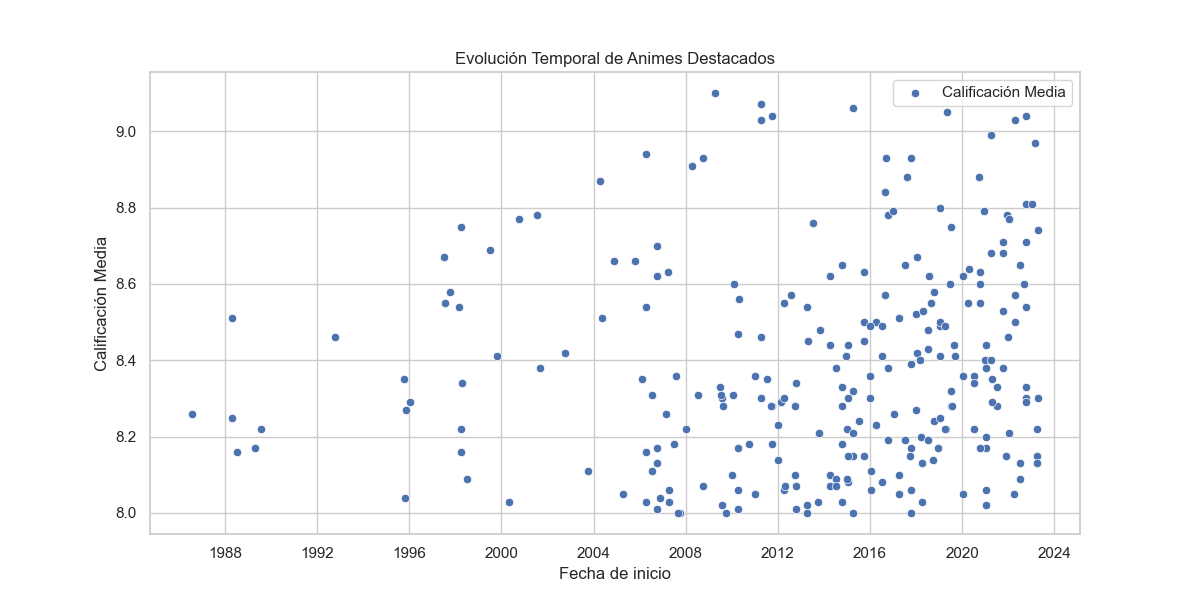

In [571]:
# Gráfico para evaluar la evolución temporal
plt.figure(figsize=(12, 6))
sns.scatterplot(
    x="start_date",
    y="mean",
    data=animes_destacados,
    marker="o",
    label="Calificación Media",
)
plt.title("Evolución Temporal de Animes Destacados")
plt.xlabel("Fecha de inicio")
plt.ylabel("Calificación Media")
plt.legend()
plt.show()


Al analizar el scatterplot, notamos que una considerable cantidad de los animes destacados tienen
fechas de inicio cercanas a la actualidad. Sin embargo, es crucial destacar que la condición de
'anime de culto' está estrechamente vinculada con la longevidad, así como el impacto que el anime
pueda tener en la sociedad y la conexión que logre establecer con la audiencia. Por lo tanto, no
podemos basarnos exclusivamente en aquellos con una calificación promedio más alta o con fechas de
inicio antiguas, ya que ambos aspectos deben converger para que un anime sea considerado de culto.
Por otro lado, la gráfica proporciona una visión general de la distribución temporal de estos
animes destacados, lo que nos ayuda a identificar posibles candidatos. 

#### Exploración de animes a través de las listas de usuarios

In [573]:
animes_destacados_por_listas = detalles_animes_clean.sort_values(
    by="num_list_users", ascending=False
)


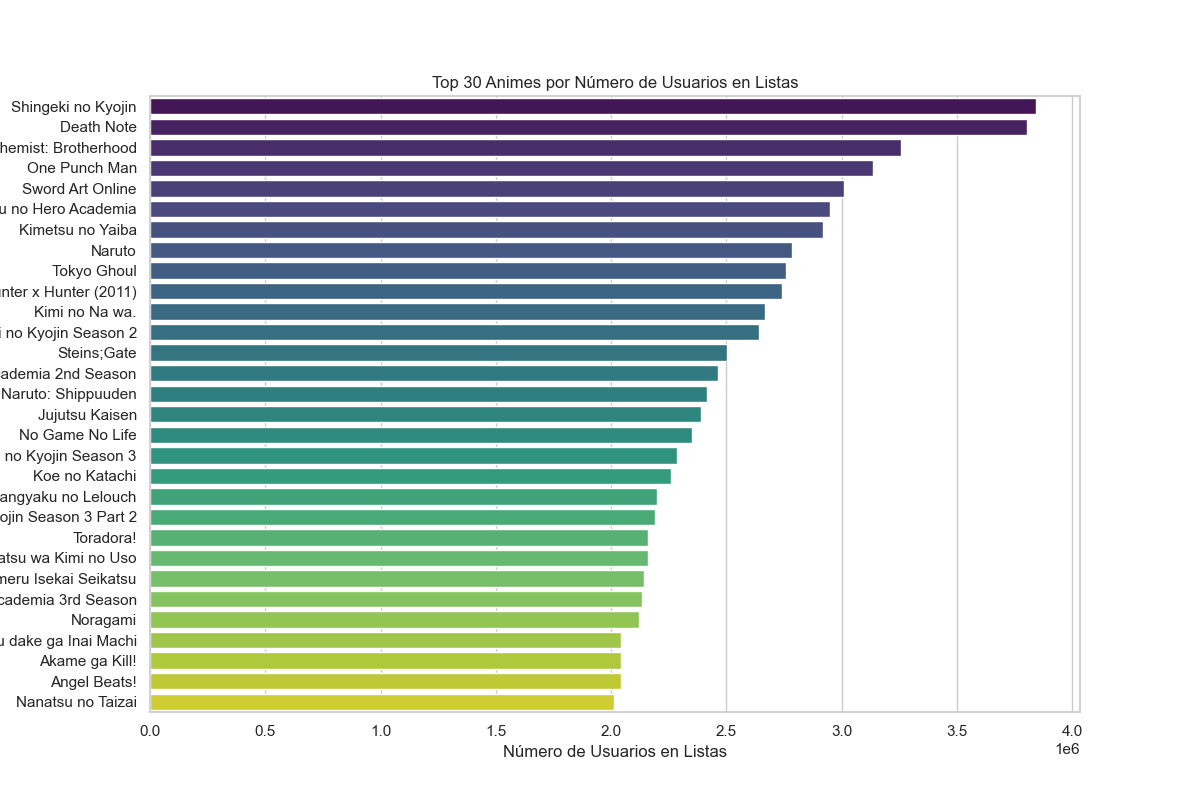

In [574]:
sns.set(style="whitegrid")

# Creamos el gráfico de barras
plt.figure(figsize=(12, 8))
barplot = sns.barplot(
    x="num_list_users",
    y="title",
    data=animes_destacados_por_listas.head(30),
    palette="viridis",
)
plt.title("Top 30 Animes por Número de Usuarios en Listas")
plt.xlabel("Número de Usuarios en Listas")
plt.ylabel("Título del Anime")
plt.show()


In [576]:
animes_destacados_final = pd.merge(
    animes_destacados_por_listas.head(100),
    animes_destacados,
    on=[
        "id",
        "title",
        "start_date",
        "end_date",
        "synopsis",
        "mean",
        "rank",
        "popularity",
        "num_list_users",
        "status",
        "num_episodes",
    ],
    how="inner",
)
animes_destacados_final.head()


id                             title start_date   end_date  \
0  16498                Shingeki no Kyojin 2013-04-07 2013-09-29   
1   1535                        Death Note 2006-10-04 2007-06-27   
2   5114  Fullmetal Alchemist: Brotherhood 2009-04-05 2010-07-04   
3  30276                     One Punch Man 2015-10-05 2015-12-21   
4  38000                  Kimetsu no Yaiba 2019-04-06 2019-09-28   

                                            synopsis  mean   rank  popularity  \
0  Centuries ago, mankind was slaughtered to near...  8.54  110.0           1   
1  Brutal murders, petty thefts, and senseless vi...  8.62   83.0           2   
2  After a horrific alchemy experiment goes wrong...  9.10    1.0           3   
3  The seemingly unimpressive Saitama has a rathe...  8.50  131.0           4   
4  Ever since the death of his father, the burden...  8.49  133.0           7   

   num_list_users           status  num_episodes  
0         3841111  finished_airing            25  
1         3804024  finished_airing            37  
2         3255493  finished_airing            64  
3         3134268  finished_airing            12  
4         2917758  finished_airing            26

In [577]:
# # Comprobamos si existe animes que siguen siendo trasmitidos
if any(status != "finished_airing" for status in animes_destacados_final["status"]):
    print("Hay animes que siguen siendo transmitidos.")
else:
    print("No existen animes que sigan en transmisión.")


No existen animes que sigan en transmisión.


A partir de lo anterior, se puede inferir que el estado de 'status' desempeñaría un papel crucial al determinar qué animes podrían considerarse de culto.

#### Exploración de Animes a través de su N° de Episodios

In [578]:
print("Descripción estadística del N° de episodios de cada anime:\n")
print(animes_destacados_final["num_episodes"].describe())


Descripción estadística del N° de episodios de cada anime:

count     68.000000
mean      29.602941
std       63.522975
min        1.000000
25%       12.000000
50%       19.000000
75%       25.000000
max      500.000000
Name: num_episodes, dtype: float64


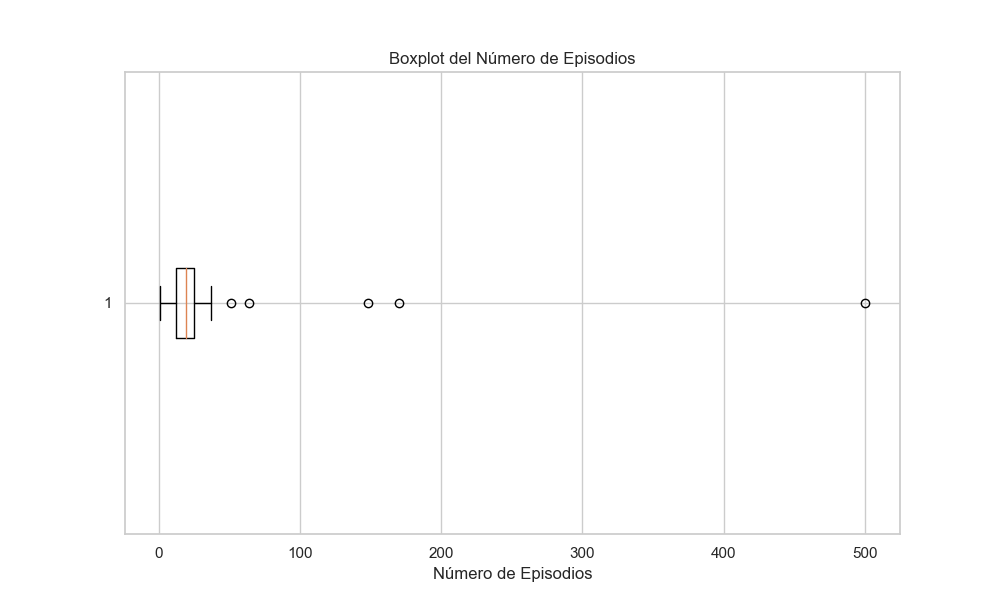

In [579]:
plt.figure(figsize=(10, 6))
plt.boxplot(animes_destacados_final["num_episodes"], vert=False)
plt.title("Boxplot del Número de Episodios")
plt.xlabel("Número de Episodios")
plt.show()


In [581]:
animes_destacados_final.sort_values(by="num_episodes", ascending=False).head(3)

id                   title start_date   end_date  \
10   1735      Naruto: Shippuuden 2007-02-15 2017-03-23   
41  34572            Black Clover 2017-10-03 2021-03-30   
5   11061  Hunter x Hunter (2011) 2011-10-02 2014-09-24   

                                             synopsis  mean   rank  \
10  It has been two and a half years since Naruto ...  8.26  292.0   
41  Asta and Yuno were abandoned at the same churc...  8.15  421.0   
5   Hunters devote themselves to accomplishing haz...  9.04    8.0   

    popularity  num_list_users           status  num_episodes  
10          15         2415660  finished_airing           500  
41          60         1608533  finished_airing           170  
5           10         2740243  finished_airing           148

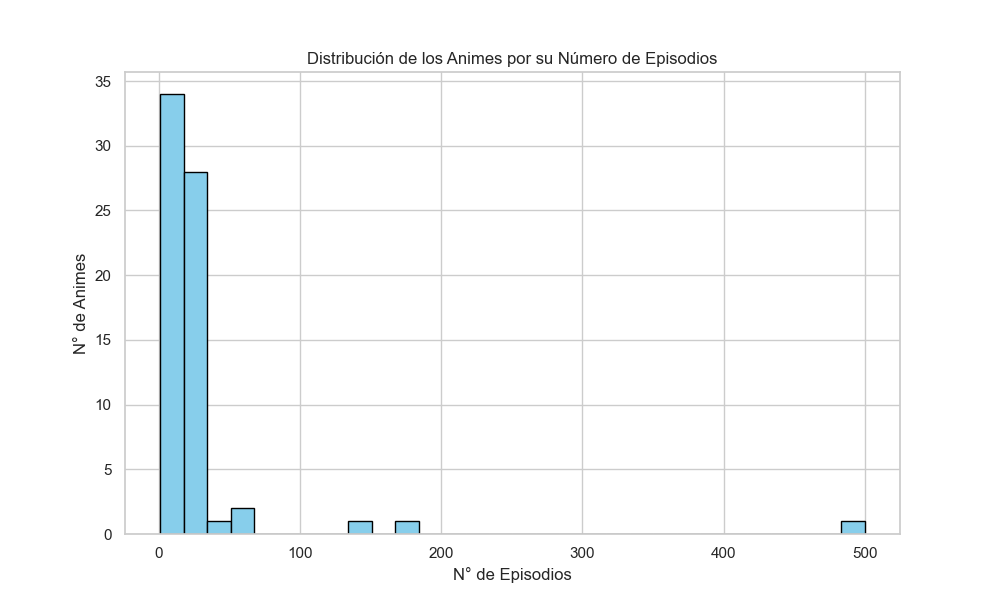

In [582]:
plt.figure(figsize=(10, 6))
plt.hist(
    animes_destacados_final["num_episodes"], bins=30, color="skyblue", edgecolor="black"
)
plt.title("Distribución de los Animes por su Número de Episodios")
plt.xlabel("N° de Episodios")
plt.ylabel("N° de Animes")
plt.show()


In [584]:
animes_destacados_final.sort_values(by="num_episodes").head(5)

id                                     title start_date   end_date  \
31    199             Sen to Chihiro no Kamikakushi 2001-07-20 2001-07-20   
14  28851                            Koe no Katachi 2016-09-17 2016-09-17   
48  40456  Kimetsu no Yaiba Movie: Mugen Ressha-hen 2020-10-16 2020-10-16   
66    431                       Howl no Ugoku Shiro 2004-11-20 2004-11-20   
6   32281                            Kimi no Na wa. 2016-08-26 2016-08-26   

                                             synopsis  mean  rank  popularity  \
31  Stubborn, spoiled, and naïve, 10-year-old Chih...  8.78  38.0          44   
14  As a wild youth, elementary school student Sho...  8.93  19.0          20   
48  After a string of mysterious disappearances be...  8.60  89.0          76   
66  That jumbled piece of architecture, that cacop...  8.66  69.0          99   
6   Mitsuha Miyamizu, a high school girl, yearns t...  8.84  27.0          11   

    num_list_users           status  num_episodes  
31         1806669  finished_airing             1  
14         2257629  finished_airing             1  
48         1472056  finished_airing             1  
66         1294537  finished_airing             1  
6          2667200  finished_airing             1

In [585]:
animes_a_eliminar = [1735, 34572, 11061, 32281, 40456, 28851, 199, 431]
animes_destacados_final = animes_destacados_final.loc[
    ~animes_destacados_final["id"].isin(animes_a_eliminar)
]


Identificamos la presencia de ciertos valores atípicos en la distribución, y es necesario excluirlo del análisis para evitar posibles distorsiones en los resultados.

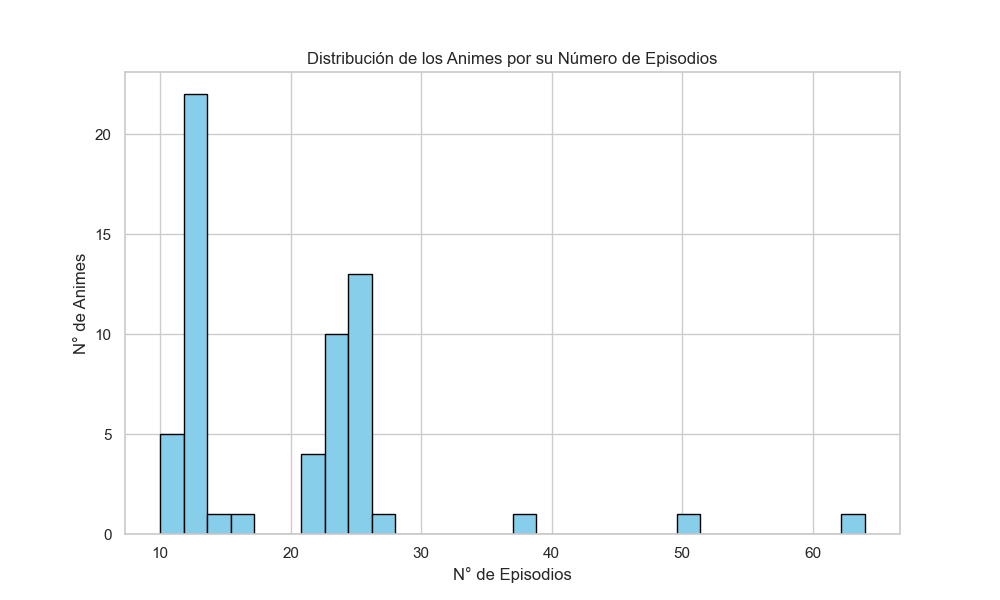

In [586]:
plt.figure(figsize=(10, 6))
plt.hist(
    animes_destacados_final["num_episodes"], bins=30, color="skyblue", edgecolor="black"
)
plt.title("Distribución de los Animes por su Número de Episodios")
plt.xlabel("N° de Episodios")
plt.ylabel("N° de Animes")
plt.show()


In [588]:
print("Nueva descripción estadística del N° de episodios de cada anime:\n")
print(animes_destacados_final["num_episodes"].describe())


Nueva descripción estadística del N° de episodios de cada anime:

count    60.000000
mean     19.833333
std       9.686907
min      10.000000
25%      12.000000
50%      22.000000
75%      25.000000
max      64.000000
Name: num_episodes, dtype: float64


In [589]:
# Posibles candidatos a ser animes de culto
animes_destacados_final.sort_values(by="end_date").head(10)


id                               title start_date   end_date  \
32    30             Neon Genesis Evangelion 1995-10-04 1996-03-27   
30     1                        Cowboy Bebop 1998-04-03 1999-04-24   
50   121                 Fullmetal Alchemist 2003-10-04 2004-10-02   
1   1535                          Death Note 2006-10-04 2007-06-27   
15  1575     Code Geass: Hangyaku no Lelouch 2006-10-06 2007-07-29   
44  2001          Tengen Toppa Gurren Lagann 2007-04-01 2007-09-30   
57  2167                             Clannad 2007-10-05 2008-03-28   
33  2904  Code Geass: Hangyaku no Lelouch R2 2008-04-06 2008-09-28   
17  4224                           Toradora! 2008-10-02 2009-03-26   
60  5081                      Bakemonogatari 2009-07-03 2010-06-25   

                                             synopsis  mean   rank  \
32  Fifteen years after a cataclysmic event known ...  8.35  208.0   
30  Crime is timeless. By the year 2071, humanity ...  8.75   44.0   
50  Edward Elric, a young, brilliant alchemist, ha...  8.11  460.0   
1   Brutal murders, petty thefts, and senseless vi...  8.62   83.0   
15  In the year 2010, the Holy Empire of Britannia...  8.70   56.0   
44  Simon and Kamina were born and raised in a dee...  8.63   78.0   
57  Tomoya Okazaki is a delinquent who finds life ...  8.00  614.0   
33  One year has passed since the Black Rebellion,...  8.91   20.0   
17  Ryuuji Takasu is a gentle high school student ...  8.07  519.0   
60  Koyomi Araragi, a third-year high school stude...  8.33  225.0   

    popularity  num_list_users           status  num_episodes  
32          45         1769372  finished_airing            26  
30          43         1818165  finished_airing            26  
50          78         1448079  finished_airing            51  
1            2         3804024  finished_airing            37  
15          21         2200278  finished_airing            25  
44          65         1578941  finished_airing            27  
57          87         1393009  finished_airing            23  
33          47         1739629  finished_airing            25  
17          23         2161851  finished_airing            25  
60          90         1376954  finished_airing            15

En conclusión, obtenemos una selección de posibles candidatos a ser considerados animes de culto. No obstante, es fundamental reconocer que la noción de "anime de culto" puede variar según las preferencias y percepciones individuales. Sin embargo, esta condición puede ser extrapolada a factores como el impacto, la longevidad y la conexión con la audiencia. Este análisis intenta proporcionar una visión integral que pueda contribuir a la comprensión de las características que distinguen a los animes de culto en la comunidad.

#### Medidas estadísticas y correlaciones

In [493]:
# Estadísticos básicos de las variables numéricas

detalles_animes_clean.describe()


id                     start_date  \
count   8430.000000                           8430   
mean   19393.528351  2009-01-15 18:09:49.323843328   
min        1.000000            1917-05-20 00:00:00   
25%     2927.250000            2004-01-16 00:00:00   
50%    14085.000000            2012-03-21 00:00:00   
75%    35075.750000            2017-07-07 00:00:00   
max    57034.000000            2023-11-02 00:00:00   
std    16838.428811                            NaN   

                            end_date         mean          rank    popularity  \
count                           8430  8430.000000   8430.000000   8430.000000   
mean   2009-05-14 23:32:40.142348800     6.841791   5073.282088   5229.122064   
min              1917-05-20 00:00:00     1.850000      1.000000      1.000000   
25%              2004-06-25 12:00:00     6.350000   2219.250000   2256.250000   
50%              2012-06-28 12:00:00     6.895000   4582.000000   4686.000000   
75%              2017-09-24 00:00:00     7.390000   7434.000000   7737.500000   
max              2023-11-05 00:00:00     9.100000  13247.000000  18576.000000   
std                              NaN     0.840330   3430.705245   3582.503684   

       num_list_users  num_episodes  
count    8.430000e+03   8430.000000  
mean     1.063498e+05     13.301423  
min      2.560000e+02      1.000000  
25%      5.793250e+03      1.000000  
50%      2.034950e+04      7.000000  
75%      8.265575e+04     13.000000  
max      3.841111e+06   1818.000000  
std      2.616611e+05     36.956576

Se observa que el promedio de start_date y end_date es similar, lo que indica que de la muestra de
animes obtenida una considerable parte de ellos se estrenan y terminan en el mismo año. 

Asimismo, puede decirse que dicho año promedio, 2009, es un año que no está tan lejano en el tiempo
como para que los animes sean muy antiguos, pero tampoco tan cercano como para que sean muy
recientes. De ello, se puede inferir que nuestra muestra de animes tiene animes de distintas épocas, lo que es bueno en
el sentido de que tenemos una muestra variada y no concentrada en una época en particular.

La cantidad de episodios promedio es cercana a 13, lo cual tiene sentido teniendo en cuenta que
existen varios animes que son de 12 episodios, y que son muy populares. Es curioso ver que la
mediana de cantidad de episodios es 7, lo cual puede deberse a que existen muchas películas en la
muestra (1 episodio), o series de 6 episodios o menos, pero, como, intuición general, es raro
encontrar series que justamente tengan 7 episodios. 

In [494]:
# ¿Cuántas animes tienen 7 episodios en detalle_animes_clean?

print(f"Existen {len(detalles_animes_clean[detalles_animes_clean['num_episodes'] == 7])} animes con 7 episodios.")

Existen 59 animes con 7 episodios.


In [495]:
# Pero con 6 y 12...

print(f"Existen {len(detalles_animes_clean[detalles_animes_clean['num_episodes'] == 6])} animes con 6 episodios.")

print(f"Existen {len(detalles_animes_clean[detalles_animes_clean['num_episodes'] == 12])} animes con 12 episodios.")

Existen 202 animes con 6 episodios.
Existen 1477 animes con 12 episodios.


In [496]:
# Correlaciones

detalles_animes_clean.corr(numeric_only=True)

id      mean      rank  popularity  num_list_users  \
id              1.000000  0.030298 -0.017374   -0.105813        0.084950   
mean            0.030298  1.000000 -0.972240   -0.598688        0.386866   
rank           -0.017374 -0.972240  1.000000    0.615478       -0.345996   
popularity     -0.105813 -0.598688  0.615478    1.000000       -0.476517   
num_list_users  0.084950  0.386866 -0.345996   -0.476517        1.000000   
num_episodes   -0.073256  0.086787 -0.085748   -0.035741        0.084235   

                num_episodes  
id                 -0.073256  
mean                0.086787  
rank               -0.085748  
popularity         -0.035741  
num_list_users      0.084235  
num_episodes        1.000000

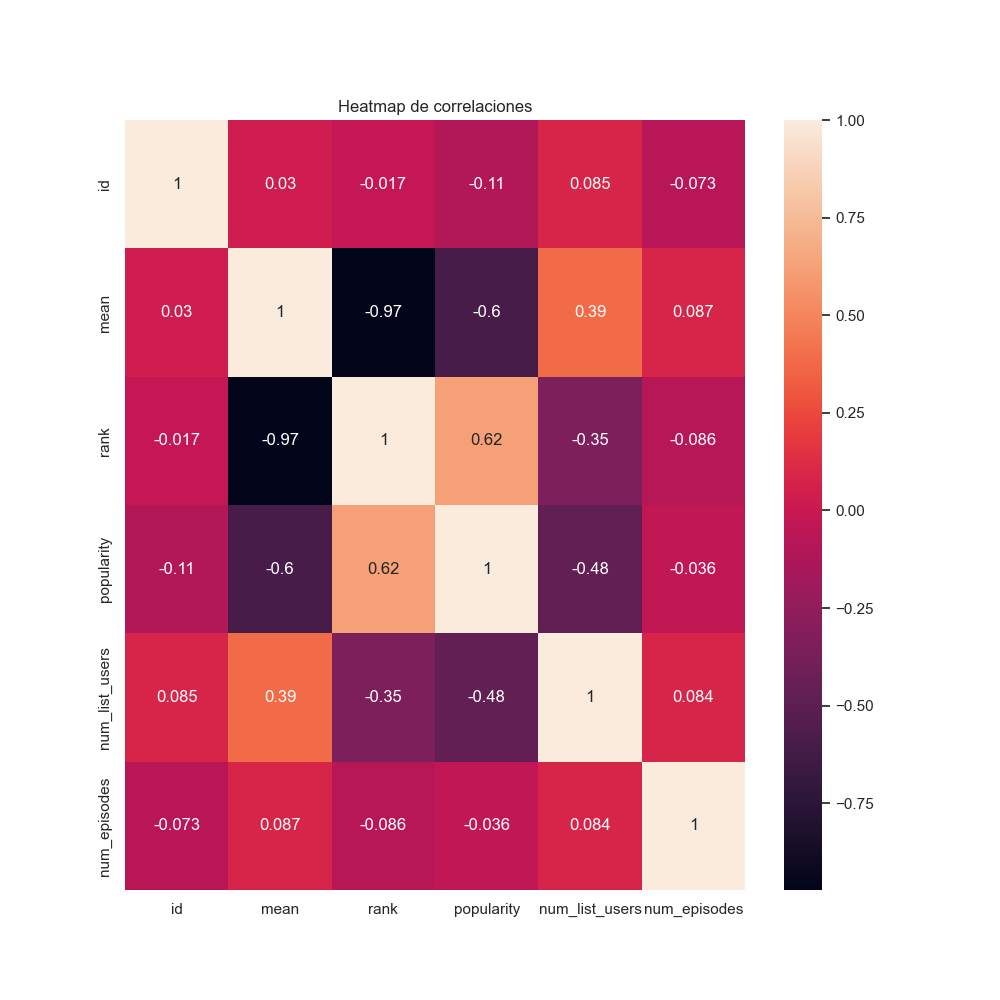

In [537]:
# En un heatmap

plt.figure(figsize=(10, 10))

sns.heatmap(detalles_animes_clean.corr(numeric_only=True), annot=True)

plt.title("Heatmap de correlaciones")

plt.show()

In [498]:
# Las mayores correlaciones positivas (sin contar la diagonal) ni tampoco repetidas

corr_subset = detalles_animes_clean.corr(numeric_only=True).unstack().sort_values(ascending=False)

# Eliminar las correlaciones de un tag consigo mismo

corr_subset = corr_subset[
    corr_subset.index.get_level_values(0) != corr_subset.index.get_level_values(1)
]

# Eliminar las correlaciones repetidas

corr_subset = corr_subset[
    corr_subset.index.get_level_values(0) < corr_subset.index.get_level_values(1)
]

# Mostrar el top 5

print("Top 5 de correlaciones positivas:")

for i, (tags, corr) in enumerate(corr_subset.head(5).items()):
    tag1, tag2 = tags
    print(f"\t{i+1}. {tag1} y {tag2} tienen una correlación de {corr}")
    

Top 5 de correlaciones positivas:
	1. popularity y rank tienen una correlación de 0.615477529234586
	2. mean y num_list_users tienen una correlación de 0.3868658798048275
	3. mean y num_episodes tienen una correlación de 0.08678688612157567
	4. id y num_list_users tienen una correlación de 0.08495045752471574
	5. num_episodes y num_list_users tienen una correlación de 0.08423467338298227


Se observa que existe cierta correlación positiva entre la popularidad y la calificación promedio,
lo que indica que los animes más populares tienden a una mayor posición en el ranking de MAL. En
sí, ello induce a pensar que la popularidad no se condice con la calidad de un anime en ojos del
público. 

In [499]:
# Las mayores correlaciones negativas (sin contar la diagonal) ni tampoco repetidas

corr_subset = (
    detalles_animes_clean.corr(numeric_only=True).unstack().sort_values(ascending=True)
)

# Eliminar las correlaciones de un tag consigo mismo

corr_subset = corr_subset[
    corr_subset.index.get_level_values(0) != corr_subset.index.get_level_values(1)
]

# Eliminar las correlaciones repetidas

corr_subset = corr_subset[
    corr_subset.index.get_level_values(0) < corr_subset.index.get_level_values(1)
]

# Mostrar el top 5

print("Top 5 de correlaciones negativas:")

for i, (tags, corr) in enumerate(corr_subset.head(5).items()):
    tag1, tag2 = tags
    print(f"\t{i+1}. {tag1} y {tag2} tienen una correlación de {corr}")

Top 5 de correlaciones negativas:
	1. mean y rank tienen una correlación de -0.9722404849084032
	2. mean y popularity tienen una correlación de -0.598688269090336
	3. num_list_users y popularity tienen una correlación de -0.4765167826370011
	4. num_list_users y rank tienen una correlación de -0.34599567674188575
	5. id y popularity tienen una correlación de -0.10581281582217215


Tiene lógica que mean y rank tengan una correlación negativa, dado que por contrucción apuntan a lo
opuesto. Un anime con el mayor promedio de calificación posible, 10, debería estar en el primer
lugar del ranking, y viceversa.

Siguiendo lo descrito con las correlaciones anteriores, tiene sentido que la popularidad y mean
tengan cierta correlación negativa, pues, si un anime es muy popular, es probable que tenga muchas
calificaciones, y, por ende, su promedio de calificación sea más cercano a la media de los usuarios
de MAL, que es aproximadamente 6.8. 

Al menos con estos datos, se observa directamente entonces que
existe una anti-correlación entre la popularidad y la calidad de un anime, lo que es interesante. 

## Análisis de datos:

### Introducción del clustering (recapitulación de la propuesta)

Para este proyecto, la herramienta estelar y basal que se usará es el clustering. Pero… ¿en qué consiste
el clustering? Buscando en internet se encontró una muy buena y clara definición escrita por Joaquín
Amat Rodrigo, un sénior Data Scientist español que cuenta con una web de divulgación de su área
bastante completa e informativa.

* *“El término clustering hace referencia a un amplio abanico de técnicas cuya finalidad es
encontrar patrones o grupos (clusters) dentro de un conjunto de observaciones. Las
particiones se establecen de forma que, las observaciones que están dentro de un mismo
grupo son similares entre ellas y distintas a las observaciones de otros grupos. Se trata
de un método de aprendizaje no supervisado (unsupervised), ya que el proceso no tiene
en cuenta a qué grupo pertenece realmente cada observación (si es que existe tal
información). Esta característica es la que diferencia al clustering de los métodos de
clasificación en el que sí emplea la verdadera clasificación durante su entrenamiento.”*
(Amat Rodrigo, 2020)

Como nuestra intención es precisamente encontrar conjuntos de usuarios similares de MyAnimeList,
es sumamente razonable que utilicemos dicha herramienta, la cual se encuentra implementada en la
librería scikit-learn de Python. En su página web, se describen los distintos algoritmos de clustering
que se pueden aplicar, mas se reconoce que en esta etapa del proyecto se desconoce cuál finalmente
se llegará a ocupar. Creemos que todavía nos falta el conocimiento necesario para responder dicha
interrogante y, además, solamente luego de realizar un análisis exhaustivo a los datos del trabajo se
podrá tomar una verdadera decisión más informada y consciente respecto a ello. Menciónese que
dicha librería también podrá sernos útil en el caso de que veamos conveniente realizar regresiones.
Primeramente, nuestro plan de proyecto parte con el paso de reunir los datos necesarios que
necesitamos para el cumplimiento de nuestros objetivos. Veamos que la fuente original de nuestros
datos se puede encontrar en sitios web, y, más específicamente, la data de MAL es factible de conseguir
fundamentalmente utilizando su API oficial, mientras que la data de Anime-Planet se tendrá que
conseguir bajo web scraping. Para estas labores, se utilizarán las librerías de pandas (para crear los
dataframes), requests y BeautifulSoup (obtención de información). Sin embargo, plantéese que un
inconveniente el cual tendremos que enfrentar es el hecho de que no es muy viable conseguir en un
reducido tiempo la data de la lista de usuarios de los más de 15 millones de usuarios de MyAnimeList.
Por lo tanto, se necesitará antes determinar una muestra aleatoria de los usuarios, y para ello una
posibilidad es usar la librería matemática de Numpy. Ya con todos los datos recopilados, puede pasarse
a la siguiente etapa.

Segundamente, lo elemental que debemos realizar para nuestro proyecto es una limpieza y
exploración de los datos que hayamos recolectado. Esto, es especialmente relevante teniendo en
cuenta el contexto de que los datos que trabajaremos serán obtenidos en base a la utilización de una
API y web scraping, y puede que en ambos procesos existan fallas inherentes en los valores extraídos
o una cantidad importante de información nula. Es nuestra responsabilidad revisar atenta y
minuciosamente cualquier tipo de desperfecto en dichos datos para corregirlos; así como igualmente
descartar posible información que lleguemos a considerar innecesaria y podría sobrecargar la carga
computacional asociada a los algoritmos que se usarán; disminuyendo y entorpeciendo nuestro
avance en el proyecto.


Terceramente, se piensa realizar lo ya mencionado, el susodicho clustering. De acuerdo con sus
resultados, se analizará cuál (si existe) es un nombre adecuado para cada grupo generado; viendo si
reúne las características habituales que siguen las comunidades de fans de la animación (gusto o
interés por una estética (temáticas) en concreto y/o juicio más o menos severo con respecto a lo
pensado de la calidad de las obras visualizadas).

----------------------------------------------------------------------------------------------------------------------------

Dicho texto, extraído de la propuesta de proyecto, efectivamente logró ser realidad. En específico,
la parte de descargar la información vía web scraping fue la más compleja de todas, y ciertamente
fue considerablemente lenta en general para la cantidad de información que se quería obtener.
Consideramos cierto eso de que cerca del 80% de tiempo invertido en el proyecto fue en la extracción de
datos, y el 20% restante en el análisis de estos orientado a la obtención de resultados.

----------------------------------------------------------------------------------------------------------------------------

En resumidas cuentas, se optó por utilizar clustering para este proyecto, dado que es un algoritmo
no supervisado (no contamos con labels definitivas de los grupos de usuarios), y es perfecto para
nuestros objetivos y la data que tenemos. 

Nótese, como comentario aparte, de que en el dataframe
construido a posteriori todas las columnas presentan la misma escala (de 0 a 1), por lo que no es
necesario realizar una estandarización de los datos. De hecho, leyendo en internet se llegó a que
no suele ser una buena idea estandarizar los datos cuando se presenta este caso. 

De dicha manera, podremos encontrar grupos de usuarios
dísimiles entre sí (inter), y que tengan características en común (intra).

### Breve inciso de PCA

Para este proyecto, se decidió utilizar PCA para reducir la dimensionalidad de los datos, y así
poder adecuadamente realizar un clustering, con una reducida carga computacional, evitando los
fenómenos asociados a la maldición de dimensión.  

También, el hecho de contar con 2 o 3 componentes principales permite visualizar mejor los datos, ya sea en 2D o 3D,
y así poder entender mejor los resultados del clustering, a modo de determinar la separación
relativa entre los clusters obtenidos. Una vez realizado el PCA, asimismo, se tratará de determinar
la significancia de cada componente principal, y así poder determinar qué variables son las más
importantes para el clustering. Ello, ciertamente, si se ve lo como lo más efectivo; también se
harán pruebas con diferentes cantidades de componentes principales, y se verá cuál es la que mejor
logra separar los clusters.

De igual manera, PCA ayuda a eliminar una posible multicolinealidad entre las variables, que, en
base a nuestro análisis exploratorio previo, es muy probable que exista. Se dio cuenta que hay una
gran cantidad de tags que están muy correlacionados entre sí, y ello puede ser un problema para el
adecuado funcionamiento de los algoritmos de clustering.

* *PCA constructs a set of uncorrelated directions that are ordered by their variance
(20, 21). In many cases, directions with the most variance are the most relevant to the
clustering. Our results indicate that removing features with low variance acts as a filter that
results in a distance metric that provides a more robust clustering... PCA is also useful as a visualization tool - it can
provide a low dimensional summary of the data (28), help detect outliers, and perform
quality control (20).* (Detecting stable clusters using principal component analysis, 2003)

### Trabajo Previo

A grandes rasgos, la idea es implementar una multiplicación matricial que dé cuenta de la
calificación (puntaje ponderado) que entrega cada usuario a los tags de Anime-Planet, en base a la calificación que entrega a cada anime.

In [500]:
# Rellenar users_df con 0.

users_df.fillna(0, inplace=True)
users_df = users_df.astype(pd.SparseDtype(np.int8, fill_value=0))

In [501]:
# Haciendo que tengan el mismo orden


unified_df.sort_index(inplace=True)

users_df.sort_index(inplace=True)

In [502]:
# Haciendo compatibles los dataframes antes de la multiplicacion matricial
intersect = set(unified_df.index).intersection(set(users_df.index))
unified_df = unified_df[unified_df.index.isin(intersect)]
users_df = users_df[users_df.index.isin(intersect)]
len(unified_df), len(users_df)

(8772, 8772)

In [503]:
# Multiplicación matricial
cluster_df = unified_df.T @ users_df

In [504]:
cluster_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 583 entries, Roommates to Gangs
Columns: 7793 entries, 39110:xxbladexx20 to 16656371:Aoto_uchiha10
dtypes: int32(7793)
memory usage: 17.4+ MB


In [505]:
cluster_df = cluster_df.astype(pd.SparseDtype(np.int32, fill_value=0))

In [506]:
cluster_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 583 entries, Roommates to Gangs
Columns: 7793 entries, 39110:xxbladexx20 to 16656371:Aoto_uchiha10
dtypes: Sparse[int32, 0](7793)
memory usage: 7.3+ MB


A continuación, se guarda el archivo de clusters en la carpeta `data/` para su posterior uso.

**Posteriormente lo cargaremos traspuesto**, pues asi los usuarios estarán en las filas, y los géneros en las columnas.

In [507]:
with open(os.path.join("data", "cluster_df.pickle"), "wb") as archivo:
    pickle.dump(cluster_df, archivo)

In [611]:
with open(os.path.join("data", "cluster_df.pickle"), "rb") as archivo:
    # Lo cargamos transpuesto para que sea más fácil de usar

    cluster_df = pickle.load(archivo).T

In [612]:
cluster_df

Roommates  Hosts  Criminals  Afterlife  \
39110:xxbladexx20               0      9          0          0   
216949:haijuta                  0      0         10          0   
246587:d3athzero               20     10         46         68   
107198:JayJay1401               0      0         38         27   
45036:Seleare                   0      0          0          0   
...                           ...    ...        ...        ...   
17197026:dumb_zoro_             0      0         10          0   
16617450:kotyboh                0      0          0          0   
16459755:Tiberjuice             0      0          0          0   
16965619:Watcher794_2           0      0          0          0   
16656371:Aoto_uchiha10          0      0         20         10   

                        French Revolution  Pet Shop  Okinawa  13th Century  \
39110:xxbladexx20                       0         0        0             0   
216949:haijuta                          0         0        0             0   
246587:d3athzero                        0         0        0             0   
107198:JayJay1401                       0         0        0             0   
45036:Seleare                           0         0        0             0   
...                                   ...       ...      ...           ...   
17197026:dumb_zoro_                     0         0        0             0   
16617450:kotyboh                        0         0        0             0   
16459755:Tiberjuice                     0         0        0             0   
16965619:Watcher794_2                   0         0        0             0   
16656371:Aoto_uchiha10                  0         0        0             0   

                        Slice of Life  Outer Space  ...  Self-Harm  \
39110:xxbladexx20                  70            0  ...          0   
216949:haijuta                      0           10  ...          0   
246587:d3athzero                  584          188  ...          0   
107198:JayJay1401                  66           14  ...          0   
45036:Seleare                       0            0  ...          0   
...                               ...          ...  ...        ...   
17197026:dumb_zoro_                 0            0  ...          0   
16617450:kotyboh                    0            0  ...          0   
16459755:Tiberjuice                18            0  ...          0   
16965619:Watcher794_2              70            0  ...          0   
16656371:Aoto_uchiha10             57           20  ...          0   

                        Board Games  Penguins  Single Parent  \
39110:xxbladexx20                 0         0              0   
216949:haijuta                    0         0              0   
246587:d3athzero                 54         0             40   
107198:JayJay1401                 0         0              0   
45036:Seleare                     0         0              0   
...                             ...       ...            ...   
17197026:dumb_zoro_               0         0              0   
16617450:kotyboh                  0         0              0   
16459755:Tiberjuice               0         0              0   
16965619:Watcher794_2             0         0              0   
16656371:Aoto_uchiha10            9         0              9   

                        Based on a Webtoon  BDSM  Fake Romance  Dragon Quest  \
39110:xxbladexx20                        0     0             0             0   
216949:haijuta                           0     0             0             0   
246587:d3athzero                        61     0            47             0   
107198:JayJay1401                        0     0             0             0   
45036:Seleare                            0     0             0             0   
...                                    ...   ...           ...           ...   
17197026:dumb_zoro_                      0     0             0             0   
16617450:kotyboh                         0  

In [510]:
# Para un mejor manejo de los datos.

cluster_df = cluster_df.astype(pd.SparseDtype(np.float64, fill_value=0))


Para poder hacer un buen análisis, necesitamos que los datos estén en la misma escala, en nuestro caso, haremos que cada usuario tenga sus gustos de género en porcentajes, tal que todos sus gustos sumen 100%.

**Se eliminan las columnas "Based on a Manga", "Original Work", "Based on a Light Novel", pues
estas causaban cierto nivel de ruido en el analisis, y no aportan mucho, pues no representan gusto,
si no que procedencia del contenido.**

In [511]:
cluster_df.drop(columns=["Based on a Manga", "Original Work", "Based on a Light Novel"], inplace=True)

cluster_df = cluster_df[
    cluster_df.sum(axis=1) > 0
]  # Muy importante, para no dividir por 0

# El porqué algunos tienen 0, es o porque el anime que vieron no tenía tags, o habían visto algún anime que no sobrevivio la unión MyAnimeList - AnimePlanet.
# Recordar que si se desea ver el proceso de unión, consultar procesar_data.ipynb


In [512]:
# Hacer que todas las filas sumen 1
cluster_df_normal = cluster_df.sparse.to_dense()
cluster_df_normal = cluster_df_normal.div(cluster_df_normal.sum(axis=1), axis=0)

# Técnica asistida por Copilot.
# Dataframe.div básicamente divide cada serie de una axis de un dataframe, por una serie con los mismos óndices de la axis.
# En este caso, se usa la axis de la fila (axis=0), y se divide por la serie de sumas de filas
# Y eso hace que todo sume 1.


In [513]:
# Por conveniencia, se guarda este dataframe normalizado.

with open(os.path.join("data", "cluster_df_normal.pickle"), "wb") as archivo:
    pickle.dump(cluster_df_normal, archivo)

### Carga del archivo de clusters versión normal

In [514]:
with open(os.path.join("data", "cluster_df_normal.pickle"), "rb") as archivo:
    cluster_df_normal = pickle.load(archivo)

### Encontrar parámetros correctos para el modelo.

Para hacer nuestro modelo de clustering, tendremos que seleccionar una cantidad de componentes principales, y una cantidad de grupos para el clustering.

Si se quiere ver el proceso, vean `iteraciones.ipynb`, el cual detalla las distintas iteraciones para las cuales tratamos de encontrar un buen modelo

In [517]:
# Transformar a formato numpy.

matriz = cluster_df_normal.to_numpy()

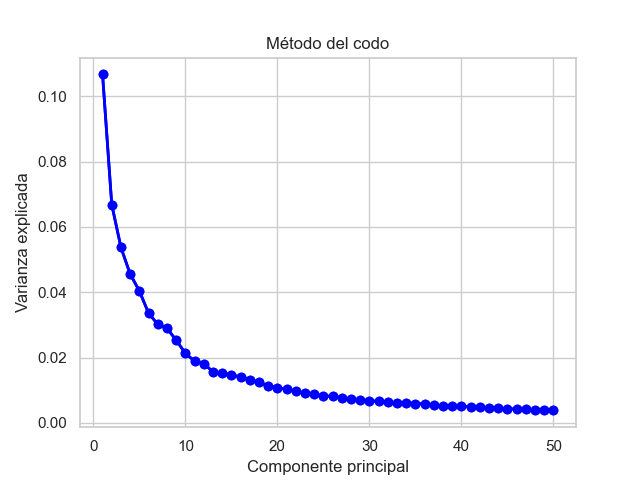

In [590]:
# Viendo cuantos componentes serían óptimos con el metodo del codo

pca = PCA(n_components=200)
pca.fit(matriz)

PC_values = np.arange(pca.n_components_) + 1
plt.plot(range(1,50 + 1), pca.explained_variance_ratio_[0:50], 'o-', linewidth=2, color='blue')
plt.title('Método del codo')
plt.xlabel('Componente principal')
plt.ylabel('Varianza explicada')
plt.show()

En este caso es un poco difícil de notar, pero con unos 7 ya empieza a ser menos efectivo; habría un segundo punto en los 10 componentes principales, pero con 7 uno ya debería estar más seguro.

**Sacado de:**

- https://www.statology.org/scree-plot-python/

In [592]:
# Haciendo la transformación.

pca = PCA(n_components=7)
pca.fit(matriz)
X = pca.transform(matriz)

In [423]:
inertia = []
kmax = 60

# Entrenamiento y evaluación
for i in range(1,kmax + 1):
    # modelo
    kmeans = KMeans(n_clusters=i, n_init='auto')
    nCluster = kmeans.fit(X)

    inertia.append(nCluster.inertia_)

Text(0.5, 1.0, 'K-means - Método del codo')

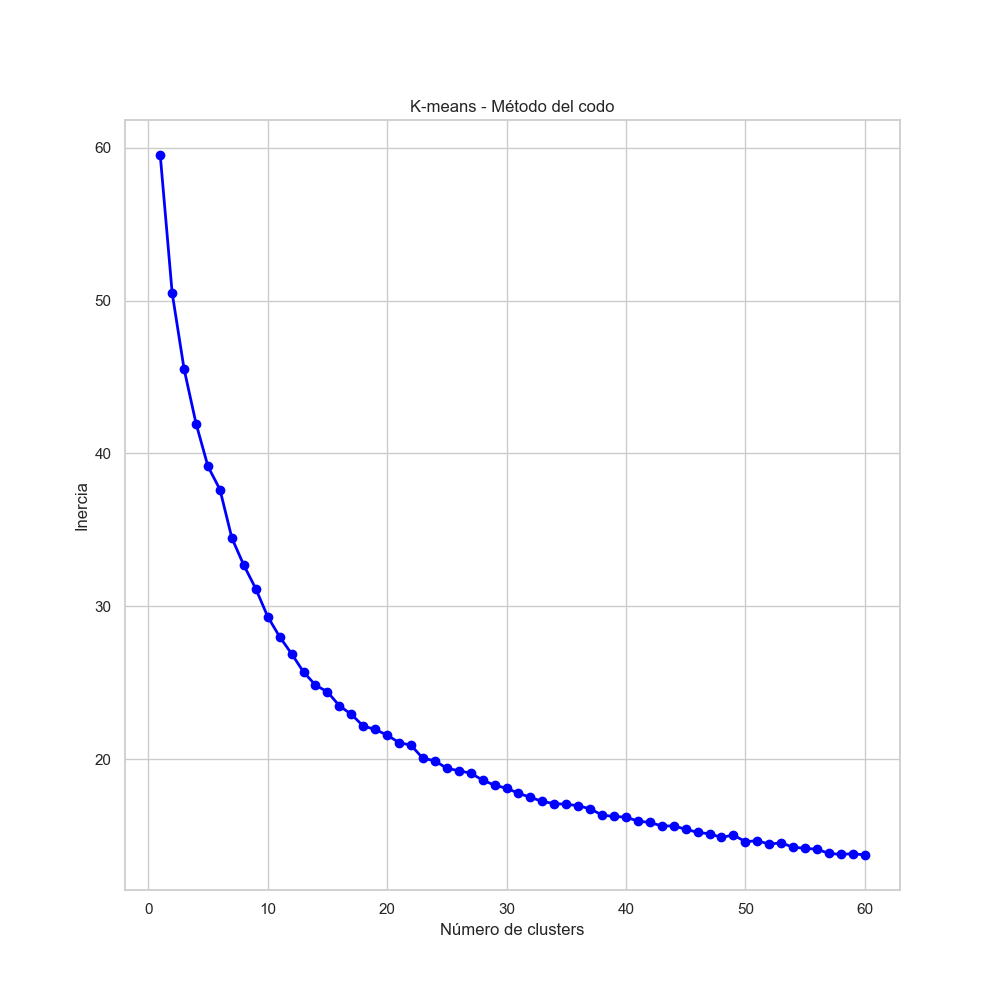

In [593]:
plt.close()
fig, ax = plt.subplots(1,1, figsize=(10,10))

ax.plot(range(1, kmax + 1), inertia, 'o-', linewidth=2, color='blue')
ax.set_xlabel('Número de clusters')
ax.set_ylabel('Inercia')
ax.set_title('K-means - Método del codo')

El método del codo sugiriría que lo óptimo serían entre 10 y 20 clusters; para estar en el rango alto se usarán 20.

El siguiente código fue extraído de la solución de la actividad 12.

In [594]:
# Seleccionando 20 grupos.
kmeans = KMeans(n_clusters=20, n_init='auto', random_state=2200)
kmeans.fit(X)
G = kmeans.predict(X)

In [595]:
# Creamos 2 dataframes nuevos, uno con los PCA, y otro añadiendo los grupos al original.

X_df = pd.DataFrame(X, index=cluster_df_normal.index, columns=[f"PC{i}" for i in range(1, 7 + 1)])
cluster_df_grupos = cluster_df_normal.copy()

X_df["grupo"] = G
cluster_df_grupos["grupo"] = G

# Revisemos los 10 géneros favoritos de cada grupo.
agrupado = cluster_df_grupos.groupby("grupo").mean()
for index, grupo in agrupado.iterrows():
    print(f"{index}:\n{grupo.sort_values(ascending=False).head(10)}\n")

0:
Action                         0.065563
Shounen                        0.055033
Fantasy                        0.039918
Explicit Violence              0.037952
Mature Themes                  0.031879
Drama                          0.029053
Horror                         0.028629
Dark Fantasy                   0.026215
Military                       0.022545
Overpowered Main Characters    0.021666
Name: 0, dtype: float64

1:
Comedy           0.068364
Romance          0.061660
School Life      0.055105
Drama            0.042303
Shounen          0.026666
Fantasy          0.024175
Action           0.020344
Seinen           0.019717
Slice of Life    0.016278
Shoujo           0.016275
Name: 1, dtype: float64

2:
Drama            0.038361
Action           0.036782
Fantasy          0.030168
Mature Themes    0.026620
Shounen          0.025775
Comedy           0.025635
School Life      0.024710
Romance          0.024227
Supernatural     0.022364
Violence         0.021680
Name: 2, dtype: float

Si es que ven "Output is truncated. View as a **scrollable element** or open in a **text editor**. Adjust cell output settings..."

Entonces abriendo "open in a text editor" deberían poderse ver los 10 gustos preferidos de cada
grupo. Igualmente se puede configurar esto en VSCode para que no se trunque el output.

Ahora veamos las métricas del modelo.

In [596]:
print("\nRespecto a df")
print(f"Silhouette score, más cercano a 1 es mejor: {silhouette_score(cluster_df_normal, G)}")
print(f"Davies Bouldin score, más cercano a 0 es mejor: {davies_bouldin_score(cluster_df_normal, G)}")
print(f"Calinski Harabasz score, mayor es mejor: {calinski_harabasz_score(cluster_df_normal, G)}")
print()
print("Respecto a PCA")
print(f"Silhouette score, más cercano a 1 es mejor: {silhouette_score(X, G)}")
print(f"Davies Bouldin score, más cercano a 0 es mejor: {davies_bouldin_score(X, G)}")
print(f"Calinski Harabasz score, mayor es mejor: {calinski_harabasz_score(X, G)}")


Respecto a df


Silhouette score, más cercano a 1 es mejor: -0.012186126186771663
Davies Bouldin score, más cercano a 0 es mejor: 2.819097674561143
Calinski Harabasz score, mayor es mejor: 158.8045901608344

Respecto a PCA
Silhouette score, más cercano a 1 es mejor: 0.12453969741789672
Davies Bouldin score, más cercano a 0 es mejor: 1.4186407942455481
Calinski Harabasz score, mayor es mejor: 727.1863005419513


Objetivamente hablando, debería ser un modelo bastante mediocre, pero no necesariamente es inútil.

Hagamos un gráfico 3D con los 3 primeros PCA (Usar esos PCA no afecta, debido al funcionamiento de este metodo).

Este usa %matplotlib widget, que requiere descargar una libreria.

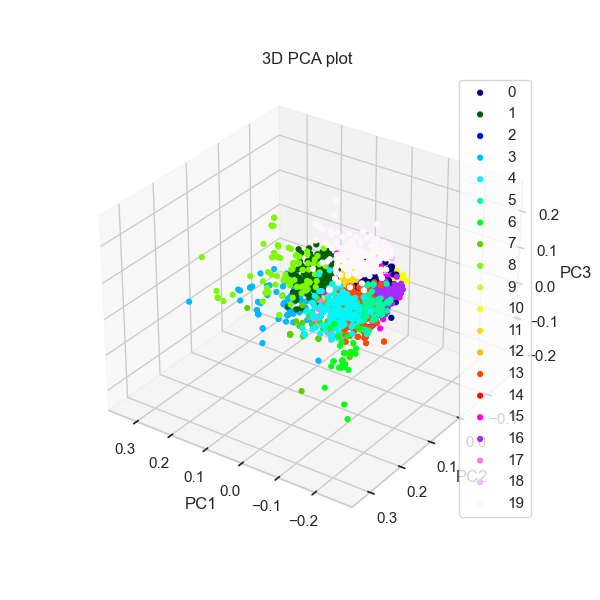

In [600]:
%matplotlib widget

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='3d')

Xax = X_df["PC1"]
Yax = X_df["PC2"]
Zax = X_df["PC3"]

Gax = X_df["grupo"]

norm=plt.Normalize(Gax.min(), Gax.max()) # El rango de valores para el colormap

for l in sorted(Gax.unique()):
    ix = (Gax == l)
    ax.scatter(Xax[ix], Yax[ix], Zax[ix], cmap="gist_ncar", norm=norm, c=Gax[ix], alpha=1, s=12, label=l)

ax.set_xlabel("PC1", fontsize=12)
ax.set_ylabel("PC2", fontsize=12)
ax.set_zlabel("PC3", fontsize=12)

ax.view_init(30, 125)
ax.legend()
plt.title("3D PCA plot")
plt.show()

# Se guarda la imagen 3D generada

fig.savefig(os.path.join("img", "3D_PCA_plot.png"))


In [601]:
plt.close()

Lo siguiente que podemos preguntar es:

- ¿Cuáles son los animes preferidos de cada grupo?

Y con eso podremos contestar la gran pregunta de este proyecto.

- ¿Como están polarizadas las distintas comunidades de anime?

In [602]:
grupos_generos = []
for index, grupo in agrupado.iterrows():
    grupos_generos.append(list(grupo.sort_values(ascending=False).head(20).index))
grupos_generos

[['Action',
  'Shounen',
  'Fantasy',
  'Explicit Violence',
  'Mature Themes',
  'Drama',
  'Horror',
  'Dark Fantasy',
  'Military',
  'Overpowered Main Characters',
  'Supernatural',
  'Cannibalism',
  'Violence',
  'Post-apocalyptic',
  'Outside World',
  'Isolated Society',
  'Adventure',
  'Suicide',
  'Comedy',
  'Psychological'],
 ['Comedy',
  'Romance',
  'School Life',
  'Drama',
  'Shounen',
  'Fantasy',
  'Action',
  'Seinen',
  'Slice of Life',
  'Shoujo',
  'Ecchi',
  'Supernatural',
  'School Club',
  'Harem',
  'Romantic Comedy',
  'Mature Themes',
  'Sci Fi',
  'Magic',
  'Non-Human Protagonists',
  'Coming of Age'],
 ['Drama',
  'Action',
  'Fantasy',
  'Mature Themes',
  'Shounen',
  'Comedy',
  'School Life',
  'Romance',
  'Supernatural',
  'Violence',
  'Psychological',
  'Sci Fi',
  'Adventure',
  'Explicit Violence',
  'Seinen',
  'Magic',
  'Suicide',
  'Physical Abuse',
  'Contemporary Fantasy',
  'Mystery'],
 ['Drama',
  'Romance',
  'School Life',
  'Comedy'

Ahora mismo nos conviene obtener de vuelta la version original de `unified_df`, con las tags, por eso lo vamos a abrir de nuevo, esta vez como `anime_tags`.

In [603]:
anime_tags = pd.read_csv(os.path.join("data", "unified_df.csv"))
anime_tags["Tags"] = anime_tags["Tags"].fillna("")
anime_tags["Tags"] = anime_tags["Tags"].apply(
    lambda x: [x.strip("'") for x in x.lstrip("[").rstrip("]").split(", ")]
)
anime_tags.drop(["URL", "Alts"], inplace=True, axis=1)
anime_tags

Anime  \
0                          Chiaki Kuriyama: "0"   
1     "Bungaku Shoujo" Kyou no Oyatsu: Hatsukoi   
2                      "Bungaku Shoujo" Memoire   
3                        "Bungaku Shoujo" Movie   
4                                        "Eiji"   
...                                         ...   
8767                   Crystal Sky of Yesterday   
8768                   Meychan: Zurui Maboroshi   
8769                      I've Always Liked You   
8770              I've Always Liked You Special   
8771                                    ēlDLIVE   

                                                   Tags     id  
0                                                    []  20707  
1     [Romance, Library, School Life, Based on a Lig...   7669  
2     [Drama, Romance, Episodic, School Life, Based ...   8481  
3     [Drama, Mystery, Romance, School Club, School ...   6408  
4     [Shounen, Sports, Boxing, Hand to Hand Combat,...   6076  
...                                                 ...    ...  
8767  [Drama, Romance, Chinese Animation, Coming of ...  37207  
8768                                                 []  52512  
8769  [Drama, Romance, Based on a Song, Childhood Fr...  31245  
8770  [Romance, Based on a Song, Love Confession, Sc...  36305  
8771  [Action, Comedy, Sci Fi, Shounen, Aliens, Body...  32878  

[8772 rows x 3 columns]

In [604]:
animes_representantes = []
for index, buscar in enumerate(grupos_generos):
    coincidencias = anime_tags.copy()
    coincidencias["score"] = anime_tags["Tags"].apply(lambda x: len(set(buscar).intersection(set(x))))
    coincidencias.sort_values(by="score", ascending=False, inplace=True)
    if coincidencias.shape[0] > 0:
        print(index)
        for anime in coincidencias["Anime"][0:10]:
            animes_representantes.append(anime)
            print(anime)
        print()

0
Attack on Titan
Attack on Titan 2nd Season
Attack on Titan Movie 1: Crimson Bow and Arrow
Attack on Titan Movie 2: The Wings of Freedom
Attack on Titan 3rd Season: Part II
Attack on Titan: Since That Day
Attack on Titan Movie 4: Chronicle
Attack on Titan 3rd Season
Attack on Titan: Ilse's Notebook
Attack on Titan The Final Season

1
To Love Ru: Darkness 2nd
To Love Ru: Darkness
To Love Ru
Motto To Love Ru
The Honor Student at Magic High School
To Love Ru: Darkness 2nd Specials
Trinity Seven
To Love Ru: Darkness 2nd OVA
O Maidens in Your Savage Season
Rent-a-Girlfriend

2
Re:ZERO: Starting Life in Another World
Made in Abyss: The Golden City of the Scorching Sun
Trigun Stampede
magicalgirlspecopsasuka
Tokyo Ghoul
Happy Sugar Life
To Your Eternity 2nd Season
Kemono Jihen
7 Seeds
Redo of Healer

3
Yamada-kun and the Seven Witches
Clannad
Bloom Into You
Toradora!
To Love Ru
My Teen Romantic Comedy SNAFU
My Teen Romantic Comedy SNAFU Climax
Kaguya-sama: Love Is War
My Teen Romantic Comedy

5
Fullmetal Alchemist
Fullmetal Alchemist: Brotherhood
Hunter x Hunter (2011)
The Seven Deadly Sins
The Heroic Legend of Arslan
Happy Sugar Life
Redo of Healer
Link Click 2nd Season
Re:ZERO: Starting Life in Another World
magicalgirlsite

6
Bleach
Fire Force
Naruto
Demon Slayer: Kimetsu no Yaiba
Fire Force 2nd Season
Naruto Shippuden
Hajime no Ippo: The Fighting!
Demon Slayer: Kimetsu no Yaiba - Mugen Train
Demon Slayer: Kimetsu no Yaiba Movie - Mugen Train
Dragon Ball: Plan to Destroy the Saiyajin

7
Slam Dunk
Eyeshield 21
My Hero Academia 2
Slam Dunk Movie 2
Slam Dunk Movie 3
Slam Dunk Movie 4
Slam Dunk Movie 1
Fullmetal Alchemist: Brotherhood
Big Windup!
My Hero Academia

8
Mahoraba: Heartful Days
Genshiken 2
Monthly Girls' Nozaki-kun
Azumanga Daioh
Lucky Star
Senryu Girl
Genshiken
Nisekoi
Toradora!
Sket Dance

9
7 Seeds
Made in Abyss: The Golden City of the Scorching Sun
Trigun Stampede
Inuyashiki: Last Hero
Good Night World
One-Punch Man 2
Re:ZERO: Starting Life in Another World
T

Aquí tenemos los gustos de cada grupo, nótese que algunos grupos son muy similares; esto significa que el modelo podría ser más óptimo.

Contemos rápidamente los animes más y menos polarizantes con un Counter.

In [605]:
contador = Counter(animes_representantes)
contador.most_common(10)

[('Re:ZERO: Starting Life in Another World', 7),
 ('Made in Abyss: The Golden City of the Scorching Sun', 5),
 ('Trigun Stampede', 5),
 ('Tokyo Ghoul', 4),
 ('Happy Sugar Life', 4),
 ('Redo of Healer', 4),
 ('My Hero Academia 2', 4),
 ('The Seven Deadly Sins', 4),
 ('To Your Eternity 2nd Season', 3),
 ('7 Seeds', 3)]

In [606]:
len(list(x for x in contador.items() if x[1] == 1))

96

Con esto hemos mostrado que el anime menos polarizante sería Re:ZERO: Starting Life in Another World, pero que hay muchos que polarizan, lo cual tendría sentido, pues algunos animes no son del gusto de todos.

También hay que tomar en cuenta que esto podría ser culpa del modelo, después de todo, alguien podría hacer algún mejor modelo para agruparlos.

O el mismo modelo para encontrar los más y menos polarizantes, se buscan aquellos que compartan más tags con el grupo, pero no necesariamente son los que mejor se adecuan a él.

Por ejemplo, el siguiente buscará cuales anime comparten al menos 5 tags con el grupo.

In [607]:
grupos_generos = []
for index, grupo in agrupado.iterrows():
    grupos_generos.append(list(grupo.sort_values(ascending=False).head(5).index)) # Esta vez 5 en vez de 20
grupos_generos

animes_representantes = []
for index, buscar in enumerate(grupos_generos):
    coincidencias = anime_tags[anime_tags["Tags"].apply(lambda x: set(buscar).issubset(set(x)))]
    if coincidencias.shape[0] > 0:
        print(index)
        for anime in coincidencias["Anime"]:
            animes_representantes.append(anime)
            print(anime)
        print()

0
Claymore
Noblesse: Awakening
Attack on Titan
Attack on Titan The Final Season
Attack on Titan The Final Season: The Final Chapters

1
The Quintessential Quintuplets
The Quintessential Quintuplets Movie
The Quintessential Quintuplets 2
The Quintessential Quintuplets∽
O Maidens in Your Savage Season
boysbe
Bottom-Tier Character Tomozaki
Rent-a-Girlfriend
Rent-a-Girlfriend Season 2
Mahoraba: Heartful Days
Midori Days
ORESUKI: Are you the only one who loves me?
Touch

2
Fullmetal Alchemist
Fullmetal Alchemist: Brotherhood
The Tale of the Outcasts
Attack on Titan The Final Season
Attack on Titan The Final Season: The Final Chapters

3
HENNEKO - The Hentai Prince and the Stony Cat

4
I'm Standing on a Million Lives
My Hero Academia
My Hero Academia 2
My Hero Academia 3
Fire Force
Gintama
Gintama: The Very Final
Demon Slayer: Kimetsu no Yaiba
Noragami
Trigun

5
I'm Standing on a Million Lives
Beastars 2
Fullmetal Alchemist
Fullmetal Alchemist: Brotherhood
Fullmetal Alchemist: Reflections
Hu

14
Death Note

15
Dai-Guard
Code Geass Movie: Lelouch of the Re;surrection
DARLING in the FRANXX
The Price of Smiles
Full Metal Panic! Movie 2: One Night Stand
galaxyfrauleinyunareturns
Martian Successor Nadesico
Mobile Suit Gundam F91
Mobile Suit Gundam: The 08th MS Team
Macross Frontier Movie 1: The False Songstress
Macross Frontier Movie 2: The Wings of Farewell
schwarzesmarken
starshiptroopers

16
Akame ga Kill!
Chainsaw Man
Claymore
peachboyriverside
Attack on Titan
Attack on Titan 2nd Season
Attack on Titan 3rd Season: Part II
Attack on Titan The Final Season
Attack on Titan The Final Season: The Final Chapters
Attack on Titan The Final Season: Part II

17
Beastars
Your lie in April

18
My Hero Academia 2
My Hero Academia 4
Fullmetal Alchemist
Fullmetal Alchemist: Brotherhood
Demon Slayer: Kimetsu no Yaiba Movie - Mugen Train
Demon Slayer: Kimetsu no Yaiba - Mugen Train
Tokyo Revengers
Tokyo Revengers: Seiya Kessen-hen
Zombie-Loan

19
Cosprayers
gestalt
Tower of Druaga: the Aegis

In [608]:
contador = Counter(animes_representantes)
print("polarizantes:", len(list(x for x in contador.items() if x[1] == 1)))
contador.most_common(10)

polarizantes: 112


[('My Hero Academia 2', 4),
 ('Attack on Titan The Final Season', 3),
 ('Attack on Titan The Final Season: The Final Chapters', 3),
 ('Fullmetal Alchemist', 3),
 ('Fullmetal Alchemist: Brotherhood', 3),
 ("I'm Standing on a Million Lives", 3),
 ('My Hero Academia', 3),
 ('Eyeshield 21', 3),
 ('Slam Dunk', 3),
 ('Claymore', 2)]

Y ahora el menos polarizante es "My Hero Academia 2"

¿Sería esto suficiente para hacer recomendaciones?

Depende, está guardada la información la cual especifica si algún usuario quiere ver algún anime, pero este método no necesariamente hace eso, lo que hace este método es ver los animes que identifican a cierto grupo; si uno deseara hacer un sistema de recomendación, KNN es mucho más acertado como método.

Ahora veamos cuántos anime han visto los distintos grupos.

In [617]:
stats_grupos = pd.DataFrame(users_df[users_df != 0].count())
stats_grupos = stats_grupos[stats_grupos.index.isin(cluster_df_grupos.index)]
stats_grupos["grupo"] = G
stats_grupos.rename(columns={0: "Cantidad"}, inplace=True)
stats_grupos.groupby("grupo").describe()

Cantidad                                                         
         count        mean         std  min   25%    50%     75%    max
grupo                                                                  
0        445.0   16.476404   12.818114  1.0   5.0   14.0   24.00   78.0
1        341.0   48.064516   69.804108  1.0   4.0   18.0   62.00  360.0
2        934.0   70.271949   87.686649  1.0  17.0   42.0   89.75  748.0
3        101.0    2.970297    4.733826  1.0   1.0    1.0    3.00   41.0
4        191.0    7.732984   12.272644  1.0   1.0    3.0    8.00  100.0
5        136.0    1.845588    1.349231  1.0   1.0    1.0    2.00   10.0
6         66.0    1.924242    1.685327  1.0   1.0    1.0    2.00   12.0
7         38.0    3.578947    3.859923  1.0   1.0    2.0    5.00   13.0
8         83.0    2.903614    4.626579  1.0   1.0    1.0    3.00   34.0
9        859.0   58.257276   63.778866  1.0  18.0   43.0   77.00  855.0
10       211.0    5.118483    5.689605  1.0   1.0    3.0    7.00   32.0
11      1022.0  128.825832  153.652390  1.0  27.0   76.0  171.75  988.0
12      1259.0  169.579031  184.807481  1.0  45.5  114.0  225.00  997.0
13       362.0   22.024862   31.294366  1.0   4.0    9.0   28.00  228.0
14        88.0    2.329545    1.491135  1.0   1.0    2.0    3.00    8.0
15       113.0    7.053097   17.847489  1.0   1.0    2.0    6.00  138.0
16       111.0    3.630631    3.241571  1.0   1.0    2.0    6.00   13.0
17       306.0   20.375817   35.726639  1.0   3.0    8.0   25.00  387.0
18       900.0   54.403333   65.909168  1.0  13.0   33.0   73.25  608.0
19       224.0    9.607143   16.742501  1.0   1.0    3.0   10.00  113.0

No solo se concluye que los distintos grupos tienen distintos tamaños, pero también contestamos una
de nuestras preguntas iniciales: 

¡Sí! los distintos grupos ven distintas cantidades de anime; en específico, los grupos 11 y 12 son
los que más ven anime, por una cantidad abrumadora.

En cambio, los grupos 5 y 6 son los que menos ven anime. 

## Resumen de los resultados

Se agruparán los resultados por las preguntas planteadas. 

### 1. ¿Cuáles grupos de usuarios se pueden formar a partir de las reviews que ellos hacen respecto a los animes vistos, los diferentes animes visualizados y sus tags asociados? ¿Siquiera existen esos grupos? En caso afirmativo, ¿qué nombres específicos representarían la esencia de los grupos hallados?


    


En la parte de clustering se armaron los grupos. En base a su inspección de características y tags
mejor evaluados, junto a los animes que reúnen dichas características, se llegó a lo siguiente.
Donde cada número representa su grupo respectivo como sale previamente.

0: Amantes de Shingeki y estándares

1: Acérrimos del romance y animes ligeros

2: Acérrimo Shonen serio

3: Casual Romance

4: Shonen casual no serio

5: Casual Shonen serio

6: Casual Naruto fan

7: Casual Spokon fan

8: Casual comedia escolar

9: Acérrimo Shonen moderno

10: Casual psicológico y ciencia ficción.

11: Acérrimos Shonen isekai-medieval

12: Acérrimo Shonen moderno con comedia

13: Estándar Acción fan

14: Casual Misterio fan

15: Casual mecha/espacial fan

16: Amantes de Shingeki casuales

17: Drama romántico estándar

18: Estándar Shonen moderno

19: Casual Isekai fan

Nótese que se hizo una distinción entre casual, estándar y accérro, donde casual es aquel que en
promedio ha visto menos de 10 animes, estándar es aquel que ha visto entre 10 y 50 animes, y
acérrimo es aquel que ha visto más de 50 animes en promedio.

Se encontró que ciertos grupos muestran devoción por un anime en particular, por lo que se vio
coherente llamar al grupo por el nombre del anime en cuestión.

### 2. Si existen los distintos grupos de MyAnimeList, ¿son suficientemente significativas las diferencias como para hacer buenas recomendaciones o predicciones de otras variables?

¿Son suficientemente significativas las diferencias?

Entre que sí, y que no. Hay algunos grupos que se parecen en varios modos, Sin embargo, hay algunos grupos muy característicos, los cuales siempre parecen hacerse presente en esta clase de análisis, por ejemplo, el fan del spokon, o el "Clásico de Japón".
Lo mas probable es que un modelo mucho más eficiente y con mayor cantidad de datos haría una mejor clasificacion.

¿...Son suficientemente significativas las diferencias como para hacer buenas recomendaciones o predicciones de otras variables?

Por temas de tiempo, solo podemos especular.

Quizá no sea posible, principalmente porque esta no es la idea de este modelo, pues si quisieras predecir otras variables, usarías una regresión lineal, pero también porque seria algo probablemente recursivo, los grupos más significativos no son tan grandes después de todo.

En ese sentido, nuestro modelo no responde ¿Cuál es un anime que te puede gustar?, si no que ¿Cuál es el anime que mas te caracteriza como usuario?

### 3. ¿Se pueden hallar patrones o tendencias regulares en las variables de los animes “clásicos” (entendiéndose que estos cuentan con una excepcional recepción positiva o fama o ambos)? ¿Cuáles son dichos patrones? ¿Tienen sentido con lo que normalmente se esperaría?


En la sección del análisis exploratorio de datos, en el dataframe de `detalles_animes.csv` se trató
de responder dicha pregunta. Se llegó a un dataframe de posibles candidatos, que ahora se grafica
y muestra a continuación, tras hacer ciertos pasos de antemano.

In [327]:
# Seleccionar los 10 animes más probables de ser considerados de culto, según el método
# implementado previamente. 

animes_destacados_final.sort_values(by="end_date").head(10)

id                               title start_date   end_date  \
32    30             Neon Genesis Evangelion 1995-10-04 1996-03-27   
30     1                        Cowboy Bebop 1998-04-03 1999-04-24   
50   121                 Fullmetal Alchemist 2003-10-04 2004-10-02   
1   1535                          Death Note 2006-10-04 2007-06-27   
15  1575     Code Geass: Hangyaku no Lelouch 2006-10-06 2007-07-29   
44  2001          Tengen Toppa Gurren Lagann 2007-04-01 2007-09-30   
57  2167                             Clannad 2007-10-05 2008-03-28   
33  2904  Code Geass: Hangyaku no Lelouch R2 2008-04-06 2008-09-28   
17  4224                           Toradora! 2008-10-02 2009-03-26   
60  5081                      Bakemonogatari 2009-07-03 2010-06-25   

                                             synopsis  mean   rank  \
32  Fifteen years after a cataclysmic event known ...  8.35  208.0   
30  Crime is timeless. By the year 2071, humanity ...  8.75   44.0   
50  Edward Elric, a young, brilliant alchemist, ha...  8.11  460.0   
1   Brutal murders, petty thefts, and senseless vi...  8.62   83.0   
15  In the year 2010, the Holy Empire of Britannia...  8.70   56.0   
44  Simon and Kamina were born and raised in a dee...  8.63   78.0   
57  Tomoya Okazaki is a delinquent who finds life ...  8.00  614.0   
33  One year has passed since the Black Rebellion,...  8.91   20.0   
17  Ryuuji Takasu is a gentle high school student ...  8.07  519.0   
60  Koyomi Araragi, a third-year high school stude...  8.33  225.0   

    popularity  num_list_users           status  num_episodes  
32          45         1769372  finished_airing            26  
30          43         1818165  finished_airing            26  
50          78         1448079  finished_airing            51  
1            2         3804024  finished_airing            37  
15          21         2200278  finished_airing            25  
44          65         1578941  finished_airing            27  
57          87         1393009  finished_airing            23  
33          47         1739629  finished_airing            25  
17          23         2161851  finished_airing            25  
60          90         1376954  finished_airing            15

In [332]:
imagenes = detalles_animes[["main_picture", "title"]]

imagenes

main_picture  \
0     {'medium': 'https://cdn.myanimelist.net/images...   
1     {'medium': 'https://cdn.myanimelist.net/images...   
2     {'medium': 'https://cdn.myanimelist.net/images...   
3     {'medium': 'https://cdn.myanimelist.net/images...   
4     {'medium': 'https://cdn.myanimelist.net/images...   
...                                                 ...   
8973  {'medium': 'https://cdn.myanimelist.net/images...   
8974  {'medium': 'https://cdn.myanimelist.net/images...   
8975  {'medium': 'https://cdn.myanimelist.net/images...   
8976  {'medium': 'https://cdn.myanimelist.net/images...   
8977  {'medium': 'https://cdn.myanimelist.net/images...   

                                                  title  
0                                          Cowboy Bebop  
1                                Puzzle & Dragons Cross  
2                       Cowboy Bebop: Tengoku no Tobira  
3                                                Trigun  
4                                    Witch Hunter Robin  
...                                                 ...  
8973                                   Makura no Danshi  
8974                   Kamisama Hajimemashita: Kako-hen  
8975  Code Geass: Boukoku no Akito 5 - Itoshiki Mono...  
8976                                    Gekkou Shokudou  
8977                                    Owaranai Seraph  

[8978 rows x 2 columns]

In [335]:
# Hacer un merge entre los animes destacados y las imágenes

animes_destacados_final = pd.merge(
    animes_destacados_final, imagenes, on="title", how="inner"
)

# Dejar solo 10 filas en el dataframe, las que tengan el menor end_date

animes_destacados_final = animes_destacados_final.sort_values(by="end_date").head(10)

In [414]:
# El código siguiente fue logrado en parte a Bard y a Copilot, pero la idea de hacerlo fue humana. 

fuente = ImageFont.truetype(os.path.join("fonts", "OpenSans-Regular.ttf"), 27)

# Obtener las imágenes de cada anime
imagenes = animes_destacados_final["main_picture"].tolist()

# Obtener el número de cada anime
numeros = animes_destacados_final.index.tolist()

# Obtener el título de cada anime
titulos = animes_destacados_final["title"].tolist()

# Notar que imagenes es una lista de string, pero que cada string debe ser un diccionario, por lo
# que se debe convertir cada string a diccionario.

imagenes = [ast.literal_eval(imagen) for imagen in imagenes]

# Obtener las URLs de las imágenes

urls = [imagen["large"] for imagen in imagenes]

# Obtener las imágenes

imagenes = [requests.get(url).content for url in urls]

# Obtener las imágenes en formato PIL

imagenes = [Image.open(io.BytesIO(imagen)) for imagen in imagenes]

# Redimensionar las imágenes de anime

imagenes = [imagen.resize((250, 250)) for imagen in imagenes]

# Crear una imagen vacía que contendrá a todas las imágenes de los animes

ancho, alto = 2500, 250
imagen_final = Image.new("RGB", (ancho, alto), color="black")

# Iterar sobre las imágenes de anime

for i in range(len(imagenes)):
    # Obtener la fila y columna en la que se colocará la imagen
    fila = i // 10
    columna = i % 10

    # Colocar la imagen en la imagen final
    imagen_final.paste(imagenes[i], (columna * 250, fila * 250))

    # Agregar el texto del número y el título del anime
    texto = f"{numeros[i]} - {titulos[i]}"

    # Se crea un objeto Draw para agregar texto
    draw = ImageDraw.Draw(imagen_final)

    # Se agrega el texto a la imagen
    draw.text(
        (columna * 250 + 15, fila * 250 + 125),
        texto,
        fill="white",
        font=fuente,
    )

# Guardar la imagen final

imagen_final.save(os.path.join("img", "animes_destacados.png"))

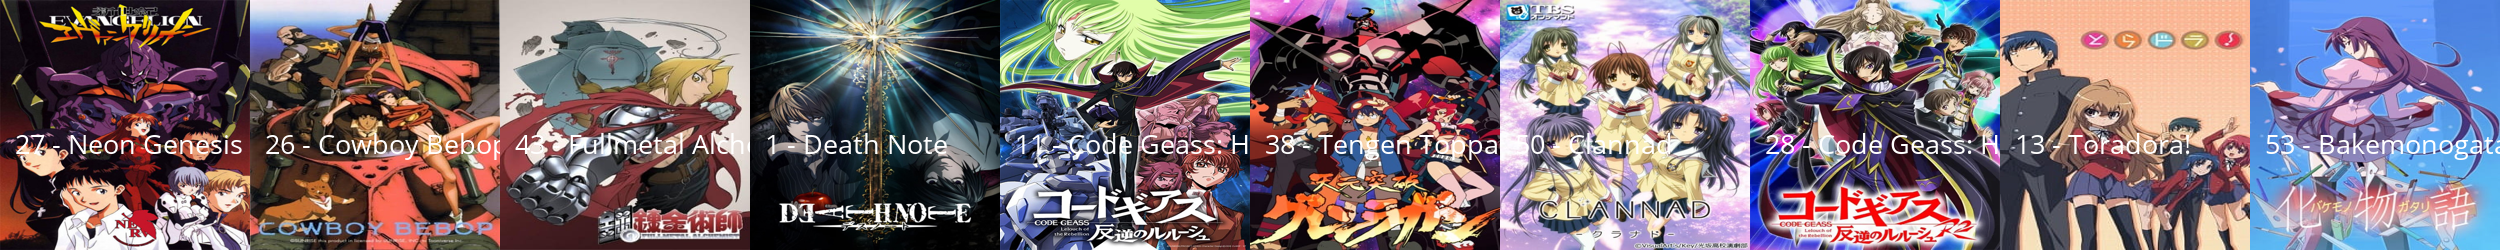

In [415]:
# Mostrar la imagen final

imagen_final

### 4. ¿Está correlacionada la cantidad de animes vistos con la "comunidad" que se pertenece? Dicha interrogante también es factible de plantear reemplazando la cantidad de animes vistos con otras variables del proyecto.

Sí, tal como se mencionó previamente, y en base a ello pueden armarse grupos distintos solo en base
a cuántos animes en promedio han visto. Así se logró una separación más real entre los clusters.

### 5. ¿La distribución de usuarios de anime sigue una distribución de Pareto?

Como se vio en una sección del análisis exploratorio, se vio que la respuesta a dicha pregunta es
que aproximadamente sí, la distribución de usuarios de anime sigue una distribución de Pareto.

Se adjunta imágenes de la distribución de Pareto, y de las distribuciones encontradas en usuarios de anime, para
una comparación visual clara.

**Distribución de Pareto:**

![Distribución de Pareto](img/Pareto_distributionPDF.png)

**Distribución de usuarios de anime:**

![Distribución de usuarios de anime por anime](img/reviews_por_anime.png)

![Distribución de usuarios de anime por usuario](img/reviews_por_usuario.png)

### 6. ¿Cuáles son los tags de Anime-Planet más correlacionados entre sí? ¿Cuáles son los tags de Anime-Planet menos correlacionados entre sí?

Ello fue analizado cuando se hizo la sección del análisis exploratorio de datos, y se llegó a la
siguiente conclusión:

Tags de anime más correlaccionados entre sí:

Top 10 de correlaciones positivas:

	1. BL y Shounen-ai tienen una correlación de 0.9694671903042547
   
	2. GL y Shoujo-ai tienen una correlación de 0.9664353820637137

	3. Earthquake y Natural Disaster tienen una correlación de 0.935360984398642
   
	4. Running y Track and Field tienen una correlación de 0.8164034532877453
   
	5. Sentai y Tokusatsu tienen una correlación de 0.8160809785836852

	6. Kingdom Building y Management tienen una correlación de 0.78306629496894
   
	7. Boarding House y Neighbors tienen una correlación de 0.767520463364294
   
	8. Art y Art School tienen una correlación de 0.7651166020924214
   
	9.  Adult Couples y Mature Romance tienen una correlación de 0.74923262576443

	10. Flower Shop y Plants tienen una correlación de 0.7070664706782244

Tags de anime menos correlaccionados entre sí:

Top 10 de correlaciones negativas:

	1. Based on a Manga y Original Work tienen una correlación de -0.3289616265573365
   
	2. Based on a Light Novel y Based on a Manga tienen una correlación de -0.2339477683434996

	3. Original Work y Shounen tienen una correlación de -0.19935751776701455
   
	4. Action y Slice of Life tienen una correlación de -0.1976005217162488
   
	5. Fantasy y Sci Fi tienen una correlación de -0.18106626445897087
   
	6. Action y Comedy tienen una correlación de -0.17581362950080848
   
	7. Based on a Manga y Based on a Video Game tienen una correlación de -0.17099174655759647
   
	8. Seinen y Shounen tienen una correlación de -0.16236638430494052
   
	9.  Action y Romance tienen una correlación de -0.15599065352221048
   
	10. Based on a Manga y Based on a Visual Novel tienen una correlación de -0.14535881328324782

En la sección exploratoria de datos igualmente se emitieron comentarios respecto a dichas
correlaciones y su aparente sentido lógico.


## ¿Qué podría salir mal?

### Data insuficiente

Al momento de recolectar los usuarios de MAL, si bien se recolectó una amplia cantidad de usuarios,
puede que no haya sido lo suficiente para poder realizar un buen modelo de clustering. Ello puede
deberse a que se cree que igualmente existe una gran variedad en los gustos y estadísticas de los
usuarios de MAL, por lo que se necesitaría una cantidad de usuarios mucho mayor para el poder
identificar realmente todos los grupos o comunidades que existn en MAL. 

Como se dijo previamente en la sección de contexto, el sitio web cuenta con más de 15 millones de
cuentas, y, debido a lo lento y tedioso que supone el extraer la información de cada usuario,
solamente se consideró la información de cerca de 9000 usuarios. Si bien es una cantidad bastante
alta, en comparación a la cantidad total de usuarios, no es muy significativa. Por lo tanto, para
una mejor iteración del proyecto, se recomienda extraer más información de los usuarios, para así
llegar a mejores conclusiones.

Valdría la pena considerar posteriormente la diferencia en los resultados obtenidos al considerar
una mayor cantidad de usuarios, y si es que se obtienen resultados más precisos o no, y bueno,
realmente distintos o no. Nuestra suposición inicial es que dentro del sitio web podría existir una
muy amplia categorización de usuarios, lo que acentúa la necesidad de considerar una mayor muestra
para efectos prácticos. Aunque dicha suposición podría estar errónea; habría que comprobarlo.


En efecto, veáse lo siguiente:

In [5]:
print(
    f"El tamaño de la muestra elegida representa cerca de {9000/15000000*100}% de la base de datos de MyAnimeList."
)


El tamaño de la muestra elegida representa cerca de 0.06% de la base de datos de MyAnimeList.


### Daño a la privacidad

En este proyecto, se utilizó información de usuarios de MAL, y se tiene en cuenta el username de
cada persona. En ese sentido, podría argumentarse que se está vulnerando en algún grado la privacidad de
los usuarios, puesto que se está utilizando información de ellos sin su consentimiento. Sin
embargo, se considera que no se está haciendo un mal uso de la información, puesto que dicha
información en principio no es sensible y se encuentra de público acceso en internet. 

Igualmente, en este proyecto para evitar cualquier problemática relacionada, podría haberse evitado
el trabajar con los nombres de usuario, y en su lugar haber utilizado un identificador único
aleatorio para cada usuario, que no tuviera relación con su nombre de usuario. Asimismo, otra forma
de solventar dicho problema habría sido consultar a la gente de MAL si están de acuerdos con el uso
que en este trabajo le dimos a su información, aunque ello habría tardado un tiempo considerable y
habría supuesto más dificultades logísticas por un lado.

Así, y considerando el libro de "Weapons of Math Destruction", es innegable que un uso masivo de la
información de usuarios podría acarrear consecuencias nocivas si no se tiene en consideración la
ética de la situación. Para este proyecto, las consecuencias no tienen un carácter tan grave, dado
que lo máximo que se podría hacer en principio con el clustering es colocar anuncios personalizados a los
usuarios de MAL, que consistirían en recomendarles animes que según el modelo les gusten en base a
su cercanía con cierta comunidad . Pero, si llegamos a considerar la fusión de esta información con otras fuentes con un nexo en común, ello
podría llegar a ser un problema si consideramos lo perjudicial de la publicidad invasiva y engañosa
que se puede generar. Se puede decir que es debido en parte a este último caso que suele ser
recomendable anonimizar los datos, para evitar que se pueda llegar a identificar a una persona en
cuestión en internet, dada la conexión que hoy en día se puede hacer con decenas de fuentes de
datos. 

En relación con ese último párrafo, realizamos la conexión con la siguiente cita de "Weapons of
Math Destruction", del capítulo 4:

* *And increasingly, the data-crunching machines are sifting through our
data on their own, searching for our habits and hopes, fears and desires.
With machine learning, a fast-growing domain of artificial intelligence,
the computer dives into the data, following only basic instructions. The
algorithm finds patterns on its own, and then, through time, connects
them with outcomes. In a sense, it learns.* (O'Neil, 2016)

### Búsqueda de patrones donde no existen en primer lugar

Como caso a considerar, puede llegar a existir el caso donde se busquen patrones en los datos, pero
la realidad es que estos estén muy separados desde un comienzo y no sean aptos para la aplicación
de modelos. Es decir, que no existan tendencias o comunidades que sirvan para el fin de nuestro
proyecto, y ciertamente nuestra pregunta no pueda tener una respuesta satisfactoria.

O, por otra parte, que las asociaciones sean tan intrincadas y difusas; complejas, que ningún
modelo existente al día de hoy las pueda identificar apropiadamente. Para resolver aquello, debería
aspirarse siempre a mejorar y variar los modelos utilizados para la Ciencia de Datos, y, no
quedarse todo el rato con lo mismo.

### Uso de datos que no desean ser usados

Dadas las dificultades inherentes que surgieron al realizar el scraping de los datos en
Anime-Planet, podría cuestionarse si verdaderamente el sitio web autoriza o no el uso de su
información para los fines aquí presentados. Por el momento, Anime-Planet no tiene una API oficial,
y la simulación requerida en los headers de las peticiones HTTP para poder realizar el scraping de
la información podría llegar a ser considerada como una violación a los términos de uso del sitio
web.

En ese sentido, se podría argumentar que el uso de los datos de Anime-Planet no es ético, y que
sería recomendable acercarse a los dueños del sitio web para consultarles si están de acuerdo con
lo realizado. Similarmente, sería una buena idea plantear a Anime-Planet la posibilidad de que abran una API
oficial, y se puedan evitar las problemáticas enfrentadas en este proyecto. 

### Problema de Escalabilidad

Este proyecto utiliza dataframes que, con la información de cerca de 9000 usuarios, ya tienen un tamaño
bastante considerable. Ahora bien, ¿qué pasaría si se quisiera escalar el proyecto a un nivel de
todos los usuarios de MyAnimeList en un momento dado? 

Creemos que ello requeriría de un excesivo tiempo de computación para el clustering, y no sería muy
cómodo de realizarse por un usuario común y corriente. La información que se utiliza sería excesiva
y probablemente cualuquier cambio hacia el modelo tardaría eternidades en hacerse efecto. Por
nuestros conocimientos actuales, si bien en el proyecto implementamos formas de paralelizar la
descarga de datos y reducir el tamaño de los dataframes (sparse matrices), no sabemos si existen
métodos aún mejores para manipular tales niveles de información.

Ello también convierte a este trabajo como uno imposible de cambiar seguidamente, a menos que
ciertos métodos de computación sean mejorados. Nos haría falta conocimientos avanzados de Big Data
para realizar un mejor trabajo. 

## Bibliografía

| Autor | Título | Fuente |
|---|---|---|
| Amat Rodrigo, J. | Clustering con Python | [Ciencia de Datos](https://cienciadedatos.net/documentos/py20-clustering-con-python) |
| Ben-Hur, A., & Guyon, I. | Detecting stable clusters using principal component analysis | [Functional Genomics: Methods and Protocols](https://www.cs.colostate.edu/~asa/pdfs/pcachap.pdf) |
| Ferjan, M. | Estadísticas de anime | [HeadphonesAddict](https://headphonesaddict.com/anime-statistics/#:~:text=Some%20estimates%20say%20that%20more%20than,2.88%20billion%20people%20watch%20anime) |
| MyAnimeList | Foro | [MyAnimeList](https://myanimelist.net/forum/) |
| O'Neil, C. | Weapons of Math Destruction | [Weapons of Math Destruction](https://edisciplinas.usp.br/pluginfile.php/4541069/mod_resource/content/2/Weapons_of_Math_Destruction.pdf) |
| Urban Dictionary | Social cataloging | [Urban Dictionary](https://www.urbandictionary.com/define.php?term=social%20cataloging) |

